In [2]:
!pip install transformers
!pip install sentencepiece
!pip install ipywidgets
!pip install tensorboard
!pip install torch torchvision

  Using cached transformers-4.16.2-py3-none-any.whl (3.5 MB)
  Using cached filelock-3.4.1-py3-none-any.whl (9.9 kB)
  Using cached huggingface_hub-0.4.0-py3-none-any.whl (67 kB)
  Using cached tokenizers-0.11.6-cp36-cp36m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (6.5 MB)
  Using cached regex-2022.3.2-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (749 kB)
  Using cached sacremoses-0.0.47-py2.py3-none-any.whl (895 kB)
  Using cached sentencepiece-0.1.96-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Using cached nltk-3.6.7-py3-none-any.whl (1.5 MB)
  Using cached ipywidgets-7.6.5-py2.py3-none-any.whl (121 kB)
  Using cached widgetsnbextension-3.5.2-py2.py3-none-any.whl (1.6 MB)
  Using cached jupyterlab_widgets-1.0.2-py3-none-any.whl (243 kB)
  Using cached nbformat-5.1.3-py3-none-any.whl (178 kB)
  Using cached jedi-0.17.2-py2.py3-none-any.whl (1.4 MB)
  Using cached parso-0.7.1-py2.py3-none-any.whl (109 kB)
  Using cached jsonschema-3.2.0-py2.py

In [6]:
import pandas as pd
import numpy as np
import random
import joblib
import torch

from sklearn import preprocessing
from sklearn import model_selection
# from DataAugmentation 
from data_utils import loadDatafromFile,createTokenizedDf,CompDataset,createkfoldData,createDataloaders
from data_utils_unlabelled import loadUnlabelledDatafromFile,createTokenizedDfUnlabelled,CompDatasetUnlabelled
from DataAugmentation import DataAugmentation
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from importlib import reload
import config
from transformers import XLMRobertaForTokenClassification, XLMRobertaConfig ,BertModel, XLMRobertaTokenizer, XLMRobertaModel, BertForTokenClassification
from seqeval.metrics import accuracy_score, classification_report
from sklearn.metrics import matthews_corrcoef,classification_report,f1_score
import engine
# from model_new import EntityModel
import torch.nn as nn
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
# from tensorboardX import SummaryWriter
from copy import copy , deepcopy
# from torchviz import make_dot, make_dot_from_trace

In [4]:
#setting seed
torch.manual_seed(config.random_seed)
np.random.seed(config.random_seed)
random.seed(config.random_seed)

In [5]:
import matplotlib.pyplot as plt
def plot_against_epochs(matrix1,matrix2,matrix3,label1 , label2 ,label3,y_label , title):
    
    epochs = np.arange(1,config.EPOCHS+1)
    # print(epochs)
    plt.plot(epochs,matrix1,label=label1)
    if matrix2 is not None :
        plt.plot(epochs,matrix2,label=label2)
    if matrix3 is not None :
         plt.plot(epochs,matrix3,label=label3)
    plt.xlabel('epochs')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

In [7]:
t = torch.cuda.get_device_properties(0)
# r = torch.cuda.memory_reserved(0)
# a = torch.cuda.memory_allocated(0)
# f = r-a  # free inside reserved
t

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)

In [8]:
# Read the labelled data
def process_data_labelled(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags,
                 filePath_src_eval,filePath_tar_eval, filePath_srcTags_eval,filePath_tarTags_eval,
                 model_type='xlm'):
    
    
    dataObjTrain = loadDatafromFile(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags)
    df_train= dataObjTrain.createDf() # get dataframe from files    
    dataObjEval = loadDatafromFile(filePath_src_eval,filePath_tar_eval, filePath_srcTags_eval,filePath_tarTags_eval)
    df_eval = dataObjEval.createDf()
    df_combined = df_train.append(df_eval, ignore_index=True)
    df_combined.reset_index(drop=True)
    split_ratio_len = int(len(df_combined) - config.test_split_ratio*len(df_combined))
    df_train_splitted = df_combined.iloc[:split_ratio_len,:]
    df_eval_splitted = df_combined.iloc[split_ratio_len:,:]
    obj_tokenized_train = createTokenizedDf(df_train_splitted,model_type)
    obj_tokenized_test = createTokenizedDf(df_eval_splitted,model_type)
    df_new_train = obj_tokenized_train.convertDf()
    df_new_eval = obj_tokenized_test.convertDf()
    train_data = CompDataset(df_new_train,model_type)
    test_data = CompDataset(df_new_eval,model_type)
    return train_data,test_data


In [9]:
train_data , eval_data = process_data_labelled(config.filePath_src,config.filePath_tar, config.filePath_srcTags,config.filePath_tarTags,config.filePath_src_eval,config.filePath_tar_eval, config.filePath_srcTags_eval,config.filePath_tarTags_eval)

In [10]:
print(len(train_data))
print(len(eval_data))

4800
3200


In [28]:
def process_data_unlabelled(filePath_src,filePath_tar,model_type):
    
    dataObj = loadUnlabelledDatafromFile(filePath_src,filePath_tar)
    df= dataObj.createDfUnlabelled() # get dataframe from files
    df['len_src'] = df['source'].str.split().map(lambda x:len(x))
    df['len_tar'] = df['target'].str.split().map(lambda x:len(x))
    
    df = df[df.len_tar != 36]
    df = df[df.len_tar != 2]
    df = df[df.len_src != 1]
    
    df=df.iloc[:,:-2]
    df = df[:1000]
#     df=df.iloc[:1000,:]
    obj_tokenized = createTokenizedDfUnlabelled(df,model_type)
    df_new= obj_tokenized.convertDf()
#     enc_label = preprocessing.LabelEncoder()
#     df_new['labels']= enc_label.fit_transform(df_new['labels'])
    train_data = CompDatasetUnlabelled(df_new,model_type)
    return df,train_data


In [29]:
df_unlabelled_train, dataset_train_unlabelled = process_data_unlabelled(config.filePath_src_backtranslated,config.filePath_tar_backtranslated,model_type = 'xlm')
len(dataset_train_unlabelled)

1000

In [30]:
#combining 2 tuples --> labelled and unlabelled data 
combined_Data = train_data + dataset_train_unlabelled
len(combined_Data)

5800

<h3>Dataloaders</h3>

In [31]:
# dataloaders
loader_obj = createDataloaders(combined_Data,config.TRAIN_BATCH_SIZE)
train_dataloader = loader_obj.createDataloaders()
len(train_dataloader)

725

In [32]:
loader_obj = createDataloaders(eval_data,config.VALID_BATCH_SIZE)
val_dataloader = loader_obj.createDataloaders()
len(val_dataloader)

400

In [17]:
# batch = next(iter(train_dataloader))
# batch # as seen, combination of labelled and unlabelled data in one training batch

In [16]:
# class GaussianNoise(nn.Module):
#     """Gaussian noise regularizer.

#     Args:
#         sigma (float, optional): relative standard deviation used to generate the
#             noise. Relative means that it will be multiplied by the magnitude of
#             the value your are adding the noise to. This means that sigma can be
#             the same regardless of the scale of the vector.
#         is_relative_detach (bool, optional): whether to detach the variable before
#             computing the scale of the noise. If `False` then the scale of the noise
#             won't be seen as a constant but something to optimize: this will bias the
#             network to generate vectors with smaller values.
#     """

#     def __init__(self, sigma=0.1, is_relative_detach=True):
#         super().__init__()
#         self.sigma = sigma
#         self.is_relative_detach = is_relative_detach
#         self.noise = torch.tensor(0).to(device)

#     def forward(self, x):
#         if self.training and self.sigma != 0:
#             scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
#             sampled_noise = self.noise.repeat(*x.size()).normal_() * scale
#             x = x + sampled_noise
#         return x 

In [17]:
# # loss = nn.MSELoss()
# a = torch.tensor([[0.435,0.565],[0.820,0.180]])
# b = torch.tensor([[0.620,0.380],[0.545,0.455]])
# ConsistencyCost(a,b)

In [18]:
class GaussianNoise(nn.Module):
    
    def __init__(self, stddev):
        
        super().__init__()
        
        self.stddev = stddev

    def forward(self, din):
        
        if self.training:
            return din + torch.autograd.Variable(torch.randn(din.size()).cuda() * self.stddev)
        
        return din

In [19]:
class EntityModel(nn.Module):
    
    def __init__(self,std_gaussian=0.1,with_noise_layer = True, dropout_layer=False, dropout_prob = 0.3):
        
        super(EntityModel, self).__init__()
        
        self.std_gaussian = std_gaussian
        self.with_noise_layer = with_noise_layer
        self.bert = XLMRobertaModel.from_pretrained(config.BASE_MODEL,output_attentions = False, output_hidden_states = False , add_pooling_layer = False)
        self.dropout_layer = dropout_layer
        self.dropout_prob = dropout_prob
        if self.with_noise_layer:
            self.noise = GaussianNoise(stddev=self.std_gaussian)
        if self.dropout_layer:
            self.bert_drop_1 = nn.Dropout(self.dropout_prob) # remove this or noise 
        self.out_tag = nn.Linear(768, 2)
        self.softmax = nn.Softmax(dim=2)
    
    def forward(self, ids, attention_mask):
        
        outputs = self.bert(ids,
                            attention_mask = attention_mask,
                            return_dict=False)
        
        if (self.with_noise_layer):
            
            noise = self.noise(outputs[0]) # 256*768
            
            if self.dropout_layer:
                bo_tag = self.bert_drop_1(noise)
                tag = self.out_tag(bo_tag)
            else:
                tag = self.out_tag(noise)
        
        else:
            
            if self.dropout_layer:
                bo_tag = self.bert_drop_1(outputs[0])
                tag = self.out_tag(bo_tag)
            
            else :
                tag = self.out_tag(outputs[0])
#         tag = self.out_tag(bo_tag) # 256 * 2 
       
        softmax_prob = self.softmax(tag)
        
#         loss_tag = loss_fn(tag,labels,attention_mask)
        
        return softmax_prob,tag
#         return outputs[0], outputs[1]
        

In [55]:
# model = EntityModel(std_gaussian=config.gaussian_noise_std_student, with_noise_layer=True )
# model.cuda()# print(noise ,embeddings)

In [56]:
# model2 = EntityModel(std_gaussian=config.gaussian_noise_std_teacher)
# model2.cuda()
# outputs, outputs1 = model2(batch[0].cuda(), attention_mask = batch[1].cuda())
# print(outputs,'\n')
# print(outputs1)

In [20]:
def ClassificationCost(output,target,mask):
    
    
    active_loss = mask.view(-1) == 1 #loss calculation for non padded tokens only (mask =1)
    active_logits = output.view(-1,2)
    
    active_labels = torch.where( # just append -100 for the padded tokens so its ignored when computing loss , no need now
        active_loss,             # since its handled in preprocessing only
        target.view(-1),
        torch.tensor(-100).type_as(target)    
    )
    try:
        class_0_weights =1/len(torch.where(active_labels==0)[0]) # trying to weight the labels as its unbalanced mostly
    
    except ZeroDivisionError:
        class_0_weights = 1e-8

    try:
        class_1_weights =1/len(torch.where(active_labels==1)[0])
    
    except ZeroDivisionError:
        class_1_weights = 1e-8
    
    weights_tensor = torch.tensor([class_0_weights,class_1_weights]).cuda()
    lfn = nn.CrossEntropyLoss(weight = weights_tensor)
    loss = lfn(active_logits,active_labels)
    
    return loss

In [21]:
def ConsistencyCost(student_output, teacher_output,mask, scale = config.consistency_cost_scale):
    
    assert len(student_output) == len(teacher_output)
    
    loss = nn.MSELoss()
    active_outputs = mask.view(-1) == 1 #loss calculation for non padded tokens only (mask =1)
    flattened_outputs_student = student_output.view(-1,2)
    flatenned_outputs_teacher = teacher_output.view(-1,2)

    active_outputs_teacher=flatenned_outputs_teacher[torch.where(active_outputs == 1)]
    active_outputs_student=flattened_outputs_student[torch.where(active_outputs == 1)]
    
    return torch.sqrt(loss(active_outputs_student,active_outputs_teacher))
    

In [22]:
# Update teacher to be exponential moving average of student params.
def update_teacher_params(student_model, teacher_model, alpha, global_step):
    #Use the true average until the exponential average is more correct

    teacher_params = teacher_model.parameters()
    student_params = student_model.parameters()
    
    assert sum(p.numel() for p in student_model.parameters()) == sum(p.numel() for p in teacher_model.parameters())
    
#     alpha = min(1 - 1 / (global_step + 1), alpha) # (1-1/2 , 0.995) 
    
    for teacher_param, student_param in zip(teacher_model.parameters(), student_model.parameters()):
            teacher_param.data.mul_(config.alpha).add_(1 - config.alpha, student_param.data)
            # alpha * (teachers_params) + (1-alpha) * (student_params)
    return teacher_model

In [25]:
writer = SummaryWriter("runs/MeanTeacher_temp")

In [41]:
# def train(train_dataloader, optimizer,scheduler, student_model, teacher_model,
#           epoch , writer , global_step, scale_consistency):
    
#     student_model.train() # put student model in training mode
#     total_train_loss = 0
#     consistency_cst = 0
#     classification_cst=0
# #     classification_cst_lst = []
# #     consistency_cst_lst = []
# #     overall_cst_lst = []
# #    global global_step = 0

    
#     for step, batch in enumerate(tqdm(train_dataloader, total = len(train_dataloader),position = 0 , leave = True)):

    
#         b_input_ids = batch[0].cuda()
#         b_input_mask = batch[1].cuda()
#         b_labels = batch[2].cuda()
# #            optimizer.zero_grad()
        
        
#         output_student_softmax, output_student_logit = student_model( b_input_ids, attention_mask = b_input_mask )
        
#         with torch.no_grad():
            
#             output_teacher_softmax, _ = teacher_model(b_input_ids, attention_mask = b_input_mask)
            
#         classification_cost =  ClassificationCost(output_student_logit,b_labels,b_input_mask)
#         classification_cst+=classification_cost.item()
        
#         writer.add_scalar('TrainingLoss/Classification', classification_cost.item(), global_step)
        
#         consistency_cost = ConsistencyCost(output_student_softmax,output_teacher_softmax,b_input_mask,scale_consistency)
#         consistency_cst+=consistency_cost.item()
        
#         writer.add_scalar('TrainingLoss/Consistency', consistency_cost.item(), global_step)
        
#         overall_cost = (config.ratio * classification_cost) + ((1 - config.ratio) * consistency_cost) # L = loss + lmda * 
        
#         writer.add_scalar('TrainingLoss/Overall', overall_cost.item(), global_step)

        
#         overall_cost.backward()
        
#         total_train_loss+=overall_cost.item()   
        
#         nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
        
#         optimizer.step()
#         scheduler.step()
#         optimizer.zero_grad()
        
#         teacher_model = update_teacher_params(student_model , teacher_model , config.alpha,global_step)

            
#         if step % 100 == 0 and step!=0:
#             print ('Overall train loss : ', total_train_loss)
#             print('Consistency Cost :', consistency_cst)
#             print('Classification Cost :', classification_cst)   
#             print(global_step)
        

#         global_step+=1
 
        
#     return (consistency_cst/len(train_dataloader), classification_cst/len(train_dataloader), total_train_loss/len(train_dataloader),global_step)

In [23]:
def train(train_dataloader, optimizer,scheduler, student_model, teacher_model,
          epoch  , global_step, scale_consistency):
    
#     student_model.train() # put student model in training mode
    total_train_loss = 0
    consistency_cst = 0
    classification_cst=0
#     classification_cst_lst = []
#     consistency_cst_lst = []
#     overall_cst_lst = []
#     global_step = 0
    
    for step, batch in enumerate(tqdm(train_dataloader, total = len(train_dataloader),position = 0 , leave = True)):

        
            
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_labels = batch[2].cuda()
        optimizer.zero_grad()
        
        output_student_softmax, output_student_logit = student_model( b_input_ids, attention_mask = b_input_mask )
        
        with torch.no_grad():
            
            output_teacher_softmax, _ = teacher_model( b_input_ids, attention_mask = b_input_mask )
            
        classification_cost =  ClassificationCost(output_student_logit,b_labels,b_input_mask)
        classification_cst+=classification_cost.item()
        
#         writer.add_scalar('TrainingLoss/Classification', classification_cost.item(), global_step)

        consistency_cost = ConsistencyCost(output_student_softmax,output_teacher_softmax,b_input_mask)
        consistency_cst+=consistency_cost.item()
        
#         writer.add_scalar('TrainingLoss/Consistency', consistency_cost.item(), global_step)
        
        overall_cost = (config.ratio * classification_cost) + ((1 - config.ratio) * consistency_cost)
        
#         writer.add_scalar('TrainingLoss/Overall', overall_cost.item(), global_step)
        
        overall_cost.backward()
        optimizer.step()
        scheduler.step()
        
        total_train_loss+=overall_cost.item()
        
        teacher_model = update_teacher_params(student_model , teacher_model , config.alpha,global_step)
       
        
        if step % 100 == 0 and step!=0:
            print ('train loss : ', total_train_loss/step)
            print('Consistency Cost :', consistency_cst/step)
            print('Classification Cost :', classification_cst/step)                        
            print(global_step)
            

#             break
        global_step+=1
   
        
    return (consistency_cst/len(train_dataloader), classification_cst/len(train_dataloader), total_train_loss/len(train_dataloader),global_step)

In [33]:
def test( model, test_loader):
    
    model.eval()
    test_loss = 0
    correct = 0
    lst_active_preds = []
    lst_active_labels = []
   
        
    for batch in tqdm(test_loader,total = len(test_loader),position = 0 , leave = True):
        
        b_input_ids_eval = batch[0].cuda()
        b_input_mask_eval = batch[1].cuda()
        b_labels_eval = batch[2].cuda()
        
        _, output= model(b_input_ids_eval,attention_mask = b_input_mask_eval)
        
        classification_cost =  ClassificationCost(output,b_labels_eval,b_input_mask_eval)
        test_loss+=classification_cost
        
        labels = b_labels_eval.view(-1) 
        active_logits = output.view(-1, 2)
        flattened_predictions = torch.argmax(active_logits, axis=1)
        active_accuracy = labels.view(-1) != -100
        labels_tmp = torch.masked_select(labels, active_accuracy) 
        pred_tmp = torch.masked_select(flattened_predictions, active_accuracy) 
        lst_active_labels.extend(labels_tmp.tolist())
        lst_active_preds.extend(pred_tmp.tolist())
        
    avg_f1_score_0=f1_score(lst_active_labels,lst_active_preds,average='binary',pos_label = 0)
    avg_f1_score_1=f1_score(lst_active_labels,lst_active_preds,average='binary',pos_label = 1)
    avg_accuracy_score=accuracy_score(lst_active_labels,lst_active_preds)
    avg_mcc_score = matthews_corrcoef(lst_active_labels,lst_active_preds)
    
    test_loss /= len(test_loader)
    
    print('Overall validation loss:', test_loss)
    print('Average F1 Validation score for whole sentence class 0 :' ,avg_f1_score_0)
    print('Average F1 Validation score for whole sentence class 1 :' ,avg_f1_score_1)
    print('Average Accuracy Validation score whole sentence  :' ,avg_accuracy_score)
    print('Average mcc Validation score whole sentence :' ,avg_mcc_score)
    print('Classification Report :'+'\n', classification_report(lst_active_labels,lst_active_preds))

    return (test_loss, avg_f1_score_0 , avg_f1_score_1, avg_accuracy_score, avg_mcc_score)

In [34]:
def train_MeanTeacher(train_dataloader, val_dataloader,noise_layer=True, dropout_layer = False):
    

    global_step=0
    # train losses
    epochs_consistency_lst =[]
    epochs_classification_lst = []
    epochs_overall_lst = []
    
    #test metrices for student
    epochs_f1_score_0_lst_student = []
    epochs_f1_score_1_lst_student = []
    epochs_accuracy_lst_student = []
    epochs_mcc_lst_student = []
    epochs_cost_lst_student=[]
    
    #test metrices for teacher
    epochs_f1_score_0_lst_teacher= []
    epochs_f1_score_1_lst_teacher = []
    epochs_accuracy_lst_teacher = []
    epochs_mcc_lst_teacher = []
    epochs_cost_lst_teacher=[]
    
    #initialaize the language models
    student = EntityModel(std_gaussian=config.gaussian_noise_std_student, with_noise_layer=noise_layer,dropout_layer=dropout_layer) 
    teacher = EntityModel(std_gaussian=config.gaussian_noise_std_teacher, with_noise_layer=noise_layer,dropout_layer=dropout_layer)
    
    student.cuda() # take model to gpu
    teacher.cuda()
#     teacher.eval()
    param_optimizer_student = list(student.named_parameters())
    param_teacher = list(teacher.named_parameters())
    
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer_student if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer_student if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
    optimizer = AdamW(optimizer_parameters, lr=config.lr)
    num_train_steps = int(len(train_dataloader) * config.EPOCHS)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#         optimizer, T_max=num_train_steps)
    scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)
    for epoch in range(0,config.EPOCHS):
        print(f'Current epoch is {epoch+1} of {config.EPOCHS}')
        
       
        consistency_cost , classification_cost , overall_cost, globa_step = train(train_dataloader, optimizer,scheduler,student,
                                                                                  teacher,epoch,global_step,scale_consistency=100)
        
#         writer.add_scalar('TrainingLoss/Consistency_epoch :', consistency_cost,epoch )
#         writer.add_scalar('TrainingLoss/Classification_epoch', classification_cost,epoch)
#         writer.add_scalar('TrainingLoss/Overall_epoch',overall_cost,epoch)
        epochs_consistency_lst.append(consistency_cost)
        epochs_classification_lst.append(classification_cost)
        epochs_overall_lst.append(overall_cost)
        
        print('---------Running validation for student -------------')
        test_loss_student, avg_f1_score_0_student, avg_f1_score_1_student, avg_accuracy_score_student, avg_mcc_score_student = test(student,val_dataloader)
        
        epochs_f1_score_0_lst_student.append(avg_f1_score_0_student)
        epochs_f1_score_1_lst_student.append(avg_f1_score_1_student)
        epochs_accuracy_lst_student.append(avg_accuracy_score_student)
#         writer.add_scalar('mcc_score/Student',avg_mcc_score_student,epoch)
#         writer.add_scalar('ValidationLoss/Student',test_loss_student,epoch)

        epochs_mcc_lst_student.append(avg_mcc_score_student)
        epochs_cost_lst_student.append(test_loss_student)
        
#         for name, weight in student.named_parameters():
            
#             if name == 'bert.embeddings.LayerNorm.weight':
#                 writer.add_histogram(name,weight, epoch)
#             if name =='bert.encoder.layer.0.attention.output.LayerNorm.weight':
#                 writer.add_histogram(name,weight, epoch)
#             if name =='bert.encoder.layer.1.attention.output.dense.weight':
#                 writer.add_histogram(name,weight, epoch)
#             if name =='bert.encoder.layer.2.output.dense.weight':
#                 writer.add_histogram(name,weight, epoch)
#             if name == 'bert.encoder.layer.5.attention.self.key.weight':
#                 writer.add_histogram(name,weight, epoch)
#             if name == 'bert.encoder.layer.9.attention.self.key.weight':
#                 writer.add_histogram(name,weight, epoch)
#             if name == 'bert.encoder.layer.10.attention.output.LayerNorm.weight':
#                 writer.add_histogram(name,weight, epoch)
#             if name == 'bbert.encoder.layer.11.output.LayerNorm.weight':
#                 writer.add_histogram(name,weight, epoch)
#             if name == 'out_tag.weight':
#                 writer.add_histogram(name,weight, epoch)
        
        print('---------Running validation for teacher -------------')

        test_loss_teacher, avg_f1_score_0_teacher, avg_f1_score_1_teacher,avg_accuracy_score_teacher, avg_mcc_score_teacher=test(teacher,val_dataloader)
        
        epochs_f1_score_0_lst_teacher.append(avg_f1_score_1_teacher)
        epochs_f1_score_1_lst_teacher.append(avg_f1_score_0_teacher)
        epochs_accuracy_lst_teacher.append(avg_accuracy_score_teacher)
#         writer.add_scalar('mcc_score/Teacher',avg_mcc_score_teacher,epoch)
#         writer.add_scalar('ValidationLoss/Teacher',test_loss_teacher,epoch)
        epochs_mcc_lst_teacher.append(avg_mcc_score_teacher)
        epochs_cost_lst_teacher.append(test_loss_teacher)
        
#         for name, weight in teacher.named_parameters():
#             if name == 'bert.embeddings.LayerNorm.weight':
#                 writer.add_histogram(name,weight, epoch)
#             if name =='bert.encoder.layer.0.attention.output.LayerNorm.weight':
#                 writer.add_histogram(name,weight, epoch)
#             if name =='bert.encoder.layer.1.attention.output.dense.weight':
#                 writer.add_histogram(name,weight, epoch)
#             if name =='bert.encoder.layer.2.output.dense.weight':
#                 writer.add_histogram(name,weight, epoch)
#             if name == 'bert.encoder.layer.5.attention.self.key.weight':
#                 writer.add_histogram(name,weight, epoch)
#             if name == 'bert.encoder.layer.9.attention.self.key.weight':
#                 writer.add_histogram(name,weight, epoch)
#             if name == 'bert.encoder.layer.10.attention.output.LayerNorm.weight':
#                 writer.add_histogram(name,weight, epoch)
#             if name == 'bbert.encoder.layer.11.output.LayerNorm.weight':
#                 writer.add_histogram(name,weight, epoch)
#             if name == 'out_tag.weight':
#                 writer.add_histogram(name,weight, epoch)
                
        
#         writer.add_hparams(
#             {"lr": config.lr, "bsize": config.TRAIN_BATCH_SIZE, "shuffle":shuffle},
#             {
#                 "accuracy": avg_mcc_score_teacher,
#                 "loss": test_loss_teacher,
#             },
#         )
        
#     writer.close()   
    return (epochs_consistency_lst,epochs_classification_lst,epochs_overall_lst,epochs_f1_score_0_lst_student,epochs_f1_score_1_lst_student,
           epochs_accuracy_lst_student,epochs_mcc_lst_student,epochs_cost_lst_student,epochs_f1_score_0_lst_teacher,epochs_f1_score_1_lst_teacher,
            epochs_accuracy_lst_teacher,epochs_mcc_lst_teacher,epochs_cost_lst_teacher)

In [34]:
model = EntityModel()


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
# for n,p in model.named_parameters():
#     print (n)

In [51]:
# def plot_grad_flow(named_parameters):
#     '''Plots the gradients flowing through different layers in the net during training.
#     Can be used for checking for possible gradient vanishing / exploding problems.
    
#     Usage: Plug this function in Trainer class after loss.backwards() as 
#     "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
#     ave_grads = []
#     max_grads= []
#     layers = []
#     for n, p in named_parameters:
#         if(p.requires_grad) and ("bias" not in n):
#             layers.append(n)
#             ave_grads.append(p.grad.abs().mean())
#             max_grads.append(p.grad.abs().max())
#     plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
#     plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
#     plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
#     plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
#     plt.xlim(left=0, right=len(ave_grads))
#     plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
#     plt.xlabel("Layers")
#     plt.ylabel("average gradient")
#     plt.title("Gradient flow")
#     plt.grid(True)
#     plt.legend([Line2D([0], [0], color="c", lw=4),
#                 Line2D([0], [0], color="b", lw=4),
#                 Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])


In [37]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved()
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
r

0

In [46]:
# config = reload(config)

In [30]:
# model = EntityModel()
# print(model)
# params = model.named_parameters()
# for n,p in (params):
#     print(p.grad)

In [31]:
# config=reload(config)
# writer = SummaryWriter("runs/MeanTeacher")

In [35]:
metrices = train_MeanTeacher(train_dataloader,val_dataloader, noise_layer=True)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler

Current epoch is 1 of 3


 14%|█▍        | 101/725 [00:52<05:28,  1.90it/s]

train loss :  0.41773427844047545
Consistency Cost : 0.16646273896098138
Classification Cost : 0.6690058207511902
100


 28%|██▊       | 201/725 [01:45<04:40,  1.87it/s]

train loss :  0.4093369773030281
Consistency Cost : 0.1665072597563267
Classification Cost : 0.6521666958928108
200


 42%|████▏     | 301/725 [02:39<03:49,  1.85it/s]

train loss :  0.4045377857486407
Consistency Cost : 0.16600541800260543
Classification Cost : 0.6430701545874278
300


 55%|█████▌    | 401/725 [03:33<02:56,  1.84it/s]

train loss :  0.39981151558458805
Consistency Cost : 0.16523278709501027
Classification Cost : 0.6343902444839478
400


 69%|██████▉   | 501/725 [04:28<02:02,  1.83it/s]

train loss :  0.3945311652421951
Consistency Cost : 0.16489091083407403
Classification Cost : 0.6241714199781417
500


 83%|████████▎ | 601/725 [05:23<01:07,  1.83it/s]

train loss :  0.3914693595468998
Consistency Cost : 0.16357371379931768
Classification Cost : 0.6193650056918462
600


 97%|█████████▋| 701/725 [06:18<00:13,  1.82it/s]

train loss :  0.3881299542103495
Consistency Cost : 0.1623308741407735
Classification Cost : 0.6139290341734887
700


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


  0%|          | 1/400 [00:00<02:22,  2.80it/s]


RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 14.76 GiB total capacity; 13.72 GiB already allocated; 21.75 MiB free; 14.08 GiB reserved in total by PyTorch)

In [50]:
!nvidia-smi

Thu Mar  3 12:02:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   34C    P0    26W /  70W |  15086MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [49]:
torch.cuda.empty_cache()

<h3> Running with Gaussian Noise in embeddings and without dropout </h3> scaling const. cost by 10 

In [35]:
# consistency scale was 10 for this experiment
metrices = train_MeanTeacher(train_dataloader,val_dataloader,noise_layer=True) # alpha = 0.995 and full data w/o noise and dropout
print('Consistency_lost_train :',metrices[0],'\n','Classificataion_lost_train : ',metrices[1],'\n','Overall_loss_train :',metrices[2],'\n',
      'f1_class0_student_test :',metrices[3],'\n','f1_class1_student_test :',metrices[4],'\n','accuracy_student :',metrices[5],'\n','mcc_cost_student :',metrices[6],
      '\n','test_cost_student :',metrices[7],'\n','f1_class0_teacher_test :',metrices[8],'\n','f1_class1_teacher_test :',metrices[9],'\n',
    'accuracy_teacher :', metrices[10],'\n','mcc_cost_teacher',metrices[11],'\n','test_cost_teacher',metrices[12])

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are ini

Current epoch is 1 of 6


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /codebuild/output/src811146734/src/torch/csrc/utils/python_arg_parser.cpp:766.)
  del sys.path[0]
  3%|▎         | 51/1475 [00:32<15:02,  1.58it/s]

train loss :  0.5200645703077317
Consistency Cost : 0.23800424844026566
Classification Cost : 0.8021248924732208


  7%|▋         | 101/1475 [01:04<14:45,  1.55it/s]

train loss :  0.48742605924606325
Consistency Cost : 0.2100828817486763
Classification Cost : 0.7647692370414734


 10%|█         | 151/1475 [01:36<14:22,  1.53it/s]

train loss :  0.46647052745024364
Consistency Cost : 0.20125033448139826
Classification Cost : 0.7316907207171123


 14%|█▎        | 201/1475 [02:08<13:29,  1.57it/s]

train loss :  0.4595454016327858
Consistency Cost : 0.19430298753082753
Classification Cost : 0.7247878158092499


 17%|█▋        | 251/1475 [02:40<12:49,  1.59it/s]

train loss :  0.45186425310373307
Consistency Cost : 0.18694044011831285
Classification Cost : 0.7167880663871765


 20%|██        | 301/1475 [03:11<12:17,  1.59it/s]

train loss :  0.44652387643853825
Consistency Cost : 0.18311338494221369
Classification Cost : 0.7099343681335449


 24%|██▍       | 351/1475 [03:43<11:43,  1.60it/s]

train loss :  0.44128211255584443
Consistency Cost : 0.17802148876445634
Classification Cost : 0.7045427363259452


 27%|██▋       | 401/1475 [04:14<11:13,  1.59it/s]

train loss :  0.4356343638151884
Consistency Cost : 0.17358106549829244
Classification Cost : 0.6976876620948315


 31%|███       | 451/1475 [04:45<10:43,  1.59it/s]

train loss :  0.4311689320454995
Consistency Cost : 0.16979458472794956
Classification Cost : 0.6925432791974809


 34%|███▍      | 501/1475 [05:17<10:17,  1.58it/s]

train loss :  0.42692141530662775
Consistency Cost : 0.16645910146832466
Classification Cost : 0.6873837288618088


 37%|███▋      | 551/1475 [05:49<09:50,  1.56it/s]

train loss :  0.42218006324361673
Consistency Cost : 0.16278730327432805
Classification Cost : 0.6815728230909868


 41%|████      | 601/1475 [06:21<09:24,  1.55it/s]

train loss :  0.4171873305241267
Consistency Cost : 0.15889556301136812
Classification Cost : 0.6754790978630384


 44%|████▍     | 651/1475 [06:54<08:58,  1.53it/s]

train loss :  0.4140242395034203
Consistency Cost : 0.1551354735172712
Classification Cost : 0.6729130052603208


 48%|████▊     | 701/1475 [07:27<08:35,  1.50it/s]

train loss :  0.4100960099271366
Consistency Cost : 0.15186463205942086
Classification Cost : 0.6683273876990591


 51%|█████     | 751/1475 [08:00<07:48,  1.55it/s]

train loss :  0.40554845925668875
Consistency Cost : 0.14855094283819198
Classification Cost : 0.6625459757248561


 54%|█████▍    | 801/1475 [08:32<07:08,  1.57it/s]

train loss :  0.4026870854245499
Consistency Cost : 0.14570750658400355
Classification Cost : 0.659666664339602


 58%|█████▊    | 851/1475 [09:03<06:32,  1.59it/s]

train loss :  0.3997657960346516
Consistency Cost : 0.14294708846246496
Classification Cost : 0.6565845039311577


 61%|██████    | 901/1475 [09:35<06:02,  1.59it/s]

train loss :  0.39526630693839654
Consistency Cost : 0.14006556751827398
Classification Cost : 0.6504670468303893


 64%|██████▍   | 951/1475 [10:06<05:30,  1.58it/s]

train loss :  0.3926325069995303
Consistency Cost : 0.13723173997904126
Classification Cost : 0.6480332743494134


 68%|██████▊   | 1001/1475 [10:38<05:01,  1.57it/s]

train loss :  0.38954257460683583
Consistency Cost : 0.13465990905463696
Classification Cost : 0.6444252406358719


 71%|███████▏  | 1051/1475 [11:10<04:31,  1.56it/s]

train loss :  0.38777096869690075
Consistency Cost : 0.13244298916487468
Classification Cost : 0.6430989485127585


 75%|███████▍  | 1101/1475 [11:42<04:02,  1.54it/s]

train loss :  0.38457849228246643
Consistency Cost : 0.12996337454427373
Classification Cost : 0.6391936100883917


 78%|███████▊  | 1151/1475 [12:15<03:32,  1.53it/s]

train loss :  0.3817589552473763
Consistency Cost : 0.12767398387841555
Classification Cost : 0.6358439267977424


 81%|████████▏ | 1201/1475 [12:48<03:03,  1.49it/s]

train loss :  0.38001733059373993
Consistency Cost : 0.12559746788193782
Classification Cost : 0.6344371934235096


 85%|████████▍ | 1251/1475 [13:22<02:32,  1.47it/s]

train loss :  0.37680924537926913
Consistency Cost : 0.12339652545154095
Classification Cost : 0.6302219653606415


 88%|████████▊ | 1301/1475 [13:56<01:59,  1.45it/s]

train loss :  0.37440530839591074
Consistency Cost : 0.1213963279586572
Classification Cost : 0.6274142889334605


 92%|█████████▏| 1351/1475 [14:30<01:25,  1.45it/s]

train loss :  0.3721012197545281
Consistency Cost : 0.11940445978608397
Classification Cost : 0.6247979799685655


 95%|█████████▍| 1401/1475 [15:05<00:49,  1.49it/s]

train loss :  0.3706540663686714
Consistency Cost : 0.11767785621274794
Classification Cost : 0.6236302768758365


 98%|█████████▊| 1451/1475 [15:37<00:15,  1.55it/s]

train loss :  0.36871776786986094
Consistency Cost : 0.11591402425848205
Classification Cost : 0.6215215117561406


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:42<00:00,  9.51it/s]


Overall validation loss: tensor(0.5901, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3884688409297727
Average F1 Validation score for whole sentence class 1 : 0.8478841043038907
Average Accuracy Validation score whole sentence  : 0.7563701465816269
Average mcc Validation score whole sentence : 0.290641418510297


  0%|          | 0/400 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.28      0.61      0.39     28264
           1       0.93      0.78      0.85    195161

    accuracy                           0.76    223425
   macro avg       0.61      0.69      0.62    223425
weighted avg       0.85      0.76      0.79    223425

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.57it/s]


Overall validation loss: tensor(0.5637, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.38499742440882895
Average F1 Validation score for whole sentence class 1 : 0.816034375990301
Average Accuracy Validation score whole sentence  : 0.7167863936443997
Average mcc Validation score whole sentence : 0.29591914599208236


  0%|          | 0/1475 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.27      0.70      0.38     28264
           1       0.94      0.72      0.82    195161

    accuracy                           0.72    223425
   macro avg       0.60      0.71      0.60    223425
weighted avg       0.86      0.72      0.76    223425

Current epoch is 2 of 6


  3%|▎         | 51/1475 [00:31<14:54,  1.59it/s]

train loss :  0.32151098549366
Consistency Cost : 0.07031877920031547
Classification Cost : 0.5727031856775284


  7%|▋         | 101/1475 [01:03<14:28,  1.58it/s]

train loss :  0.3139057624712586
Consistency Cost : 0.06863595452159643
Classification Cost : 0.5591755676269531


 10%|█         | 151/1475 [01:35<14:02,  1.57it/s]

train loss :  0.3072608234236638
Consistency Cost : 0.0678108885884285
Classification Cost : 0.5467107562224071


 14%|█▎        | 201/1475 [02:07<13:35,  1.56it/s]

train loss :  0.3091587838344276
Consistency Cost : 0.06789359018206596
Classification Cost : 0.5504239764809609


 17%|█▋        | 251/1475 [02:39<13:14,  1.54it/s]

train loss :  0.312271975800395
Consistency Cost : 0.06743725429475307
Classification Cost : 0.5571066963672638


 20%|██        | 301/1475 [03:12<12:54,  1.52it/s]

train loss :  0.30868837143604955
Consistency Cost : 0.06558415425320466
Classification Cost : 0.5517925874392191


 24%|██▍       | 351/1475 [03:45<12:36,  1.49it/s]

train loss :  0.30979452023016557
Consistency Cost : 0.06546807642493929
Classification Cost : 0.5541209635564259


 27%|██▋       | 401/1475 [04:19<12:12,  1.47it/s]

train loss :  0.3099184701172635
Consistency Cost : 0.06450252220965921
Classification Cost : 0.555334417372942


 31%|███       | 451/1475 [04:53<11:48,  1.45it/s]

train loss :  0.3070190678536892
Consistency Cost : 0.06260027926829126
Classification Cost : 0.5514378558264839


 34%|███▍      | 501/1475 [05:28<11:12,  1.45it/s]

train loss :  0.30589591751247647
Consistency Cost : 0.06144954584166407
Classification Cost : 0.5503422892093659


 37%|███▋      | 551/1475 [06:02<10:35,  1.46it/s]

train loss :  0.30519778427075256
Consistency Cost : 0.06070467830042947
Classification Cost : 0.5496908903121949


 41%|████      | 601/1475 [06:36<09:58,  1.46it/s]

train loss :  0.30471625859073054
Consistency Cost : 0.06003941077739
Classification Cost : 0.549393106624484


 44%|████▍     | 651/1475 [07:11<09:26,  1.46it/s]

train loss :  0.30387909065788754
Consistency Cost : 0.059422759992571975
Classification Cost : 0.548335421704329


 48%|████▊     | 701/1475 [07:44<08:21,  1.54it/s]

train loss :  0.30349940876476467
Consistency Cost : 0.058865422545267006
Classification Cost : 0.5481333951226303


 51%|█████     | 751/1475 [08:16<07:40,  1.57it/s]

train loss :  0.3032857315937678
Consistency Cost : 0.0583687660296758
Classification Cost : 0.5482026969790459


 54%|█████▍    | 801/1475 [08:47<07:04,  1.59it/s]

train loss :  0.3024702494032681
Consistency Cost : 0.05751241683261469
Classification Cost : 0.5474280815385282


 58%|█████▊    | 851/1475 [09:19<06:33,  1.59it/s]

train loss :  0.3024401191205663
Consistency Cost : 0.05684873402118683
Classification Cost : 0.5480315036458128


 61%|██████    | 901/1475 [09:50<06:03,  1.58it/s]

train loss :  0.3025397614120609
Consistency Cost : 0.05663004624346892
Classification Cost : 0.5484494759804672


 64%|██████▍   | 951/1475 [10:22<05:33,  1.57it/s]

train loss :  0.30181837037205694
Consistency Cost : 0.05581877876465258
Classification Cost : 0.547817961401061


 68%|██████▊   | 1001/1475 [10:54<05:04,  1.55it/s]

train loss :  0.30137978017516437
Consistency Cost : 0.055700182303786275
Classification Cost : 0.5470593776255847


 71%|███████▏  | 1051/1475 [11:27<04:35,  1.54it/s]

train loss :  0.30124202514865567
Consistency Cost : 0.05523281404659862
Classification Cost : 0.5472512357433637


 75%|███████▍  | 1101/1475 [11:59<04:07,  1.51it/s]

train loss :  0.30173030822961167
Consistency Cost : 0.054826462768356905
Classification Cost : 0.5486341531574727


 78%|███████▊  | 1151/1475 [12:33<03:39,  1.48it/s]

train loss :  0.30063547441087984
Consistency Cost : 0.05449530662077925
Classification Cost : 0.5467756416616233


 81%|████████▏ | 1201/1475 [13:07<03:07,  1.46it/s]

train loss :  0.30038953067967666
Consistency Cost : 0.05420705918843548
Classification Cost : 0.5465720016385118


 85%|████████▍ | 1251/1475 [13:41<02:34,  1.45it/s]

train loss :  0.30030490073561666
Consistency Cost : 0.05401773736178875
Classification Cost : 0.5465920635819436


 88%|████████▊ | 1301/1475 [14:15<01:52,  1.54it/s]

train loss :  0.2994512509096127
Consistency Cost : 0.05356452276213811
Classification Cost : 0.5453379786702303


 92%|█████████▏| 1351/1475 [14:47<01:18,  1.57it/s]

train loss :  0.2988605793841459
Consistency Cost : 0.05327663175623726
Classification Cost : 0.5444445265663995


 95%|█████████▍| 1401/1475 [15:19<00:46,  1.58it/s]

train loss :  0.2981408709686782
Consistency Cost : 0.05296759182188128
Classification Cost : 0.5433141497841903


 98%|█████████▊| 1451/1475 [15:50<00:15,  1.58it/s]

train loss :  0.29803229398511605
Consistency Cost : 0.05276903000499668
Classification Cost : 0.5432955576633585


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:42<00:00,  9.48it/s]


Overall validation loss: tensor(0.5423, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.4218839779627982
Average F1 Validation score for whole sentence class 1 : 0.8567040221619644
Average Accuracy Validation score whole sentence  : 0.7703345641714222
Average mcc Validation score whole sentence : 0.33543854113974547


  0%|          | 0/400 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.31      0.66      0.42     28264
           1       0.94      0.79      0.86    195161

    accuracy                           0.77    223425
   macro avg       0.63      0.72      0.64    223425
weighted avg       0.86      0.77      0.80    223425

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:42<00:00,  9.39it/s]


Overall validation loss: tensor(0.5650, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.42543683604934307
Average F1 Validation score for whole sentence class 1 : 0.8845926451460329
Average Accuracy Validation score whole sentence  : 0.8077923240461005
Average mcc Validation score whole sentence : 0.33236397875589635


  0%|          | 0/1475 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.34      0.56      0.43     28264
           1       0.93      0.84      0.88    195161

    accuracy                           0.81    223425
   macro avg       0.64      0.70      0.66    223425
weighted avg       0.86      0.81      0.83    223425

Current epoch is 3 of 6


  3%|▎         | 51/1475 [00:32<15:23,  1.54it/s]

train loss :  0.2801394372805953
Consistency Cost : 0.046671966053545476
Classification Cost : 0.5136069057136774


  7%|▋         | 101/1475 [01:05<15:10,  1.51it/s]

train loss :  0.2710500607639551
Consistency Cost : 0.041374202324077486
Classification Cost : 0.5007259168103337


 10%|█         | 151/1475 [01:39<14:55,  1.48it/s]

train loss :  0.27140846164897087
Consistency Cost : 0.04081872816508015
Classification Cost : 0.5019981931895018


 14%|█▎        | 201/1475 [02:13<14:34,  1.46it/s]

train loss :  0.27136057248339057
Consistency Cost : 0.041667579067870976
Classification Cost : 0.5010535650141538


 17%|█▋        | 251/1475 [02:47<14:01,  1.45it/s]

train loss :  0.27073087336495516
Consistency Cost : 0.04151187590137124
Classification Cost : 0.49994987006485464


 20%|██        | 301/1475 [03:20<12:40,  1.54it/s]

train loss :  0.2714980804082006
Consistency Cost : 0.04142125261326631
Classification Cost : 0.50157490786165


 24%|██▍       | 351/1475 [03:52<11:53,  1.58it/s]

train loss :  0.27228310139317596
Consistency Cost : 0.04175603527043547
Classification Cost : 0.5028101667016744


 27%|██▋       | 401/1475 [04:24<11:19,  1.58it/s]

train loss :  0.2741508507844992
Consistency Cost : 0.04249618264846504
Classification Cost : 0.5058055179659278


 31%|███       | 451/1475 [04:56<10:47,  1.58it/s]

train loss :  0.27147445279432253
Consistency Cost : 0.042830708481164444
Classification Cost : 0.500118196350005


 34%|███▍      | 501/1475 [05:27<10:20,  1.57it/s]

train loss :  0.2707536250031553
Consistency Cost : 0.043102790883742276
Classification Cost : 0.4984044585749507


 37%|███▋      | 551/1475 [05:59<09:49,  1.57it/s]

train loss :  0.26951626141089946
Consistency Cost : 0.04279073742387647
Classification Cost : 0.49624178484759546


 41%|████      | 601/1475 [06:31<09:22,  1.55it/s]

train loss :  0.268949257285567
Consistency Cost : 0.042710087826320284
Classification Cost : 0.495188426344345


 44%|████▍     | 651/1475 [07:04<08:52,  1.55it/s]

train loss :  0.2706872243667021
Consistency Cost : 0.04317399475508584
Classification Cost : 0.4982004533536159


 48%|████▊     | 701/1475 [07:35<08:09,  1.58it/s]

train loss :  0.2700574779779916
Consistency Cost : 0.043810757411244725
Classification Cost : 0.49630419796598807


 51%|█████     | 751/1475 [08:07<07:35,  1.59it/s]

train loss :  0.2695305255508671
Consistency Cost : 0.0440849331766367
Classification Cost : 0.49497611753642556


 54%|█████▍    | 801/1475 [08:38<07:02,  1.59it/s]

train loss :  0.26968771774540073
Consistency Cost : 0.04427099887136137
Classification Cost : 0.4951044361712411


 58%|█████▊    | 851/1475 [09:10<06:31,  1.59it/s]

train loss :  0.2692180854453267
Consistency Cost : 0.04436564080608899
Classification Cost : 0.4940705297142267


 61%|██████    | 901/1475 [09:41<06:00,  1.59it/s]

train loss :  0.2694743790910838
Consistency Cost : 0.044308240227142554
Classification Cost : 0.4946405173548394


 64%|██████▍   | 951/1475 [10:12<05:30,  1.59it/s]

train loss :  0.2691722203090199
Consistency Cost : 0.044756200179261595
Classification Cost : 0.49358823997801854


 68%|██████▊   | 1001/1475 [10:44<05:00,  1.58it/s]

train loss :  0.2690932608884759
Consistency Cost : 0.04464378309436143
Classification Cost : 0.4935427384264767


 71%|███████▏  | 1051/1475 [11:16<04:30,  1.57it/s]

train loss :  0.2695968897680619
Consistency Cost : 0.04508044733710232
Classification Cost : 0.49411333203670527


 75%|███████▍  | 1101/1475 [11:48<04:01,  1.55it/s]

train loss :  0.2704940612719987
Consistency Cost : 0.045677505208348686
Classification Cost : 0.49531061718748376


 78%|███████▊  | 1151/1475 [12:20<03:31,  1.53it/s]

train loss :  0.270046276771261
Consistency Cost : 0.045463636992904156
Classification Cost : 0.4946289163082838


 81%|████████▏ | 1201/1475 [12:53<03:00,  1.52it/s]

train loss :  0.2705456266523106
Consistency Cost : 0.0460270273743663
Classification Cost : 0.4950642257587363


 85%|████████▍ | 1251/1475 [13:26<02:22,  1.57it/s]

train loss :  0.2705912802280858
Consistency Cost : 0.045989499989524486
Classification Cost : 0.49519306035339833


 88%|████████▊ | 1301/1475 [13:57<01:49,  1.58it/s]

train loss :  0.2707849825977778
Consistency Cost : 0.04603549908022755
Classification Cost : 0.49553446595771955


 92%|█████████▏| 1351/1475 [14:29<01:18,  1.59it/s]

train loss :  0.27099631831963994
Consistency Cost : 0.04629677951577361
Classification Cost : 0.49569585700553875


 95%|█████████▍| 1401/1475 [15:00<00:46,  1.58it/s]

train loss :  0.27060897954157553
Consistency Cost : 0.046376991865025564
Classification Cost : 0.494840967141624


 98%|█████████▊| 1451/1475 [15:32<00:15,  1.58it/s]

train loss :  0.2704382497561967
Consistency Cost : 0.04616345996615188
Classification Cost : 0.4947130394470075


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:42<00:00,  9.40it/s]


Overall validation loss: tensor(0.6476, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.42065482529975606
Average F1 Validation score for whole sentence class 1 : 0.9132195679247419
Average Accuracy Validation score whole sentence  : 0.8490500167841557
Average mcc Validation score whole sentence : 0.3341433508353033


  0%|          | 0/400 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.41      0.43      0.42     28264
           1       0.92      0.91      0.91    195161

    accuracy                           0.85    223425
   macro avg       0.66      0.67      0.67    223425
weighted avg       0.85      0.85      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:53<00:00,  7.51it/s]


Overall validation loss: tensor(0.6418, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.4211199225971423
Average F1 Validation score for whole sentence class 1 : 0.9138624730378357
Average Accuracy Validation score whole sentence  : 0.8500391630300996
Average mcc Validation score whole sentence : 0.33515680476716214


  0%|          | 0/1475 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.41      0.43      0.42     28264
           1       0.92      0.91      0.91    195161

    accuracy                           0.85    223425
   macro avg       0.66      0.67      0.67    223425
weighted avg       0.85      0.85      0.85    223425

Current epoch is 4 of 6


  3%|▎         | 51/1475 [00:33<15:47,  1.50it/s]

train loss :  0.2678323522210121
Consistency Cost : 0.04711995198391378
Classification Cost : 0.48854475319385526


  7%|▋         | 101/1475 [01:07<15:30,  1.48it/s]

train loss :  0.2582507137954235
Consistency Cost : 0.045593225960619745
Classification Cost : 0.47090820148587226


 10%|█         | 151/1475 [01:41<15:06,  1.46it/s]

train loss :  0.2511786672969659
Consistency Cost : 0.044687588525315125
Classification Cost : 0.45766974623004597


 14%|█▎        | 201/1475 [02:15<14:38,  1.45it/s]

train loss :  0.24755633128806948
Consistency Cost : 0.04435728823766112
Classification Cost : 0.45075537376105784


 17%|█▋        | 251/1475 [02:50<14:03,  1.45it/s]

train loss :  0.24400593526661396
Consistency Cost : 0.04496442886721343
Classification Cost : 0.4430474410355091


 20%|██        | 301/1475 [03:24<13:27,  1.45it/s]

train loss :  0.24668853758523862
Consistency Cost : 0.04623782044975087
Classification Cost : 0.4471392543862263


 24%|██▍       | 351/1475 [03:59<12:53,  1.45it/s]

train loss :  0.24515999944082328
Consistency Cost : 0.04749010172606047
Classification Cost : 0.44282989648836


 27%|██▋       | 401/1475 [04:32<11:32,  1.55it/s]

train loss :  0.24634008378139696
Consistency Cost : 0.04775109187641647
Classification Cost : 0.4449290748499334


 31%|███       | 451/1475 [05:04<10:48,  1.58it/s]

train loss :  0.24590354819639793
Consistency Cost : 0.049686932045086805
Classification Cost : 0.44212016362282963


 34%|███▍      | 501/1475 [05:35<10:16,  1.58it/s]

train loss :  0.24710069639293944
Consistency Cost : 0.05072764014895074
Classification Cost : 0.44347375178337095


 37%|███▋      | 551/1475 [06:07<09:43,  1.58it/s]

train loss :  0.2477475136062342
Consistency Cost : 0.050860465588683096
Classification Cost : 0.4446345607529987


 41%|████      | 601/1475 [06:38<09:15,  1.57it/s]

train loss :  0.2476098334006383
Consistency Cost : 0.05134938230873862
Classification Cost : 0.4438702835142612


 44%|████▍     | 651/1475 [07:10<08:46,  1.57it/s]

train loss :  0.24841020509949885
Consistency Cost : 0.05127681431808294
Classification Cost : 0.445543594956398


 48%|████▊     | 701/1475 [07:42<08:18,  1.55it/s]

train loss :  0.24889179027830582
Consistency Cost : 0.051913204372893755
Classification Cost : 0.44587037556937764


 51%|█████     | 751/1475 [08:15<07:51,  1.54it/s]

train loss :  0.24727452187379823
Consistency Cost : 0.051825292818869155
Classification Cost : 0.44272375040253004


 54%|█████▍    | 801/1475 [08:48<07:27,  1.51it/s]

train loss :  0.24887339121793048
Consistency Cost : 0.05185621380485827
Classification Cost : 0.44589056830853224


 58%|█████▊    | 851/1475 [09:21<07:02,  1.48it/s]

train loss :  0.24874927862725385
Consistency Cost : 0.051977518164991014
Classification Cost : 0.44552103885832955


 61%|██████    | 901/1475 [09:55<06:34,  1.46it/s]

train loss :  0.24867179991586857
Consistency Cost : 0.05263802274466596
Classification Cost : 0.444705576946338


 64%|██████▍   | 951/1475 [10:30<06:00,  1.45it/s]

train loss :  0.24913439925894829
Consistency Cost : 0.05262666390350971
Classification Cost : 0.44564213443743556


 68%|██████▊   | 1001/1475 [11:04<05:25,  1.45it/s]

train loss :  0.2498348299857462
Consistency Cost : 0.053163833399536085
Classification Cost : 0.4465058264359832


 71%|███████▏  | 1051/1475 [11:39<04:52,  1.45it/s]

train loss :  0.24963168651541873
Consistency Cost : 0.05344890355908622
Classification Cost : 0.44581446929346946


 75%|███████▍  | 1101/1475 [12:13<04:17,  1.45it/s]

train loss :  0.25028055770798924
Consistency Cost : 0.05384132971881296
Classification Cost : 0.4467197855561972


 78%|███████▊  | 1151/1475 [12:47<03:32,  1.53it/s]

train loss :  0.2503195515563509
Consistency Cost : 0.05411349244436006
Classification Cost : 0.4465256105557732


 81%|████████▏ | 1201/1475 [13:19<02:54,  1.57it/s]

train loss :  0.24937023236697617
Consistency Cost : 0.05354941126502429
Classification Cost : 0.44519105332903564


 85%|████████▍ | 1251/1475 [13:50<02:21,  1.58it/s]

train loss :  0.2489321979583474
Consistency Cost : 0.05366699533560313
Classification Cost : 0.4441974005132914


 88%|████████▊ | 1301/1475 [14:22<01:49,  1.58it/s]

train loss :  0.24840911159947818
Consistency Cost : 0.0534818881638169
Classification Cost : 0.44333633487900864


 92%|█████████▏| 1351/1475 [14:54<01:18,  1.58it/s]

train loss :  0.2483064288419404
Consistency Cost : 0.05381413233854498
Classification Cost : 0.44279872506305024


 95%|█████████▍| 1401/1475 [15:25<00:47,  1.57it/s]

train loss :  0.24866386254484366
Consistency Cost : 0.053977979152904094
Classification Cost : 0.4433497455450041


 98%|█████████▊| 1451/1475 [15:57<00:15,  1.56it/s]

train loss :  0.2489129893022493
Consistency Cost : 0.05425461587275314
Classification Cost : 0.44357136236182576


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:42<00:00,  9.33it/s]


Overall validation loss: tensor(0.7342, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.4048605562884376
Average F1 Validation score for whole sentence class 1 : 0.9185021970388954
Average Accuracy Validation score whole sentence  : 0.8566364551863042
Average mcc Validation score whole sentence : 0.32412708493420145


  0%|          | 0/400 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.43      0.39      0.40     28264
           1       0.91      0.92      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.67      0.66      0.66    223425
weighted avg       0.85      0.86      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.53it/s]


Overall validation loss: tensor(0.7357, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.4016877957919145
Average F1 Validation score for whole sentence class 1 : 0.920152091254753
Average Accuracy Validation score whole sentence  : 0.8591070829137294
Average mcc Validation score whole sentence : 0.32349157618055363


  0%|          | 0/1475 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.43      0.37      0.40     28264
           1       0.91      0.93      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.67      0.65      0.66    223425
weighted avg       0.85      0.86      0.85    223425

Current epoch is 5 of 6


  3%|▎         | 51/1475 [00:31<14:51,  1.60it/s]

train loss :  0.23465555779635905
Consistency Cost : 0.049046748233959075
Classification Cost : 0.42026437029242514


  7%|▋         | 101/1475 [01:03<14:19,  1.60it/s]

train loss :  0.2225741071254015
Consistency Cost : 0.04879338412545622
Classification Cost : 0.39635483086109163


 10%|█         | 151/1475 [01:34<13:50,  1.59it/s]

train loss :  0.2181647791749371
Consistency Cost : 0.04842208037870781
Classification Cost : 0.38790747893353306


 14%|█▎        | 201/1475 [02:06<13:21,  1.59it/s]

train loss :  0.22195367349500883
Consistency Cost : 0.05001925462303916
Classification Cost : 0.3938880932889879


 17%|█▋        | 251/1475 [02:37<12:58,  1.57it/s]

train loss :  0.2234016132193792
Consistency Cost : 0.05214585200924193
Classification Cost : 0.3946573749706149


 20%|██        | 301/1475 [03:09<12:31,  1.56it/s]

train loss :  0.21818704439227682
Consistency Cost : 0.05059925827774957
Classification Cost : 0.385774830908825


 24%|██▍       | 351/1475 [03:41<12:07,  1.54it/s]

train loss :  0.21824314179611976
Consistency Cost : 0.051818744491943756
Classification Cost : 0.3846675391335573


 27%|██▋       | 401/1475 [04:14<11:47,  1.52it/s]

train loss :  0.2197748012246848
Consistency Cost : 0.05223309795601381
Classification Cost : 0.3873165044048801


 31%|███       | 451/1475 [04:47<11:28,  1.49it/s]

train loss :  0.2179461132577045
Consistency Cost : 0.05164539856807096
Classification Cost : 0.38424682808005145


 34%|███▍      | 501/1475 [05:21<11:01,  1.47it/s]

train loss :  0.2205180414046481
Consistency Cost : 0.05243872958884458
Classification Cost : 0.3885973529666662


 37%|███▋      | 551/1475 [05:55<10:36,  1.45it/s]

train loss :  0.21894353864099353
Consistency Cost : 0.051913446185406595
Classification Cost : 0.3859736308184537


 41%|████      | 601/1475 [06:29<09:58,  1.46it/s]

train loss :  0.2199793284035089
Consistency Cost : 0.05191026164216358
Classification Cost : 0.3880483946328362


 44%|████▍     | 651/1475 [07:03<09:18,  1.47it/s]

train loss :  0.21895382319128168
Consistency Cost : 0.05114734764495202
Classification Cost : 0.3867602980824617


 48%|████▊     | 701/1475 [07:37<08:48,  1.46it/s]

train loss :  0.21744718305956798
Consistency Cost : 0.0506522492633459
Classification Cost : 0.3842421161223735


 51%|█████     | 751/1475 [08:12<08:21,  1.44it/s]

train loss :  0.21854425757307522
Consistency Cost : 0.051481516609104196
Classification Cost : 0.38560699771344664


 54%|█████▍    | 801/1475 [08:46<07:41,  1.46it/s]

train loss :  0.21979527054520986
Consistency Cost : 0.0519557661896215
Classification Cost : 0.3876347742462531


 58%|█████▊    | 851/1475 [09:20<07:04,  1.47it/s]

train loss :  0.21934009386711883
Consistency Cost : 0.05208156664621236
Classification Cost : 0.3865986204980051


 61%|██████    | 901/1475 [09:54<06:33,  1.46it/s]

train loss :  0.22078816206031965
Consistency Cost : 0.052371058926461656
Classification Cost : 0.3892052647430036


 64%|██████▍   | 951/1475 [10:29<06:01,  1.45it/s]

train loss :  0.22081653733906262
Consistency Cost : 0.05240343543449662
Classification Cost : 0.38922963891374435


 68%|██████▊   | 1001/1475 [11:03<05:24,  1.46it/s]

train loss :  0.22291856956595438
Consistency Cost : 0.05423885940940818
Classification Cost : 0.39159827957302334


 71%|███████▏  | 1051/1475 [11:37<04:48,  1.47it/s]

train loss :  0.22334957210189063
Consistency Cost : 0.055131961747150245
Classification Cost : 0.39156718232979376


 75%|███████▍  | 1101/1475 [12:11<04:15,  1.47it/s]

train loss :  0.22334460951493715
Consistency Cost : 0.055172631994990465
Classification Cost : 0.3915165868689391


 78%|███████▊  | 1151/1475 [12:46<03:43,  1.45it/s]

train loss :  0.2234088486599617
Consistency Cost : 0.05523371732724152
Classification Cost : 0.39158397994125665


 81%|████████▏ | 1201/1475 [13:19<02:57,  1.55it/s]

train loss :  0.22392933751500702
Consistency Cost : 0.05532389861309639
Classification Cost : 0.3925347763719037


 85%|████████▍ | 1251/1475 [13:50<02:21,  1.58it/s]

train loss :  0.2238804513130861
Consistency Cost : 0.055503204480477145
Classification Cost : 0.3922576980903745


 88%|████████▊ | 1301/1475 [14:22<01:49,  1.58it/s]

train loss :  0.22365440110501927
Consistency Cost : 0.05524248164193033
Classification Cost : 0.3920663205777796


 92%|█████████▏| 1351/1475 [14:54<01:18,  1.58it/s]

train loss :  0.22396938081240578
Consistency Cost : 0.05525799526135584
Classification Cost : 0.39268076649004663


 95%|█████████▍| 1401/1475 [15:25<00:46,  1.58it/s]

train loss :  0.2243122940254034
Consistency Cost : 0.05579810599423321
Classification Cost : 0.392826482293063


 98%|█████████▊| 1451/1475 [15:57<00:15,  1.57it/s]

train loss :  0.22449560089150727
Consistency Cost : 0.05578701532641546
Classification Cost : 0.39320418670901963


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:43<00:00,  9.30it/s]


Overall validation loss: tensor(0.8214, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3753242406493181
Average F1 Validation score for whole sentence class 1 : 0.9251665221553406
Average Accuracy Validation score whole sentence  : 0.8663444108761329
Average mcc Validation score whole sentence : 0.30975508388708484


  0%|          | 0/400 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.46      0.32      0.38     28264
           1       0.91      0.95      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.68      0.63      0.65    223425
weighted avg       0.85      0.87      0.86    223425

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:44<00:00,  9.08it/s]


Overall validation loss: tensor(0.8362, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.38255142694528005
Average F1 Validation score for whole sentence class 1 : 0.9236119842878482
Average Accuracy Validation score whole sentence  : 0.8640438625937116
Average mcc Validation score whole sentence : 0.3124534659239135


  0%|          | 0/1475 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.45      0.33      0.38     28264
           1       0.91      0.94      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.68      0.64      0.65    223425
weighted avg       0.85      0.86      0.86    223425

Current epoch is 6 of 6


  3%|▎         | 51/1475 [00:34<16:01,  1.48it/s]

train loss :  0.20604427576065062
Consistency Cost : 0.04920174757950008
Classification Cost : 0.3628868043422699


  7%|▋         | 101/1475 [01:08<15:44,  1.45it/s]

train loss :  0.207664730673132
Consistency Cost : 0.048757800699095244
Classification Cost : 0.3665716601908207


 10%|█         | 151/1475 [01:42<15:11,  1.45it/s]

train loss :  0.2063867232147701
Consistency Cost : 0.05346677912525289
Classification Cost : 0.3593066669007142


 14%|█▎        | 201/1475 [02:17<14:36,  1.45it/s]

train loss :  0.20765879725586273
Consistency Cost : 0.051198349983023944
Classification Cost : 0.3641192435659468


 17%|█▋        | 251/1475 [02:51<14:02,  1.45it/s]

train loss :  0.20626432469657446
Consistency Cost : 0.051017117624083765
Classification Cost : 0.3615115306004882


 20%|██        | 301/1475 [03:25<13:29,  1.45it/s]

train loss :  0.20403251084951382
Consistency Cost : 0.05156422313217869
Classification Cost : 0.35650079731519024


 24%|██▍       | 351/1475 [04:00<12:54,  1.45it/s]

train loss :  0.20396686957472412
Consistency Cost : 0.050974119281932614
Classification Cost : 0.35695961915488755


 27%|██▋       | 401/1475 [04:34<12:20,  1.45it/s]

train loss :  0.20377612331057207
Consistency Cost : 0.05071655672300039
Classification Cost : 0.35683568940032273


 31%|███       | 451/1475 [05:09<11:45,  1.45it/s]

train loss :  0.20242787066113832
Consistency Cost : 0.050446632984563214
Classification Cost : 0.354409107491374


 34%|███▍      | 501/1475 [05:43<11:11,  1.45it/s]

train loss :  0.20422647318414966
Consistency Cost : 0.05097546072913974
Classification Cost : 0.3574774846844375


 37%|███▋      | 551/1475 [06:18<10:38,  1.45it/s]

train loss :  0.20268427973535752
Consistency Cost : 0.051192641347601736
Classification Cost : 0.35417591708288954


 41%|████      | 601/1475 [06:52<10:02,  1.45it/s]

train loss :  0.2045439678687338
Consistency Cost : 0.05237645133208086
Classification Cost : 0.35671148342080417


 44%|████▍     | 651/1475 [07:27<09:27,  1.45it/s]

train loss :  0.20613965123969627
Consistency Cost : 0.052259861075782774
Classification Cost : 0.3600194403500511


 48%|████▊     | 701/1475 [08:01<08:51,  1.46it/s]

train loss :  0.20697367649955206
Consistency Cost : 0.052637532809946735
Classification Cost : 0.3613098193598645


 51%|█████     | 751/1475 [08:35<08:17,  1.46it/s]

train loss :  0.20606994207693788
Consistency Cost : 0.0528163065588548
Classification Cost : 0.35932357696195444


 54%|█████▍    | 801/1475 [09:10<07:42,  1.46it/s]

train loss :  0.20540962891414438
Consistency Cost : 0.05227454956601832
Classification Cost : 0.358544707573019


 58%|█████▊    | 851/1475 [09:44<07:08,  1.46it/s]

train loss :  0.20564613649991823
Consistency Cost : 0.05206675336395753
Classification Cost : 0.3592255188524723


 61%|██████    | 901/1475 [10:18<06:15,  1.53it/s]

train loss :  0.20584140024083658
Consistency Cost : 0.05223339580595267
Classification Cost : 0.3594494039068619


 64%|██████▍   | 951/1475 [10:50<05:34,  1.56it/s]

train loss :  0.20527312604453504
Consistency Cost : 0.05198674474377951
Classification Cost : 0.3585595066943451


 68%|██████▊   | 1001/1475 [11:22<05:00,  1.58it/s]

train loss :  0.2054377155111906
Consistency Cost : 0.05209590065948578
Classification Cost : 0.3587795296050608


 71%|███████▏  | 1051/1475 [11:53<04:28,  1.58it/s]

train loss :  0.20551750471844918
Consistency Cost : 0.05229079235173967
Classification Cost : 0.3587442162774858


 75%|███████▍  | 1101/1475 [12:25<03:56,  1.58it/s]

train loss :  0.20603680848341438
Consistency Cost : 0.05246083825917264
Classification Cost : 0.3596127778562632


 78%|███████▊  | 1151/1475 [12:56<03:26,  1.57it/s]

train loss :  0.20650486219308337
Consistency Cost : 0.052619111133307854
Classification Cost : 0.36039061235344927


 81%|████████▏ | 1201/1475 [13:28<02:56,  1.56it/s]

train loss :  0.2066073307370516
Consistency Cost : 0.05275506171793798
Classification Cost : 0.36045959901685515


 85%|████████▍ | 1251/1475 [14:00<02:25,  1.54it/s]

train loss :  0.20770965755868528
Consistency Cost : 0.05270292232770589
Classification Cost : 0.36271639213114976


 88%|████████▊ | 1301/1475 [14:33<01:54,  1.52it/s]

train loss :  0.20759672316755315
Consistency Cost : 0.052950536802891295
Classification Cost : 0.3622429090150847


 92%|█████████▏| 1351/1475 [15:06<01:22,  1.49it/s]

train loss :  0.20768575633875216
Consistency Cost : 0.05290380483489436
Classification Cost : 0.3624677074259078


 95%|█████████▍| 1401/1475 [15:40<00:50,  1.47it/s]

train loss :  0.20672362316252735
Consistency Cost : 0.05267880545624524
Classification Cost : 0.3607684404615845


 98%|█████████▊| 1451/1475 [16:14<00:16,  1.45it/s]

train loss :  0.20747062100276675
Consistency Cost : 0.05286671066394774
Classification Cost : 0.3620745308722915


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:46<00:00,  8.62it/s]


Overall validation loss: tensor(0.9077, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3750728741567419
Average F1 Validation score for whole sentence class 1 : 0.9247433692223599
Average Accuracy Validation score whole sentence  : 0.8656640930961172
Average mcc Validation score whole sentence : 0.30852743339993677


  0%|          | 0/400 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.46      0.32      0.38     28264
           1       0.91      0.94      0.92    195161

    accuracy                           0.87    223425
   macro avg       0.68      0.63      0.65    223425
weighted avg       0.85      0.87      0.86    223425

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:45<00:00,  8.81it/s]


Overall validation loss: tensor(0.9048, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.37580742310008924
Average F1 Validation score for whole sentence class 1 : 0.9246230903705264
Average Accuracy Validation score whole sentence  : 0.8654895378762448
Average mcc Validation score whole sentence : 0.3088723339761826
Classification Report :
               precision    recall  f1-score   support

           0       0.46      0.32      0.38     28264
           1       0.91      0.94      0.92    195161

    accuracy                           0.87    223425
   macro avg       0.68      0.63      0.65    223425
weighted avg       0.85      0.87      0.86    223425

Consistency_lost_train : [[0.1151104956663261], [0.052520605940687456], [0.04626113936305046], [0.05411753606370855], [0.05596480318206023], [0.053381195417792786]] 
 Classificataion_lost_train :  [[0.6198608242253125], [0.5421909529374818], [0.4942000246729891], [0.4427515921754352], [0.3940954394878

In [68]:
def get_items(lst):
    new_lst = []
    for items in lst:
        for item in items :
            new_lst.append(float(item))
    return new_lst

def tensors_to_lst(lst):
    new_lst = []
    for items in lst:
        new_lst.append(items.item())
    return new_lst

In [38]:
consistency_cost_lst = get_items(metrices[0])
classification_cost_lst = get_items(metrices[1])
overall_cost_lst = get_items(metrices[2])
f1_class0_student_test = metrices[3]
f1_class1_student_test= metrices[4]
accuracy_student = metrices[5]
mcc_cost_student = metrices[6]
test_cost_student = tensors_to_lst(metrices[7])
f1_class1_teacher_test=metrices[8]
f1_class0_teacher_test = metrices[9]
accuracy_teacher = metrices[10]
mcc_cost_teacher = metrices[11]
test_cost_teacher=tensors_to_lst(metrices[12])


In [39]:
print('Consistency_lost_train :',consistency_cost_lst,'\n',
      'Classificataion_lost_train : ',classification_cost_lst,'\n',
      'Overall_loss_train :',overall_cost_lst,'\n',
      'f1_class0_student_test :',f1_class0_student_test,'\n',
      'f1_class1_student_test :',f1_class1_student_test,'\n',
      'accuracy_student :',accuracy_student,'\n',
      'mcc_cost_student :',mcc_cost_student,'\n',
      'test_cost_student :',test_cost_student,'\n',
      'f1_class0_teacher_test :',f1_class0_teacher_test,'\n',
      'f1_class1_teacher_test :',f1_class1_teacher_test,'\n',
    'accuracy_teacher :', accuracy_teacher,'\n',
      'mcc_cost_teacher',mcc_cost_teacher,'\n',
      'test_cost_teacher',test_cost_teacher)

Consistency_lost_train : [0.1151104956663261, 0.052520605940687456, 0.04626113936305046, 0.05411753606370855, 0.05596480318206023, 0.053381195417792786] 
 Classificataion_lost_train :  [0.6198608242253125, 0.5421909529374818, 0.4942000246729891, 0.4427515921754352, 0.39409543948784725, 0.36246551904890495] 
 Overall_loss_train : [0.3674856597867052, 0.29735577956284004, 0.27023058204595946, 0.24843456428971583, 0.2250301212329818, 0.20792335747017512] 
 f1_class0_student_test : [0.3884688409297727, 0.4218839779627982, 0.42065482529975606, 0.4048605562884376, 0.3753242406493181, 0.3750728741567419] 
 f1_class1_student_test : [0.8478841043038907, 0.8567040221619644, 0.9132195679247419, 0.9185021970388954, 0.9251665221553406, 0.9247433692223599] 
 accuracy_student : [0.7563701465816269, 0.7703345641714222, 0.8490500167841557, 0.8566364551863042, 0.8663444108761329, 0.8656640930961172] 
 mcc_cost_student : [0.290641418510297, 0.33543854113974547, 0.3341433508353033, 0.32412708493420145, 0.

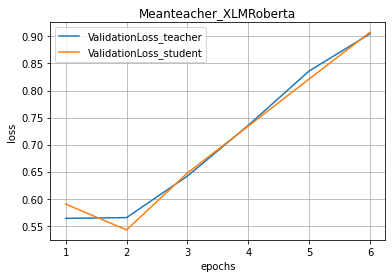

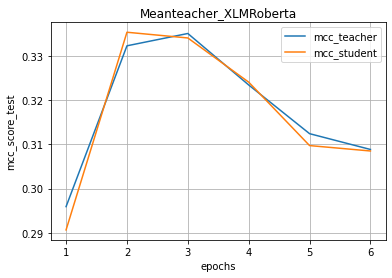

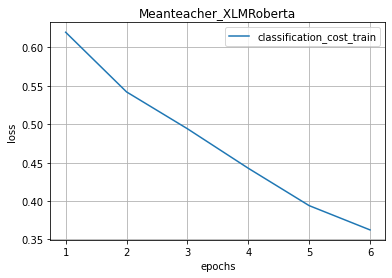

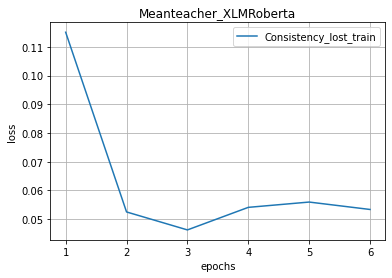

In [43]:
plot_against_epochs(test_cost_teacher,test_cost_student,label1 = 'ValidationLoss_teacher', 
                    label2 = 'ValidationLoss_student', y_label = 'loss', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(mcc_cost_teacher,mcc_cost_student,label1 = 'mcc_teacher', 
                    label2 = 'mcc_student', y_label = 'mcc_score_test', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(classification_cost_lst,None,label1 = 'classification_cost_train', 
                    label2 = None, y_label = 'loss', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(consistency_cost_lst,None,label1 = 'Consistency_lost_train', 
                    label2 = None, y_label = 'loss', title ='Meanteacher_XLMRoberta' )
# Classificataion_lost_train()

<h3> Running with consistency scale of 100 and without dropout , with weighted crloss </h3>

In [ ]:
# consistency scale was 100 for this experiment
metrices = train_MeanTeacher(train_dataloader,val_dataloader,noise_layer=True) # alpha = 0.995 and full data with noise and w/o dropout


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are ini

Current epoch is 1 of 20


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /codebuild/output/src811146734/src/torch/csrc/utils/python_arg_parser.cpp:766.)
  del sys.path[0]
  7%|▋         | 51/738 [00:57<12:58,  1.13s/it]

train loss :  1.7201754641532898
Consistency Cost : 2.5976239252090454
Classification Cost : 0.8427270126342773


 14%|█▎        | 101/738 [01:55<12:17,  1.16s/it]

train loss :  1.4590005815029143
Consistency Cost : 2.1158031582832337
Classification Cost : 0.8021980041265487


 20%|██        | 151/738 [02:54<11:43,  1.20s/it]

train loss :  1.3508134547869364
Consistency Cost : 1.9173649048805237
Classification Cost : 0.7842620050907135


 27%|██▋       | 201/738 [03:51<10:09,  1.13s/it]

train loss :  1.2822944661974907
Consistency Cost : 1.7900150561332702
Classification Cost : 0.774573874771595


 34%|███▍      | 251/738 [04:48<09:12,  1.13s/it]

train loss :  1.2283503510951996
Consistency Cost : 1.6893873381614686
Classification Cost : 0.7673133628368378


 41%|████      | 301/738 [05:44<08:13,  1.13s/it]

train loss :  1.1852825375398
Consistency Cost : 1.608170846303304
Classification Cost : 0.7623942277828852


 48%|████▊     | 351/738 [06:41<07:18,  1.13s/it]

train loss :  1.149304621900831
Consistency Cost : 1.5400885265214102
Classification Cost : 0.7585207167693547


 54%|█████▍    | 401/738 [07:38<06:24,  1.14s/it]

train loss :  1.128152151107788
Consistency Cost : 1.4993022939562797
Classification Cost : 0.7570020090043544


 61%|██████    | 451/738 [08:35<05:25,  1.13s/it]

train loss :  1.0983350853125253
Consistency Cost : 1.4405961967839136
Classification Cost : 0.756073974635866


 68%|██████▊   | 501/738 [09:31<04:28,  1.13s/it]

train loss :  1.068100014925003
Consistency Cost : 1.3815332715511321
Classification Cost : 0.7546667588949203


 75%|███████▍  | 551/738 [10:28<03:33,  1.14s/it]

train loss :  1.0403040570562536
Consistency Cost : 1.327253408432007
Classification Cost : 0.753354706547477


 81%|████████▏ | 601/738 [11:25<02:34,  1.13s/it]

train loss :  1.014814266661803
Consistency Cost : 1.2775765783588091
Classification Cost : 0.7520519558588664


 88%|████████▊ | 651/738 [12:21<01:38,  1.13s/it]

train loss :  0.9909196471250974
Consistency Cost : 1.2309557480995472
Classification Cost : 0.7508835475261395


 95%|█████████▍| 701/738 [13:18<00:41,  1.13s/it]

train loss :  0.968386589714459
Consistency Cost : 1.1870393054825918
Classification Cost : 0.749733875308718


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:41<00:00,  4.78it/s]


Overall validation loss: tensor(0.7083, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.22471007780291255
Average F1 Validation score for whole sentence class 1 : 0.001566683903602861
Average Accuracy Validation score whole sentence  : 0.12717466711424416
Average mcc Validation score whole sentence : 0.008530118271233001


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.13      1.00      0.22     28264
           1       0.98      0.00      0.00    195161

    accuracy                           0.13    223425
   macro avg       0.55      0.50      0.11    223425
weighted avg       0.87      0.13      0.03    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:42<00:00,  4.76it/s]
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall validation loss: tensor(0.7178, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2245946386214733
Average F1 Validation score for whole sentence class 1 : 0.0
Average Accuracy Validation score whole sentence  : 0.12650330088396552
Average mcc Validation score whole sentence : 0.0


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 0/738 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.13      1.00      0.22     28264
           1       0.00      0.00      0.00    195161

    accuracy                           0.13    223425
   macro avg       0.06      0.50      0.11    223425
weighted avg       0.02      0.13      0.03    223425

Current epoch is 2 of 20


  7%|▋         | 51/738 [00:58<13:13,  1.15s/it]

train loss :  0.6438334846496582
Consistency Cost : 0.5494475793838501
Classification Cost : 0.7382193911075592


 14%|█▎        | 101/738 [01:56<12:31,  1.18s/it]

train loss :  0.6292306369543076
Consistency Cost : 0.5235410407185555
Classification Cost : 0.7349202346801758


 20%|██        | 151/738 [02:55<11:14,  1.15s/it]

train loss :  0.6172074528535207
Consistency Cost : 0.5000649899244308
Classification Cost : 0.73434991757075


 27%|██▋       | 201/738 [03:52<10:08,  1.13s/it]

train loss :  0.6056576499342918
Consistency Cost : 0.48022027030587194
Classification Cost : 0.731095030605793


 34%|███▍      | 251/738 [04:49<09:13,  1.14s/it]

train loss :  0.5953948395252228
Consistency Cost : 0.4623376272916794
Classification Cost : 0.7284520525932312


 41%|████      | 301/738 [05:45<08:13,  1.13s/it]

train loss :  0.5862326149145762
Consistency Cost : 0.44509138057629266
Classification Cost : 0.7273738521337509


 48%|████▊     | 351/738 [06:42<07:17,  1.13s/it]

train loss :  0.5778840448175158
Consistency Cost : 0.4293175577265876
Classification Cost : 0.7264505353995732


 54%|█████▍    | 401/738 [07:38<06:20,  1.13s/it]

train loss :  0.5691647782921792
Consistency Cost : 0.4137470784038305
Classification Cost : 0.7245824797451497


 61%|██████    | 451/738 [08:35<05:24,  1.13s/it]

train loss :  0.5611435976955625
Consistency Cost : 0.39952150566710365
Classification Cost : 0.7227656914128198


 68%|██████▊   | 501/738 [09:31<04:27,  1.13s/it]

train loss :  0.5534641194343567
Consistency Cost : 0.38594864869117734
Classification Cost : 0.7209795919656754


 75%|███████▍  | 551/738 [10:28<03:31,  1.13s/it]

train loss :  0.5458472401445562
Consistency Cost : 0.372673932205547
Classification Cost : 0.7190205496007746


 81%|████████▏ | 601/738 [11:24<02:35,  1.13s/it]

train loss :  0.5385849432150522
Consistency Cost : 0.35996216381589574
Classification Cost : 0.7172077236572901


 88%|████████▊ | 651/738 [12:21<01:39,  1.15s/it]

train loss :  0.5317095742317346
Consistency Cost : 0.3479321764753415
Classification Cost : 0.7154869728821974


 95%|█████████▍| 701/738 [13:18<00:41,  1.13s/it]

train loss :  0.525693967129503
Consistency Cost : 0.3372115337210042
Classification Cost : 0.7141764013256345


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:41<00:00,  4.77it/s]


Overall validation loss: tensor(0.6711, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.27851927516820496
Average F1 Validation score for whole sentence class 1 : 0.457048056445635
Average Accuracy Validation score whole sentence  : 0.3803871545261273
Average mcc Validation score whole sentence : 0.1831658696821336


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.16      0.95      0.28     28264
           1       0.97      0.30      0.46    195161

    accuracy                           0.38    223425
   macro avg       0.57      0.62      0.37    223425
weighted avg       0.87      0.38      0.43    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:42<00:00,  4.75it/s]


Overall validation loss: tensor(0.6897, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.27512564748884705
Average F1 Validation score for whole sentence class 1 : 0.4398176617379264
Average Accuracy Validation score whole sentence  : 0.36802506433926374
Average mcc Validation score whole sentence : 0.17707853463355724


  0%|          | 0/738 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.16      0.95      0.28     28264
           1       0.97      0.28      0.44    195161

    accuracy                           0.37    223425
   macro avg       0.57      0.62      0.36    223425
weighted avg       0.87      0.37      0.42    223425

Current epoch is 3 of 20


  7%|▋         | 51/738 [00:57<12:54,  1.13s/it]

train loss :  0.43344288766384126
Consistency Cost : 0.1682971516251564
Classification Cost : 0.6985886287689209


 14%|█▎        | 101/738 [01:53<11:57,  1.13s/it]

train loss :  0.42558755159378053
Consistency Cost : 0.16038661405444146
Classification Cost : 0.6907884919643402


 20%|██        | 151/738 [02:50<10:59,  1.12s/it]

train loss :  0.4231722148259481
Consistency Cost : 0.15401719292004903
Classification Cost : 0.6923272399107615


 27%|██▋       | 201/738 [03:46<10:07,  1.13s/it]

train loss :  0.41917459547519687
Consistency Cost : 0.14837881110608578
Classification Cost : 0.6899703812599182


 34%|███▍      | 251/738 [04:43<09:14,  1.14s/it]

train loss :  0.41432194697856906
Consistency Cost : 0.14265317353606224
Classification Cost : 0.6859907217025757


 41%|████      | 301/738 [05:40<08:24,  1.16s/it]

train loss :  0.41064151893059414
Consistency Cost : 0.13780556914707026
Classification Cost : 0.6834774700800578


 48%|████▊     | 351/738 [06:39<07:38,  1.18s/it]

train loss :  0.4071470543316432
Consistency Cost : 0.1331383844784328
Classification Cost : 0.6811557252066476


 54%|█████▍    | 401/738 [07:37<06:25,  1.14s/it]

train loss :  0.4040017908066511
Consistency Cost : 0.12907050751149654
Classification Cost : 0.6789330750703811


 61%|██████    | 451/738 [08:34<05:24,  1.13s/it]

train loss :  0.40084844801161024
Consistency Cost : 0.12507373066412078
Classification Cost : 0.6766231660048166


 68%|██████▊   | 501/738 [09:31<04:27,  1.13s/it]

train loss :  0.3982208079099655
Consistency Cost : 0.12131987297534942
Classification Cost : 0.6751217433214187


 75%|███████▍  | 551/738 [10:27<03:31,  1.13s/it]

train loss :  0.3956630048426715
Consistency Cost : 0.11774588874795221
Classification Cost : 0.6735801211270419


 81%|████████▏ | 601/738 [11:24<02:36,  1.14s/it]

train loss :  0.392954820394516
Consistency Cost : 0.11417175197352966
Classification Cost : 0.6717378888527552


 88%|████████▊ | 651/738 [12:21<01:38,  1.14s/it]

train loss :  0.3903635533956381
Consistency Cost : 0.11089002264233735
Classification Cost : 0.6698370841833261


 95%|█████████▍| 701/738 [13:18<00:41,  1.13s/it]

train loss :  0.3878493439725467
Consistency Cost : 0.10779068119823933
Classification Cost : 0.6679080066510609


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:41<00:00,  4.78it/s]


Overall validation loss: tensor(0.6336, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.29644175897952335
Average F1 Validation score for whole sentence class 1 : 0.5309611726530156
Average Accuracy Validation score whole sentence  : 0.43715340718361867
Average mcc Validation score whole sentence : 0.21411945920708314


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.18      0.94      0.30     28264
           1       0.98      0.36      0.53    195161

    accuracy                           0.44    223425
   macro avg       0.58      0.65      0.41    223425
weighted avg       0.87      0.44      0.50    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:41<00:00,  4.77it/s]


Overall validation loss: tensor(0.6476, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2854753903297905
Average F1 Validation score for whole sentence class 1 : 0.48781106282921655
Average Accuracy Validation score whole sentence  : 0.40332997650218194
Average mcc Validation score whole sentence : 0.19568359501830945


  0%|          | 0/738 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.17      0.94      0.29     28264
           1       0.97      0.33      0.49    195161

    accuracy                           0.40    223425
   macro avg       0.57      0.63      0.39    223425
weighted avg       0.87      0.40      0.46    223425

Current epoch is 4 of 20


  7%|▋         | 51/738 [00:57<12:55,  1.13s/it]

train loss :  0.35822623550891874
Consistency Cost : 0.06184069313108921
Classification Cost : 0.6546117794513703


 14%|█▎        | 101/738 [01:53<11:57,  1.13s/it]

train loss :  0.3526439940929413
Consistency Cost : 0.060385487861931327
Classification Cost : 0.6449025005102158


 20%|██        | 151/738 [02:50<11:04,  1.13s/it]

train loss :  0.3511071004470189
Consistency Cost : 0.059415130515893304
Classification Cost : 0.6427990698814392


 27%|██▋       | 201/738 [03:46<10:09,  1.13s/it]

train loss :  0.34921692207455635
Consistency Cost : 0.05830912796780467
Classification Cost : 0.6401247167587281


 34%|███▍      | 251/738 [04:44<09:21,  1.15s/it]

train loss :  0.34747374045848844
Consistency Cost : 0.056940059870481494
Classification Cost : 0.6380074217319488


 41%|████      | 301/738 [05:42<08:32,  1.17s/it]

train loss :  0.34692431330680845
Consistency Cost : 0.055623353806634745
Classification Cost : 0.6382252736886342


 48%|████▊     | 351/738 [06:42<07:37,  1.18s/it]

train loss :  0.34568589568138125
Consistency Cost : 0.05484628341027668
Classification Cost : 0.6365255083356585


 54%|█████▍    | 401/738 [07:39<06:22,  1.14s/it]

train loss :  0.3440210253745317
Consistency Cost : 0.05390240407548845
Classification Cost : 0.6341396468877792


 61%|██████    | 451/738 [08:36<05:25,  1.13s/it]

train loss :  0.3429846112595664
Consistency Cost : 0.053141478507055175
Classification Cost : 0.6328277439541287


 68%|██████▊   | 501/738 [09:32<04:30,  1.14s/it]

train loss :  0.3420789969563484
Consistency Cost : 0.052638882540166375
Classification Cost : 0.631519111275673


 75%|███████▍  | 551/738 [10:30<03:37,  1.16s/it]

train loss :  0.3409443317760121
Consistency Cost : 0.05197588518261909
Classification Cost : 0.6299127782474865


 81%|████████▏ | 601/738 [11:29<02:43,  1.19s/it]

train loss :  0.3407899127403895
Consistency Cost : 0.051766611188650134
Classification Cost : 0.6298132139444351


 88%|████████▊ | 651/738 [12:26<01:38,  1.14s/it]

train loss :  0.3400246372131201
Consistency Cost : 0.051322906321057904
Classification Cost : 0.6287263677670405


 95%|█████████▍| 701/738 [13:23<00:41,  1.13s/it]

train loss :  0.33957388064690996
Consistency Cost : 0.051269316556198256
Classification Cost : 0.6278784441947937


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:42<00:00,  4.73it/s]


Overall validation loss: tensor(0.6012, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.32055859414564974
Average F1 Validation score for whole sentence class 1 : 0.6284642172236414
Average Accuracy Validation score whole sentence  : 0.5196150833613069
Average mcc Validation score whole sentence : 0.24313669668899798


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.20      0.90      0.32     28264
           1       0.97      0.47      0.63    195161

    accuracy                           0.52    223425
   macro avg       0.58      0.68      0.47    223425
weighted avg       0.87      0.52      0.59    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:42<00:00,  4.68it/s]


Overall validation loss: tensor(0.6095, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3115448018501633
Average F1 Validation score for whole sentence class 1 : 0.5946103547466071
Average Accuracy Validation score whole sentence  : 0.48970347991496027
Average mcc Validation score whole sentence : 0.23302800684461666


  0%|          | 0/738 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.19      0.91      0.31     28264
           1       0.97      0.43      0.59    195161

    accuracy                           0.49    223425
   macro avg       0.58      0.67      0.45    223425
weighted avg       0.87      0.49      0.56    223425

Current epoch is 5 of 20


  7%|▋         | 51/738 [01:00<13:41,  1.20s/it]

train loss :  0.33658331632614136
Consistency Cost : 0.051197056174278256
Classification Cost : 0.6219695734977723


 14%|█▎        | 101/738 [01:57<12:02,  1.13s/it]

train loss :  0.33082076579332353
Consistency Cost : 0.04971724385395646
Classification Cost : 0.6119242861866951


 20%|██        | 151/738 [02:54<11:04,  1.13s/it]

train loss :  0.3264696935812632
Consistency Cost : 0.04928208963324626
Classification Cost : 0.6036572964986165


 27%|██▋       | 201/738 [03:51<10:13,  1.14s/it]

train loss :  0.3247296521067619
Consistency Cost : 0.04799769305624068
Classification Cost : 0.6014616096019745


 34%|███▍      | 251/738 [04:48<09:25,  1.16s/it]

train loss :  0.32240090882778166
Consistency Cost : 0.046858002595603465
Classification Cost : 0.5979438141584397


 41%|████      | 301/738 [05:47<08:41,  1.19s/it]

train loss :  0.32172363708416624
Consistency Cost : 0.04633185827483734
Classification Cost : 0.5971154154340426


 48%|████▊     | 351/738 [06:45<07:24,  1.15s/it]

train loss :  0.32070596507617405
Consistency Cost : 0.046007780720080646
Classification Cost : 0.5954041492087501


 54%|█████▍    | 401/738 [07:42<06:22,  1.14s/it]

train loss :  0.32032593809068205
Consistency Cost : 0.046134721883572635
Classification Cost : 0.594517153725028


 61%|██████    | 451/738 [08:39<05:27,  1.14s/it]

train loss :  0.31939052601655327
Consistency Cost : 0.04592623997479677
Classification Cost : 0.5928548110193677


 68%|██████▊   | 501/738 [09:36<04:33,  1.16s/it]

train loss :  0.31913979464769365
Consistency Cost : 0.04606308649480343
Classification Cost : 0.5922165015339851


 75%|███████▍  | 551/738 [10:35<03:41,  1.18s/it]

train loss :  0.3187979825518348
Consistency Cost : 0.046066978607665406
Classification Cost : 0.5915289851210334


 81%|████████▏ | 601/738 [11:34<02:37,  1.15s/it]

train loss :  0.3185874469826619
Consistency Cost : 0.04591866581390301
Classification Cost : 0.5912562268972397


 88%|████████▊ | 651/738 [12:31<01:38,  1.13s/it]

train loss :  0.31858607757550017
Consistency Cost : 0.04707364037632942
Classification Cost : 0.5900985133647919


 95%|█████████▍| 701/738 [13:27<00:42,  1.14s/it]

train loss :  0.31867107427545954
Consistency Cost : 0.04836496789008379
Classification Cost : 0.588977179484708


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:42<00:00,  4.69it/s]


Overall validation loss: tensor(0.5778, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3577311868214152
Average F1 Validation score for whole sentence class 1 : 0.7415783230082663
Average Accuracy Validation score whole sentence  : 0.6314467942262504
Average mcc Validation score whole sentence : 0.27861390813077336


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.23      0.81      0.36     28264
           1       0.96      0.61      0.74    195161

    accuracy                           0.63    223425
   macro avg       0.59      0.71      0.55    223425
weighted avg       0.86      0.63      0.69    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:42<00:00,  4.76it/s]


Overall validation loss: tensor(0.5807, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3510719582902603
Average F1 Validation score for whole sentence class 1 : 0.7235476582545094
Average Accuracy Validation score whole sentence  : 0.6122725746894931
Average mcc Validation score whole sentence : 0.27300776390667825


  0%|          | 0/738 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.22      0.83      0.35     28264
           1       0.96      0.58      0.72    195161

    accuracy                           0.61    223425
   macro avg       0.59      0.70      0.54    223425
weighted avg       0.87      0.61      0.68    223425

Current epoch is 6 of 20


  7%|▋         | 51/738 [00:57<12:53,  1.13s/it]

train loss :  0.3150112360715866
Consistency Cost : 0.051914439052343365
Classification Cost : 0.5781080353260041


 14%|█▎        | 101/738 [01:53<11:58,  1.13s/it]

train loss :  0.3139496904611587
Consistency Cost : 0.04993040135130286
Classification Cost : 0.5779689821600914


 20%|██        | 151/738 [02:50<11:01,  1.13s/it]

train loss :  0.3116914709409078
Consistency Cost : 0.049188609855870404
Classification Cost : 0.5741943337519964


 27%|██▋       | 201/738 [03:46<10:05,  1.13s/it]

train loss :  0.3099858009815216
Consistency Cost : 0.04826548616401851
Classification Cost : 0.5717061172425747


 34%|███▍      | 251/738 [04:43<09:11,  1.13s/it]

train loss :  0.30931364178657533
Consistency Cost : 0.04815301533788443
Classification Cost : 0.5704742686748505


 41%|████      | 301/738 [05:39<08:14,  1.13s/it]

train loss :  0.3081478449702263
Consistency Cost : 0.048859368270883954
Classification Cost : 0.5674363222718238


 48%|████▊     | 351/738 [06:36<07:17,  1.13s/it]

train loss :  0.3070170059800148
Consistency Cost : 0.049501913503876754
Classification Cost : 0.5645320985998427


 54%|█████▍    | 401/738 [07:32<06:22,  1.14s/it]

train loss :  0.3063636145368218
Consistency Cost : 0.049884671424515546
Classification Cost : 0.5628425579518079


 61%|██████    | 451/738 [08:29<05:28,  1.15s/it]

train loss :  0.30561843431658214
Consistency Cost : 0.05020215046902498
Classification Cost : 0.5610347184869978


 68%|██████▊   | 501/738 [09:27<04:36,  1.17s/it]

train loss :  0.3056847990453243
Consistency Cost : 0.05073183031380177
Classification Cost : 0.5606377682089806


 75%|███████▍  | 551/738 [10:26<03:42,  1.19s/it]

train loss :  0.3056757951324636
Consistency Cost : 0.05073460285297849
Classification Cost : 0.5606169876185331


 81%|████████▏ | 601/738 [11:24<02:35,  1.13s/it]

train loss :  0.30615568357209366
Consistency Cost : 0.051171000444640714
Classification Cost : 0.5611403668423494


 88%|████████▊ | 651/738 [12:20<01:38,  1.14s/it]

train loss :  0.305607983813836
Consistency Cost : 0.05138707744100919
Classification Cost : 0.559828890470358


 95%|█████████▍| 701/738 [13:17<00:42,  1.15s/it]

train loss :  0.3063039725806032
Consistency Cost : 0.051908125448971984
Classification Cost : 0.5606998200927462


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:42<00:00,  4.76it/s]


Overall validation loss: tensor(0.5701, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3955979641106571
Average F1 Validation score for whole sentence class 1 : 0.835317669370983
Average Accuracy Validation score whole sentence  : 0.741161463578382
Average mcc Validation score whole sentence : 0.30498334282112854


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.28      0.67      0.40     28264
           1       0.94      0.75      0.84    195161

    accuracy                           0.74    223425
   macro avg       0.61      0.71      0.62    223425
weighted avg       0.86      0.74      0.78    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:41<00:00,  4.78it/s]


Overall validation loss: tensor(0.5705, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.38795171247689825
Average F1 Validation score for whole sentence class 1 : 0.8196021163285292
Average Accuracy Validation score whole sentence  : 0.7213382566856887
Average mcc Validation score whole sentence : 0.29919871609536275


  0%|          | 0/738 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.27      0.70      0.39     28264
           1       0.94      0.72      0.82    195161

    accuracy                           0.72    223425
   macro avg       0.61      0.71      0.60    223425
weighted avg       0.86      0.72      0.76    223425

Current epoch is 7 of 20


  7%|▋         | 51/738 [00:57<12:56,  1.13s/it]

train loss :  0.3067619127035141
Consistency Cost : 0.05317442752420902
Classification Cost : 0.5603493940830231


 14%|█▎        | 101/738 [01:54<12:03,  1.14s/it]

train loss :  0.30871156230568886
Consistency Cost : 0.0640886521153152
Classification Cost : 0.5533344694972038


 20%|██        | 151/738 [02:51<11:09,  1.14s/it]

train loss :  0.30608565141757327
Consistency Cost : 0.06407343704253435
Classification Cost : 0.5480978639920553


 27%|██▋       | 201/738 [03:48<10:21,  1.16s/it]

train loss :  0.30475768029689787
Consistency Cost : 0.06322899769060314
Classification Cost : 0.5462863618135452


 34%|███▍      | 251/738 [04:47<09:42,  1.20s/it]

train loss :  0.3053248593211174
Consistency Cost : 0.06361338375508785
Classification Cost : 0.547036334514618


 41%|████      | 301/738 [05:45<08:17,  1.14s/it]

train loss :  0.30510840942462286
Consistency Cost : 0.06380124237388372
Classification Cost : 0.5464155760407448


 48%|████▊     | 351/738 [06:42<07:19,  1.13s/it]

train loss :  0.30407759423766817
Consistency Cost : 0.06439494390572821
Classification Cost : 0.5437602447611946


 54%|█████▍    | 401/738 [07:39<06:25,  1.14s/it]

train loss :  0.3042456578463316
Consistency Cost : 0.06410869042389095
Classification Cost : 0.5443826254457236


 61%|██████    | 451/738 [08:36<05:31,  1.15s/it]

train loss :  0.3045073304242558
Consistency Cost : 0.06430000703367922
Classification Cost : 0.5447146539555655


 68%|██████▊   | 501/738 [09:35<04:40,  1.18s/it]

train loss :  0.3039739948511124
Consistency Cost : 0.06386202825978399
Classification Cost : 0.5440859612822533


 75%|███████▍  | 551/738 [10:33<03:33,  1.14s/it]

train loss :  0.30505241681228984
Consistency Cost : 0.0646653130244125
Classification Cost : 0.5454395199905743


 81%|████████▏ | 601/738 [11:30<02:35,  1.13s/it]

train loss :  0.30623152082165084
Consistency Cost : 0.06555815723414223
Classification Cost : 0.5469048840304216


 88%|████████▊ | 651/738 [12:27<01:39,  1.14s/it]

train loss :  0.3067620047009908
Consistency Cost : 0.06687635223452862
Classification Cost : 0.5466476565140944


 95%|█████████▍| 701/738 [13:24<00:42,  1.15s/it]

train loss :  0.30779744925243513
Consistency Cost : 0.06823084989296538
Classification Cost : 0.5473640479360308


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:44<00:00,  4.54it/s]


Overall validation loss: tensor(0.5892, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.4044246551964876
Average F1 Validation score for whole sentence class 1 : 0.8996085179383514
Average Accuracy Validation score whole sentence  : 0.8281794785722278
Average mcc Validation score whole sentence : 0.30899656854194174


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.36      0.46      0.40     28264
           1       0.92      0.88      0.90    195161

    accuracy                           0.83    223425
   macro avg       0.64      0.67      0.65    223425
weighted avg       0.85      0.83      0.84    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:43<00:00,  4.65it/s]


Overall validation loss: tensor(0.5823, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.41197173416921007
Average F1 Validation score for whole sentence class 1 : 0.8856706013172526
Average Accuracy Validation score whole sentence  : 0.8085621573234866
Average mcc Validation score whole sentence : 0.3155221860409386


  0%|          | 0/738 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.34      0.53      0.41     28264
           1       0.93      0.85      0.89    195161

    accuracy                           0.81    223425
   macro avg       0.63      0.69      0.65    223425
weighted avg       0.85      0.81      0.83    223425

Current epoch is 8 of 20


  7%|▋         | 51/738 [00:57<13:01,  1.14s/it]

train loss :  0.30134589582681653
Consistency Cost : 0.06171703524887562
Classification Cost : 0.5409747588634491


 14%|█▎        | 101/738 [01:54<12:06,  1.14s/it]

train loss :  0.30338732033967974
Consistency Cost : 0.06963221648707986
Classification Cost : 0.5371424248814582


 20%|██        | 151/738 [02:51<11:17,  1.15s/it]

train loss :  0.303541271785895
Consistency Cost : 0.07154466328521569
Classification Cost : 0.535537881453832


 27%|██▋       | 201/738 [03:50<10:31,  1.18s/it]

train loss :  0.3056674494594336
Consistency Cost : 0.07128051238134503
Classification Cost : 0.5400543892383576


 34%|███▍      | 251/738 [04:49<09:19,  1.15s/it]

train loss :  0.3046456623673439
Consistency Cost : 0.0702932641133666
Classification Cost : 0.5389980628490448


 41%|████      | 301/738 [05:46<08:14,  1.13s/it]

train loss :  0.3044901255269845
Consistency Cost : 0.06969578019653758
Classification Cost : 0.5392844724655151


 48%|████▊     | 351/738 [06:42<07:19,  1.14s/it]

train loss :  0.3049998269336564
Consistency Cost : 0.07053087854491813
Classification Cost : 0.5394687767539705


 54%|█████▍    | 401/738 [07:39<06:29,  1.16s/it]

train loss :  0.3051130490750074
Consistency Cost : 0.07167455099057406
Classification Cost : 0.5385515480488539


 61%|██████    | 451/738 [08:38<05:36,  1.17s/it]

train loss :  0.3060118500060505
Consistency Cost : 0.0732912366050813
Classification Cost : 0.5387324641810524


 68%|██████▊   | 501/738 [09:37<04:35,  1.16s/it]

train loss :  0.3056392923295498
Consistency Cost : 0.07389569007977843
Classification Cost : 0.5373828951716423


 75%|███████▍  | 551/738 [10:34<03:32,  1.14s/it]

train loss :  0.3051144786856391
Consistency Cost : 0.07536423174833709
Classification Cost : 0.5348647259582173


 81%|████████▏ | 601/738 [11:30<02:34,  1.13s/it]

train loss :  0.3055443312476079
Consistency Cost : 0.07709709756386776
Classification Cost : 0.5339915650089582


 88%|████████▊ | 651/738 [12:27<01:38,  1.13s/it]

train loss :  0.3060441854596138
Consistency Cost : 0.07758393614337994
Classification Cost : 0.5345044344892869


 95%|█████████▍| 701/738 [13:24<00:42,  1.14s/it]

train loss :  0.30668552869132587
Consistency Cost : 0.07886389762429255
Classification Cost : 0.5345071598248823


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:41<00:00,  4.78it/s]


Overall validation loss: tensor(0.6241, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.36686895321558055
Average F1 Validation score for whole sentence class 1 : 0.9173862115550518
Average Accuracy Validation score whole sentence  : 0.8538435716683451
Average mcc Validation score whole sentence : 0.2868043580093442


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.41      0.33      0.37     28264
           1       0.91      0.93      0.92    195161

    accuracy                           0.85    223425
   macro avg       0.66      0.63      0.64    223425
weighted avg       0.84      0.85      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:41<00:00,  4.79it/s]


Overall validation loss: tensor(0.6110, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.38450118220641877
Average F1 Validation score for whole sentence class 1 : 0.9143977302563658
Average Accuracy Validation score whole sentence  : 0.8496990041400918
Average mcc Validation score whole sentence : 0.29927878105502287


  0%|          | 0/738 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.40      0.37      0.38     28264
           1       0.91      0.92      0.91    195161

    accuracy                           0.85    223425
   macro avg       0.65      0.65      0.65    223425
weighted avg       0.85      0.85      0.85    223425

Current epoch is 9 of 20


  7%|▋         | 51/738 [00:57<12:58,  1.13s/it]

train loss :  0.31010514110326765
Consistency Cost : 0.08361046232283115
Classification Cost : 0.5365998229384422


 14%|█▎        | 101/738 [01:54<12:09,  1.14s/it]

train loss :  0.3424517644941807
Consistency Cost : 0.14441165555268526
Classification Cost : 0.5404918746650219


 20%|██        | 151/738 [02:52<11:26,  1.17s/it]

train loss :  0.36609101663033167
Consistency Cost : 0.18803018353879453
Classification Cost : 0.5441518488526345


 27%|██▋       | 201/738 [03:51<10:44,  1.20s/it]

train loss :  0.3542247312515974
Consistency Cost : 0.16632189044728876
Classification Cost : 0.5421275714784861


 34%|███▍      | 251/738 [04:49<09:13,  1.14s/it]

train loss :  0.3473460730910301
Consistency Cost : 0.15380772400647402
Classification Cost : 0.5408844214081764


 41%|████      | 301/738 [05:45<08:14,  1.13s/it]

train loss :  0.34347583174705504
Consistency Cost : 0.14899752665931978
Classification Cost : 0.5379541367789109


 48%|████▊     | 351/738 [06:42<07:18,  1.13s/it]

train loss :  0.34085131266287394
Consistency Cost : 0.1419867737750922
Classification Cost : 0.5397158511621611


 54%|█████▍    | 401/738 [07:39<06:25,  1.15s/it]

train loss :  0.3389780483022332
Consistency Cost : 0.1365304114157334
Classification Cost : 0.5414256844297052


 61%|██████    | 451/738 [08:36<05:32,  1.16s/it]

train loss :  0.33750689930386013
Consistency Cost : 0.13303855036281878
Classification Cost : 0.5419752473632494


 68%|██████▊   | 501/738 [09:33<04:28,  1.13s/it]

train loss :  0.33746588256955146
Consistency Cost : 0.1317802977822721
Classification Cost : 0.543151466757059


 75%|███████▍  | 551/738 [10:30<03:31,  1.13s/it]

train loss :  0.33881910768422213
Consistency Cost : 0.13052168626676905
Classification Cost : 0.5471165284514428


 81%|████████▏ | 601/738 [11:27<02:36,  1.14s/it]

train loss :  0.33930392811695737
Consistency Cost : 0.12865811969153584
Classification Cost : 0.5499497359246015


 88%|████████▊ | 651/738 [12:24<01:40,  1.16s/it]

train loss :  0.3382676538366538
Consistency Cost : 0.12688136374148037
Classification Cost : 0.5496539433873616


 95%|█████████▍| 701/738 [13:23<00:43,  1.18s/it]

train loss :  0.33708410109792436
Consistency Cost : 0.1256267005045499
Classification Cost : 0.5485415015901838


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:42<00:00,  4.72it/s]


Overall validation loss: tensor(0.6816, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3393962601314698
Average F1 Validation score for whole sentence class 1 : 0.9223370172792821
Average Accuracy Validation score whole sentence  : 0.8610137630077207
Average mcc Validation score whole sentence : 0.2722752543215936


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.43      0.28      0.34     28264
           1       0.90      0.94      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.66      0.61      0.63    223425
weighted avg       0.84      0.86      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:41<00:00,  4.77it/s]


Overall validation loss: tensor(0.6739, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3326123631959164
Average F1 Validation score for whole sentence class 1 : 0.9229786129360785
Average Accuracy Validation score whole sentence  : 0.8618954906568199
Average mcc Validation score whole sentence : 0.26812882273772326


  0%|          | 0/738 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.43      0.27      0.33     28264
           1       0.90      0.95      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.66      0.61      0.63    223425
weighted avg       0.84      0.86      0.85    223425

Current epoch is 10 of 20


  7%|▋         | 51/738 [00:57<12:57,  1.13s/it]

train loss :  0.33233589470386504
Consistency Cost : 0.10125538639724255
Classification Cost : 0.5634163999557495


 14%|█▎        | 101/738 [01:54<12:05,  1.14s/it]

train loss :  0.3282711148262024
Consistency Cost : 0.09845434635877609
Classification Cost : 0.5580878818035125


 20%|██        | 151/738 [02:51<11:20,  1.16s/it]

train loss :  0.32815005267659825
Consistency Cost : 0.09990896889319023
Classification Cost : 0.5563911349574725


 27%|██▋       | 201/738 [03:49<10:09,  1.14s/it]

train loss :  0.32615217346698044
Consistency Cost : 0.10179179864935577
Classification Cost : 0.550512547492981


 34%|███▍      | 251/738 [04:46<09:10,  1.13s/it]

train loss :  0.32671459209918974
Consistency Cost : 0.10431825076788664
Classification Cost : 0.5491109330654145


 41%|████      | 301/738 [05:42<08:17,  1.14s/it]

train loss :  0.3280520690232515
Consistency Cost : 0.10631498070433736
Classification Cost : 0.5497891570130984


 48%|████▊     | 351/738 [06:39<07:25,  1.15s/it]

train loss :  0.32997190064617565
Consistency Cost : 0.10779709068260022
Classification Cost : 0.5521467111791883


 54%|█████▍    | 401/738 [07:38<06:36,  1.18s/it]

train loss :  0.33084713915362957
Consistency Cost : 0.10803610973525793
Classification Cost : 0.5536581688374281


 61%|██████    | 451/738 [08:37<05:31,  1.16s/it]

train loss :  0.3331568673087491
Consistency Cost : 0.10946507930548655
Classification Cost : 0.5568486556079653


 68%|██████▊   | 501/738 [09:34<04:28,  1.13s/it]

train loss :  0.33447920198738573
Consistency Cost : 0.10880565846152604
Classification Cost : 0.5601527456641198


 75%|███████▍  | 551/738 [10:31<03:32,  1.14s/it]

train loss :  0.33495669173923404
Consistency Cost : 0.1090055038661442
Classification Cost : 0.5609078795530579


 81%|████████▏ | 601/738 [11:28<02:37,  1.15s/it]

train loss :  0.33885500171532235
Consistency Cost : 0.11043266197821747
Classification Cost : 0.5672773414105177


 88%|████████▊ | 651/738 [12:26<01:42,  1.18s/it]

train loss :  0.34138547268051367
Consistency Cost : 0.11078842928346533
Classification Cost : 0.5719825159815641


 95%|█████████▍| 701/738 [13:25<00:43,  1.17s/it]

train loss :  0.3421559926335301
Consistency Cost : 0.11193134615064732
Classification Cost : 0.5723806390379156


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:41<00:00,  4.76it/s]


Overall validation loss: tensor(0.7310, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.33047703755125063
Average F1 Validation score for whole sentence class 1 : 0.9229874760762864
Average Accuracy Validation score whole sentence  : 0.8618641602327403
Average mcc Validation score whole sentence : 0.2663510001224615


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.43      0.27      0.33     28264
           1       0.90      0.95      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.66      0.61      0.63    223425
weighted avg       0.84      0.86      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:42<00:00,  4.76it/s]


Overall validation loss: tensor(0.7607, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.29948068279732654
Average F1 Validation score for whole sentence class 1 : 0.9255253039669825
Average Accuracy Validation score whole sentence  : 0.8653642161799262
Average mcc Validation score whole sentence : 0.24855320588904115


  0%|          | 0/738 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.44      0.23      0.30     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.67      0.59      0.61    223425
weighted avg       0.84      0.87      0.85    223425

Current epoch is 11 of 20


  7%|▋         | 51/738 [00:57<12:54,  1.13s/it]

train loss :  0.36033119857311247
Consistency Cost : 0.1407267601042986
Classification Cost : 0.5799356400966644


 14%|█▎        | 101/738 [01:54<12:02,  1.13s/it]

train loss :  0.35754830673336985
Consistency Cost : 0.1321614783629775
Classification Cost : 0.5829351353645325


 20%|██        | 151/738 [02:50<11:06,  1.14s/it]

train loss :  0.3547522486746311
Consistency Cost : 0.12368514858186246
Classification Cost : 0.5858193507790566


 27%|██▋       | 201/738 [03:47<10:07,  1.13s/it]

train loss :  0.3525621430948377
Consistency Cost : 0.12254077388904988
Classification Cost : 0.5825835142284632


 34%|███▍      | 251/738 [04:43<09:09,  1.13s/it]

train loss :  0.35428142711520194
Consistency Cost : 0.1231414276137948
Classification Cost : 0.5854214292168617


 41%|████      | 301/738 [05:40<08:12,  1.13s/it]

train loss :  0.3728516976783673
Consistency Cost : 0.15680115345244605
Classification Cost : 0.5889022443691889


 48%|████▊     | 351/738 [06:36<07:20,  1.14s/it]

train loss :  0.37537955107433457
Consistency Cost : 0.15822053574557815
Classification Cost : 0.5925385680368969


 54%|█████▍    | 401/738 [07:33<06:27,  1.15s/it]

train loss :  0.37501375026069583
Consistency Cost : 0.156117610251531
Classification Cost : 0.5939098916947841


 61%|██████    | 451/738 [08:30<05:24,  1.13s/it]

train loss :  0.37435340055988897
Consistency Cost : 0.15273339841100905
Classification Cost : 0.5959734039174186


 68%|██████▊   | 501/738 [09:27<04:28,  1.13s/it]

train loss :  0.3760071527287364
Consistency Cost : 0.1554754106029868
Classification Cost : 0.5965388958454132


 75%|███████▍  | 551/738 [10:23<03:32,  1.14s/it]

train loss :  0.37679704250937157
Consistency Cost : 0.15541495216841048
Classification Cost : 0.5981791338595477


 81%|████████▏ | 601/738 [11:21<02:38,  1.16s/it]

train loss :  0.37646129456038274
Consistency Cost : 0.15453220311552285
Classification Cost : 0.5983903874953588


 88%|████████▊ | 651/738 [12:19<01:43,  1.19s/it]

train loss :  0.37645448020444466
Consistency Cost : 0.1545558963343501
Classification Cost : 0.5983530656420267


 95%|█████████▍| 701/738 [13:18<00:42,  1.14s/it]

train loss :  0.37652408549296007
Consistency Cost : 0.15366384578868747
Classification Cost : 0.5993843266580786


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:41<00:00,  4.78it/s]


Overall validation loss: tensor(0.8840, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2713565414585897
Average F1 Validation score for whole sentence class 1 : 0.9254980895364813
Average Accuracy Validation score whole sentence  : 0.8648181716459662
Average mcc Validation score whole sentence : 0.22600823226788985


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.43      0.20      0.27     28264
           1       0.89      0.96      0.93    195161

    accuracy                           0.86    223425
   macro avg       0.66      0.58      0.60    223425
weighted avg       0.83      0.86      0.84    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:41<00:00,  4.79it/s]


Overall validation loss: tensor(0.8688, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.28331183412163774
Average F1 Validation score for whole sentence class 1 : 0.9259187926555849
Average Accuracy Validation score whole sentence  : 0.8657178023945395
Average mcc Validation score whole sentence : 0.23708961630553851


  0%|          | 0/738 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.44      0.21      0.28     28264
           1       0.89      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.66      0.59      0.60    223425
weighted avg       0.84      0.87      0.84    223425

Current epoch is 12 of 20


  7%|▋         | 51/738 [00:57<12:59,  1.13s/it]

train loss :  0.4215979838371277
Consistency Cost : 0.1516005491092801
Classification Cost : 0.6915954202413559


 14%|█▎        | 101/738 [01:54<12:11,  1.15s/it]

train loss :  0.39533303812146187
Consistency Cost : 0.13800902532413603
Classification Cost : 0.65265704870224


 20%|██        | 151/738 [02:52<11:28,  1.17s/it]

train loss :  0.3947025838494301
Consistency Cost : 0.14479482690493264
Classification Cost : 0.6446103396018347


 27%|██▋       | 201/738 [03:52<10:52,  1.22s/it]

train loss :  0.3938960640737787
Consistency Cost : 0.15116298579610885
Classification Cost : 0.6366291418671608


 34%|███▍      | 251/738 [04:54<10:03,  1.24s/it]

train loss :  0.3909989464767277
Consistency Cost : 0.14979345831274987
Classification Cost : 0.63220443379879


 41%|████      | 301/738 [05:57<09:17,  1.28s/it]

train loss :  0.38772240235470234
Consistency Cost : 0.1513676533475518
Classification Cost : 0.6240771507223447


 48%|████▊     | 351/738 [06:59<08:00,  1.24s/it]

train loss :  0.38929796860952465
Consistency Cost : 0.1520188294244664
Classification Cost : 0.6265771066290992


 54%|█████▍    | 401/738 [07:59<06:26,  1.15s/it]

train loss :  0.3893383109313436
Consistency Cost : 0.15100674556568264
Classification Cost : 0.627669875510037


 61%|██████    | 451/738 [08:56<05:25,  1.13s/it]

train loss :  0.3881379992038839
Consistency Cost : 0.14898762996411985
Classification Cost : 0.6272883677317036


 68%|██████▊   | 501/738 [09:52<04:28,  1.13s/it]

train loss :  0.3887693997565657
Consistency Cost : 0.14991016782820224
Classification Cost : 0.6276286309808493


 75%|███████▍  | 551/738 [10:49<03:32,  1.14s/it]

train loss :  0.3880760784260929
Consistency Cost : 0.15044334243644367
Classification Cost : 0.625708813762123


 81%|████████▏ | 601/738 [11:46<02:37,  1.15s/it]

train loss :  0.3900823671820884
Consistency Cost : 0.15150494555011393
Classification Cost : 0.6286597880348563


 88%|████████▊ | 651/738 [12:44<01:38,  1.14s/it]

train loss :  0.38917165752357014
Consistency Cost : 0.15194170503662183
Classification Cost : 0.6264016093542942


 95%|█████████▍| 701/738 [13:40<00:41,  1.13s/it]

train loss :  0.38873176796760944
Consistency Cost : 0.15117688942700624
Classification Cost : 0.6262866458616086


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:42<00:00,  4.75it/s]


Overall validation loss: tensor(0.8806, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.28719281663516066
Average F1 Validation score for whole sentence class 1 : 0.9254295107902999
Average Accuracy Validation score whole sentence  : 0.8649837753161016
Average mcc Validation score whole sentence : 0.23838868901269458


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.43      0.22      0.29     28264
           1       0.89      0.96      0.93    195161

    accuracy                           0.86    223425
   macro avg       0.66      0.59      0.61    223425
weighted avg       0.84      0.86      0.84    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:42<00:00,  4.71it/s]


Overall validation loss: tensor(0.9250, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.272875142628244
Average F1 Validation score for whole sentence class 1 : 0.926167051636966
Average Accuracy Validation score whole sentence  : 0.8659460669128343
Average mcc Validation score whole sentence : 0.22979486250290382


  0%|          | 0/738 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.43      0.20      0.27     28264
           1       0.89      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.66      0.58      0.60    223425
weighted avg       0.83      0.87      0.84    223425

Current epoch is 13 of 20


  7%|▋         | 51/738 [00:59<13:31,  1.18s/it]

train loss :  0.3933071795105934
Consistency Cost : 0.14995649605989456
Classification Cost : 0.6366578641533852


 14%|█▎        | 101/738 [01:58<12:10,  1.15s/it]

train loss :  0.3829631584882736
Consistency Cost : 0.13930118920281528
Classification Cost : 0.6266251283884049


 20%|██        | 151/738 [02:55<11:05,  1.13s/it]

train loss :  0.38120794671277203
Consistency Cost : 0.14141644219557445
Classification Cost : 0.6209994526207447


 27%|██▋       | 201/738 [03:51<10:11,  1.14s/it]

train loss :  0.3828150610439479
Consistency Cost : 0.14397969683632256
Classification Cost : 0.6216504264250398


 34%|███▍      | 251/738 [04:49<09:21,  1.15s/it]

train loss :  0.3829451753348112
Consistency Cost : 0.15226209154725076
Classification Cost : 0.6136282598078251


 41%|████      | 301/738 [05:47<08:33,  1.18s/it]

train loss :  0.38229162100702524
Consistency Cost : 0.15091695280124745
Classification Cost : 0.6136662909636895


 48%|████▊     | 351/738 [06:46<07:27,  1.16s/it]

train loss :  0.38501179217227866
Consistency Cost : 0.15101755076753243
Classification Cost : 0.6190060346680029


 54%|█████▍    | 401/738 [07:43<06:22,  1.13s/it]

train loss :  0.3845317074563354
Consistency Cost : 0.15163469433318824
Classification Cost : 0.6174287215061486


 61%|██████    | 451/738 [08:40<05:23,  1.13s/it]

train loss :  0.3839778939137856
Consistency Cost : 0.1506033651986056
Classification Cost : 0.6173524235851234


 68%|██████▊   | 501/738 [09:36<04:27,  1.13s/it]

train loss :  0.38241630532592535
Consistency Cost : 0.14744403259828687
Classification Cost : 0.6173885788470507


 75%|███████▍  | 551/738 [10:33<03:31,  1.13s/it]

train loss :  0.38422220923006534
Consistency Cost : 0.1471678211675449
Classification Cost : 0.621276597881859


 81%|████████▏ | 601/738 [11:29<02:35,  1.14s/it]

train loss :  0.3843000143083433
Consistency Cost : 0.14689906002332767
Classification Cost : 0.6217009689907232


 88%|████████▊ | 651/738 [12:26<01:38,  1.13s/it]

train loss :  0.38540228706712903
Consistency Cost : 0.14814937836275652
Classification Cost : 0.6226551958918571


 95%|█████████▍| 701/738 [13:23<00:41,  1.13s/it]

train loss :  0.3856602894887328
Consistency Cost : 0.15040167415248495
Classification Cost : 0.6209189047770841


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:42<00:00,  4.72it/s]


Overall validation loss: tensor(0.9531, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2709872479457733
Average F1 Validation score for whole sentence class 1 : 0.9263275650076263
Average Accuracy Validation score whole sentence  : 0.8661788072059975
Average mcc Validation score whole sentence : 0.22894586814917722


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.44      0.20      0.27     28264
           1       0.89      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.66      0.58      0.60    223425
weighted avg       0.83      0.87      0.84    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:42<00:00,  4.67it/s]


Overall validation loss: tensor(0.9420, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2744366367821662
Average F1 Validation score for whole sentence class 1 : 0.9261699294837024
Average Accuracy Validation score whole sentence  : 0.8659773973369139
Average mcc Validation score whole sentence : 0.23103691788623554


  0%|          | 0/738 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.44      0.20      0.27     28264
           1       0.89      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.66      0.58      0.60    223425
weighted avg       0.83      0.87      0.84    223425

Current epoch is 14 of 20


  7%|▋         | 51/738 [01:00<13:32,  1.18s/it]

train loss :  0.38427950464189053
Consistency Cost : 0.14738791473209858
Classification Cost : 0.6211710943281651


 14%|█▎        | 101/738 [01:57<12:03,  1.14s/it]

train loss :  0.36917212408035993
Consistency Cost : 0.13487848829478025
Classification Cost : 0.6034657580405474


 20%|██        | 151/738 [02:54<11:05,  1.13s/it]

train loss :  0.37259502994517485
Consistency Cost : 0.13669951019187768
Classification Cost : 0.6084905482828618


 27%|██▋       | 201/738 [03:51<10:14,  1.14s/it]

train loss :  0.37353832175955176
Consistency Cost : 0.14464135475456716
Classification Cost : 0.6024352864921093


 34%|███▍      | 251/738 [04:48<09:25,  1.16s/it]

train loss :  0.3808957653492689
Consistency Cost : 0.14403081702440976
Classification Cost : 0.6177607119083405


 41%|████      | 301/738 [05:47<08:41,  1.19s/it]

train loss :  0.37991903726011517
Consistency Cost : 0.1459331032882134
Classification Cost : 0.6139049691955248


 48%|████▊     | 351/738 [06:45<07:20,  1.14s/it]

train loss :  0.376435766890645
Consistency Cost : 0.14485232876347645
Classification Cost : 0.6080192039694104


 54%|█████▍    | 401/738 [07:42<06:21,  1.13s/it]

train loss :  0.3760898980405182
Consistency Cost : 0.14220230940263717
Classification Cost : 0.6099774855002761


 61%|██████    | 451/738 [08:39<05:27,  1.14s/it]

train loss :  0.3758426776776711
Consistency Cost : 0.14105760000232193
Classification Cost : 0.6106277544299762


 68%|██████▊   | 501/738 [09:36<04:34,  1.16s/it]

train loss :  0.37469366494566203
Consistency Cost : 0.14094969214498998
Classification Cost : 0.6084376368224621


 75%|███████▍  | 551/738 [10:35<03:43,  1.19s/it]

train loss :  0.3752595246447758
Consistency Cost : 0.1409108645062555
Classification Cost : 0.6096081843430345


 81%|████████▏ | 601/738 [11:34<02:36,  1.14s/it]

train loss :  0.37358192896470427
Consistency Cost : 0.14117506611471375
Classification Cost : 0.6059887914545834


 88%|████████▊ | 651/738 [12:30<01:38,  1.13s/it]

train loss :  0.3763175941258669
Consistency Cost : 0.14316485418150057
Classification Cost : 0.6094703338409846


 95%|█████████▍| 701/738 [13:27<00:42,  1.14s/it]

train loss :  0.37812050592154267
Consistency Cost : 0.1441645473880427
Classification Cost : 0.612076463757881


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:41<00:00,  4.78it/s]


Overall validation loss: tensor(0.9569, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.258074155232949
Average F1 Validation score for whole sentence class 1 : 0.9267379902677955
Average Accuracy Validation score whole sentence  : 0.866644287792324
Average mcc Validation score whole sentence : 0.22053249297694555


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.44      0.18      0.26     28264
           1       0.89      0.97      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.66      0.57      0.59    223425
weighted avg       0.83      0.87      0.84    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:41<00:00,  4.78it/s]


Overall validation loss: tensor(0.9557, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2776243763018941
Average F1 Validation score for whole sentence class 1 : 0.9264629010464439
Average Accuracy Validation score whole sentence  : 0.8665144903211368
Average mcc Validation score whole sentence : 0.23469546308998132


  0%|          | 0/738 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.44      0.20      0.28     28264
           1       0.89      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.67      0.58      0.60    223425
weighted avg       0.84      0.87      0.84    223425

Current epoch is 15 of 20


  7%|▋         | 51/738 [00:57<12:56,  1.13s/it]

train loss :  0.3591788250207901
Consistency Cost : 0.15205084439367056
Classification Cost : 0.5663068063557148


 14%|█▎        | 101/738 [01:54<12:02,  1.13s/it]

train loss :  0.36924517527222633
Consistency Cost : 0.15470970464870334
Classification Cost : 0.5837806483358144


 20%|██        | 151/738 [02:50<11:03,  1.13s/it]

train loss :  0.37915369900564355
Consistency Cost : 0.15280886301149924
Classification Cost : 0.6054985355834166


 27%|██▋       | 201/738 [03:47<10:08,  1.13s/it]

train loss :  0.3769265931285918
Consistency Cost : 0.1556466171797365
Classification Cost : 0.5982065704464913


 34%|███▍      | 251/738 [04:44<09:14,  1.14s/it]

train loss :  0.3758662155121565
Consistency Cost : 0.1513308678716421
Classification Cost : 0.6004015651345253


 41%|████      | 301/738 [05:41<08:16,  1.14s/it]

train loss :  0.3732896149531007
Consistency Cost : 0.15266667385275165
Classification Cost : 0.5939125581582387


 48%|████▊     | 351/738 [06:37<07:17,  1.13s/it]

train loss :  0.36987580455839636
Consistency Cost : 0.15129179609673363
Classification Cost : 0.5884598145314626


 54%|█████▍    | 401/738 [07:34<06:22,  1.14s/it]

train loss :  0.3690402924921364
Consistency Cost : 0.15113064256496728
Classification Cost : 0.5869499434903264


 61%|██████    | 451/738 [08:31<05:29,  1.15s/it]

train loss :  0.368620190281007
Consistency Cost : 0.14944187962346606
Classification Cost : 0.587798501253128


 68%|██████▊   | 501/738 [09:29<04:36,  1.17s/it]

train loss :  0.3681255654469132
Consistency Cost : 0.1485016939267516
Classification Cost : 0.5877494377195835


 75%|███████▍  | 551/738 [10:27<03:33,  1.14s/it]

train loss :  0.3683474882692099
Consistency Cost : 0.14822821651331403
Classification Cost : 0.5884667603807016


 81%|████████▏ | 601/738 [11:24<02:34,  1.13s/it]

train loss :  0.36845887696370483
Consistency Cost : 0.14917432577349246
Classification Cost : 0.5877434286102653


 88%|████████▊ | 651/738 [12:20<01:38,  1.13s/it]

train loss :  0.36975314864172387
Consistency Cost : 0.14938986593427567
Classification Cost : 0.5901164314609307


 95%|█████████▍| 701/738 [13:17<00:42,  1.14s/it]

train loss :  0.3708862247796995
Consistency Cost : 0.1485704751339342
Classification Cost : 0.5932019747793674


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:43<00:00,  4.61it/s]


Overall validation loss: tensor(0.9679, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2795392528555215
Average F1 Validation score for whole sentence class 1 : 0.9264130979012872
Average Accuracy Validation score whole sentence  : 0.8664652567975831
Average mcc Validation score whole sentence : 0.23600299574847708


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.44      0.20      0.28     28264
           1       0.89      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.67      0.58      0.60    223425
weighted avg       0.84      0.87      0.84    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:44<00:00,  4.53it/s]


Overall validation loss: tensor(0.9740, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2846930697819464
Average F1 Validation score for whole sentence class 1 : 0.9264024602443954
Average Accuracy Validation score whole sentence  : 0.8665368691954795
Average mcc Validation score whole sentence : 0.2400116713835174


  0%|          | 0/738 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.44      0.21      0.28     28264
           1       0.89      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.67      0.59      0.61    223425
weighted avg       0.84      0.87      0.85    223425

Current epoch is 16 of 20


  7%|▋         | 51/738 [00:58<13:00,  1.14s/it]

train loss :  0.40272600799798963
Consistency Cost : 0.16823866695165635
Classification Cost : 0.6372133503854275


 14%|█▎        | 101/738 [01:54<12:04,  1.14s/it]

train loss :  0.3844918924570084
Consistency Cost : 0.15116622999310494
Classification Cost : 0.6178175545483827


 20%|██        | 151/738 [02:52<11:13,  1.15s/it]

train loss :  0.3882100618879
Consistency Cost : 0.1701883664727211
Classification Cost : 0.6062317588428656


 27%|██▋       | 201/738 [03:49<10:26,  1.17s/it]

train loss :  0.3814247070252895
Consistency Cost : 0.16373990817926823
Classification Cost : 0.5991095063462853


 34%|███▍      | 251/738 [04:49<09:41,  1.19s/it]

train loss :  0.3788035412430763
Consistency Cost : 0.16013474010676146
Classification Cost : 0.5974723426401615


 41%|████      | 301/738 [05:46<08:16,  1.14s/it]

train loss :  0.37525839497645697
Consistency Cost : 0.1594635444569091
Classification Cost : 0.5910532459368308


 48%|████▊     | 351/738 [06:43<07:20,  1.14s/it]

train loss :  0.3725811360350677
Consistency Cost : 0.15883727393512215
Classification Cost : 0.5863249990556921


 54%|█████▍    | 401/738 [07:40<06:25,  1.14s/it]

train loss :  0.37584745371714234
Consistency Cost : 0.15758887823205442
Classification Cost : 0.5941060305014253


 61%|██████    | 451/738 [08:38<05:32,  1.16s/it]

train loss :  0.37352607993616
Consistency Cost : 0.154674319844279
Classification Cost : 0.5923778416216373


 68%|██████▊   | 501/738 [09:36<04:43,  1.20s/it]

train loss :  0.37307920612394807
Consistency Cost : 0.15363009329512714
Classification Cost : 0.5925283207446337


 75%|███████▍  | 551/738 [10:37<03:50,  1.23s/it]

train loss :  0.37323314332149243
Consistency Cost : 0.15208272034133022
Classification Cost : 0.5943835679644888


 81%|████████▏ | 601/738 [11:39<02:50,  1.25s/it]

train loss :  0.37337897011389337
Consistency Cost : 0.15134165512087444
Classification Cost : 0.5954162865752975


 88%|████████▊ | 651/738 [12:43<01:50,  1.27s/it]

train loss :  0.37287705201369065
Consistency Cost : 0.14996487633540082
Classification Cost : 0.595789228689212


 95%|█████████▍| 701/738 [13:46<00:46,  1.27s/it]

train loss :  0.37236342068229406
Consistency Cost : 0.1497334242798388
Classification Cost : 0.5949934177207096


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:42<00:00,  4.72it/s]


Overall validation loss: tensor(0.9130, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3056742199108469
Average F1 Validation score for whole sentence class 1 : 0.9259345481923235
Average Accuracy Validation score whole sentence  : 0.8661474767819178
Average mcc Validation score whole sentence : 0.2549131489319014


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.44      0.23      0.31     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.67      0.60      0.62    223425
weighted avg       0.84      0.87      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:41<00:00,  4.77it/s]


Overall validation loss: tensor(0.9803, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.28716062943241244
Average F1 Validation score for whole sentence class 1 : 0.9262836104313642
Average Accuracy Validation score whole sentence  : 0.8663846928499497
Average mcc Validation score whole sentence : 0.24150180260845275


  0%|          | 0/738 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.44      0.21      0.29     28264
           1       0.89      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.67      0.59      0.61    223425
weighted avg       0.84      0.87      0.85    223425

Current epoch is 17 of 20


  7%|▋         | 51/738 [00:57<13:00,  1.14s/it]

train loss :  0.3591857813298702
Consistency Cost : 0.13704751126468181
Classification Cost : 0.5813240477442742


 14%|█▎        | 101/738 [01:54<12:10,  1.15s/it]

train loss :  0.3583142667263746
Consistency Cost : 0.13319772187620402
Classification Cost : 0.5834308104217052


 20%|██        | 151/738 [02:52<11:22,  1.16s/it]

train loss :  0.36063593154152235
Consistency Cost : 0.133948166059951
Classification Cost : 0.5873236957192421


 27%|██▋       | 201/738 [03:51<10:46,  1.20s/it]

train loss :  0.3607017046585679
Consistency Cost : 0.13947373303584754
Classification Cost : 0.5819296757131815


 34%|███▍      | 251/738 [04:49<09:13,  1.14s/it]

train loss :  0.3600577645301819
Consistency Cost : 0.13869213541597128
Classification Cost : 0.5814233928918838


 41%|████      | 301/738 [05:46<08:14,  1.13s/it]

train loss :  0.35835791766643527
Consistency Cost : 0.1357163723682364
Classification Cost : 0.5809994628032048


 48%|████▊     | 351/738 [06:42<07:17,  1.13s/it]

train loss :  0.3567136586244617
Consistency Cost : 0.13440223797623602
Classification Cost : 0.5790250790332044


 54%|█████▍    | 401/738 [07:39<06:21,  1.13s/it]

train loss :  0.3559389517083764
Consistency Cost : 0.1351724850386381
Classification Cost : 0.5767054189369083


 61%|██████    | 451/738 [08:35<05:27,  1.14s/it]

train loss :  0.3563739261693425
Consistency Cost : 0.1352525857111646
Classification Cost : 0.5774952666958173


 68%|██████▊   | 501/738 [09:32<04:28,  1.13s/it]

train loss :  0.3581433154642582
Consistency Cost : 0.13649909124709667
Classification Cost : 0.5797875396609307


 75%|███████▍  | 551/738 [10:29<03:30,  1.13s/it]

train loss :  0.3579299954121763
Consistency Cost : 0.13857820038260385
Classification Cost : 0.577281790653413


 81%|████████▏ | 601/738 [11:25<02:34,  1.13s/it]

train loss :  0.359665639474988
Consistency Cost : 0.14016892785361657
Classification Cost : 0.5791623517436286


 88%|████████▊ | 651/738 [12:22<01:38,  1.13s/it]

train loss :  0.36071370288156546
Consistency Cost : 0.14029541261924
Classification Cost : 0.5811319936066865


 95%|█████████▍| 701/738 [13:19<00:42,  1.15s/it]

train loss :  0.3606108697024839
Consistency Cost : 0.14003099837872598
Classification Cost : 0.581190740971693


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:42<00:00,  4.76it/s]


Overall validation loss: tensor(0.9651, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.29316710620954206
Average F1 Validation score for whole sentence class 1 : 0.9272300933010811
Average Accuracy Validation score whole sentence  : 0.8680452053261721
Average mcc Validation score whole sentence : 0.24984547193675288


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.45      0.22      0.29     28264
           1       0.89      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.67      0.59      0.61    223425
weighted avg       0.84      0.87      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:41<00:00,  4.78it/s]


Overall validation loss: tensor(0.9888, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.282816026403281
Average F1 Validation score for whole sentence class 1 : 0.9271452977125206
Average Accuracy Validation score whole sentence  : 0.8677274253105068
Average mcc Validation score whole sentence : 0.2414754961784018


  0%|          | 0/738 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.45      0.21      0.28     28264
           1       0.89      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.67      0.58      0.60    223425
weighted avg       0.84      0.87      0.85    223425

Current epoch is 18 of 20


  7%|▋         | 51/738 [00:57<12:55,  1.13s/it]

train loss :  0.36720583468675616
Consistency Cost : 0.14938547916710376
Classification Cost : 0.585026186555624


 14%|█▎        | 101/738 [01:53<12:02,  1.13s/it]

train loss :  0.3557317105680704
Consistency Cost : 0.13698910877108575
Classification Cost : 0.5744743106514215


 20%|██        | 151/738 [02:50<11:11,  1.14s/it]

train loss :  0.35377189581592877
Consistency Cost : 0.13913825222601492
Classification Cost : 0.568405538847049


 27%|██▋       | 201/738 [03:48<10:09,  1.14s/it]

train loss :  0.356750721745193
Consistency Cost : 0.13968984703533352
Classification Cost : 0.5738115960732102


 34%|███▍      | 251/738 [04:44<09:11,  1.13s/it]

train loss :  0.35801458898186683
Consistency Cost : 0.1393611966893077
Classification Cost : 0.5766679806411267


 41%|████      | 301/738 [05:41<08:16,  1.14s/it]

train loss :  0.35687082493056854
Consistency Cost : 0.13728526381775738
Classification Cost : 0.5764563852672776


 48%|████▊     | 351/738 [06:38<07:24,  1.15s/it]

train loss :  0.355374127594488
Consistency Cost : 0.13669161279818842
Classification Cost : 0.5740566417894193


 54%|█████▍    | 401/738 [07:36<06:35,  1.17s/it]

train loss :  0.3576722171250731
Consistency Cost : 0.1384875567583367
Classification Cost : 0.5768568769749254


 61%|██████    | 451/738 [08:36<05:35,  1.17s/it]

train loss :  0.3565025287452671
Consistency Cost : 0.13818989833609926
Classification Cost : 0.5748151588853863


 68%|██████▊   | 501/738 [09:33<04:29,  1.14s/it]

train loss :  0.3571421424970031
Consistency Cost : 0.13806222382560374
Classification Cost : 0.5762220611646771


 75%|███████▍  | 551/738 [10:30<03:32,  1.14s/it]

train loss :  0.3561853872578252
Consistency Cost : 0.13833152754401618
Classification Cost : 0.5740392471511255


 81%|████████▏ | 601/738 [11:27<02:37,  1.15s/it]

train loss :  0.35635961102321745
Consistency Cost : 0.13897714750530818
Classification Cost : 0.573742074277252


 88%|████████▊ | 651/738 [12:25<01:41,  1.17s/it]

train loss :  0.3579479364420359
Consistency Cost : 0.1402835997996422
Classification Cost : 0.5756122726488572


 95%|█████████▍| 701/738 [13:24<00:44,  1.20s/it]

train loss :  0.3579000898929579
Consistency Cost : 0.14116098926801768
Classification Cost : 0.5746391898872597


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:42<00:00,  4.76it/s]


Overall validation loss: tensor(1.0167, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2908941477918248
Average F1 Validation score for whole sentence class 1 : 0.9276538234837144
Average Accuracy Validation score whole sentence  : 0.8687031442318451
Average mcc Validation score whole sentence : 0.24978356890402847


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.46      0.21      0.29     28264
           1       0.89      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.68      0.59      0.61    223425
weighted avg       0.84      0.87      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:41<00:00,  4.77it/s]


Overall validation loss: tensor(0.9914, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2891414447379262
Average F1 Validation score for whole sentence class 1 : 0.9276720178113974
Average Accuracy Validation score whole sentence  : 0.8687031442318451
Average mcc Validation score whole sentence : 0.24850958675778645


  0%|          | 0/738 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.46      0.21      0.29     28264
           1       0.89      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.68      0.59      0.61    223425
weighted avg       0.84      0.87      0.85    223425

Current epoch is 19 of 20


  7%|▋         | 51/738 [00:58<13:08,  1.15s/it]

train loss :  0.37110130086541177
Consistency Cost : 0.1829355315491557
Classification Cost : 0.5592670634388923


 14%|█▎        | 101/738 [01:55<12:26,  1.17s/it]

train loss :  0.3686219462007284
Consistency Cost : 0.16481621531769633
Classification Cost : 0.5724276731908321


 20%|██        | 151/738 [02:55<11:37,  1.19s/it]

train loss :  0.36707249119877816
Consistency Cost : 0.15912418062488237
Classification Cost : 0.5750207990407944


 27%|██▋       | 201/738 [03:52<10:09,  1.14s/it]

train loss :  0.3679750569537282
Consistency Cost : 0.1540202142857015
Classification Cost : 0.5819298966228962


 34%|███▍      | 251/738 [04:49<09:12,  1.13s/it]

train loss :  0.3606029513180256
Consistency Cost : 0.14832240377366543
Classification Cost : 0.5728834960460663


 41%|████      | 301/738 [05:46<08:19,  1.14s/it]

train loss :  0.3594336377084255
Consistency Cost : 0.14767090732852617
Classification Cost : 0.5711963659028212


 48%|████▊     | 351/738 [06:43<07:28,  1.16s/it]

train loss :  0.3607036048386778
Consistency Cost : 0.14776368925081831
Classification Cost : 0.573643518601145


 54%|█████▍    | 401/738 [07:42<06:42,  1.19s/it]

train loss :  0.35716600969433787
Consistency Cost : 0.14609880534932018
Classification Cost : 0.5682332119625062


 61%|██████    | 451/738 [08:40<05:27,  1.14s/it]

train loss :  0.35553693514731194
Consistency Cost : 0.14392191047469774
Classification Cost : 0.5671519579241673


 68%|██████▊   | 501/738 [09:37<04:28,  1.13s/it]

train loss :  0.3563375166207552
Consistency Cost : 0.1447238895185292
Classification Cost : 0.5679511419311166


 75%|███████▍  | 551/738 [10:34<03:33,  1.14s/it]

train loss :  0.35373433976010843
Consistency Cost : 0.1426750222966075
Classification Cost : 0.5647936557978391


 81%|████████▏ | 601/738 [11:31<02:38,  1.16s/it]

train loss :  0.3551918473343054
Consistency Cost : 0.14446600296845039
Classification Cost : 0.5659176903280119


 88%|████████▊ | 651/738 [12:30<01:43,  1.19s/it]

train loss :  0.3558485141167274
Consistency Cost : 0.1446182910868755
Classification Cost : 0.5670787361092292


 95%|█████████▍| 701/738 [13:29<00:42,  1.15s/it]

train loss :  0.35702648554529465
Consistency Cost : 0.14435544020363264
Classification Cost : 0.5696975299343466


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:42<00:00,  4.76it/s]


Overall validation loss: tensor(1.0074, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.28760004925501786
Average F1 Validation score for whole sentence class 1 : 0.9287942005440067
Average Accuracy Validation score whole sentence  : 0.870529260378203
Average mcc Validation score whole sentence : 0.252138050352251


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.47      0.21      0.29     28264
           1       0.89      0.97      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.68      0.59      0.61    223425
weighted avg       0.84      0.87      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:42<00:00,  4.74it/s]


Overall validation loss: tensor(1.0022, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.28821281599059373
Average F1 Validation score for whole sentence class 1 : 0.9284331545270501
Average Accuracy Validation score whole sentence  : 0.8699429338704263
Average mcc Validation score whole sentence : 0.2510125272723836


  0%|          | 0/738 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.47      0.21      0.29     28264
           1       0.89      0.97      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.68      0.59      0.61    223425
weighted avg       0.84      0.87      0.85    223425

Current epoch is 20 of 20


  7%|▋         | 51/738 [00:58<12:59,  1.13s/it]

train loss :  0.3811048176884651
Consistency Cost : 0.13554353646934034
Classification Cost : 0.6266661037504673


 14%|█▎        | 101/738 [01:54<12:01,  1.13s/it]

train loss :  0.36138757966458795
Consistency Cost : 0.14198080334812402
Classification Cost : 0.5807943572849035


 20%|██        | 151/738 [02:51<11:02,  1.13s/it]

train loss :  0.3511288072168827
Consistency Cost : 0.14113140822698672
Classification Cost : 0.5611262082556884


 27%|██▋       | 201/738 [03:47<10:06,  1.13s/it]

train loss :  0.35017987582832577
Consistency Cost : 0.1396553091239184
Classification Cost : 0.5607044449821115


 34%|███▍      | 251/738 [04:44<09:10,  1.13s/it]

train loss :  0.34746691325306894
Consistency Cost : 0.13673798892647027
Classification Cost : 0.5581958389580249


 41%|████      | 301/738 [05:40<08:12,  1.13s/it]

train loss :  0.3501097543785969
Consistency Cost : 0.13887394605825346
Classification Cost : 0.5613455639531215


 48%|████▊     | 351/738 [06:37<07:19,  1.13s/it]

train loss :  0.3475676791369915
Consistency Cost : 0.1408161881353174
Classification Cost : 0.5543191707134247


 54%|█████▍    | 401/738 [07:34<06:22,  1.14s/it]

train loss :  0.3511158592905849
Consistency Cost : 0.1400687015755102
Classification Cost : 0.5621630173269659


 61%|██████    | 451/738 [08:30<05:24,  1.13s/it]

train loss :  0.35318527452647686
Consistency Cost : 0.14016684532165527
Classification Cost : 0.5662037047164308


 68%|██████▊   | 501/738 [09:27<04:27,  1.13s/it]

train loss :  0.3509150716587901
Consistency Cost : 0.13934102040156723
Classification Cost : 0.5624891233220697


 75%|███████▍  | 551/738 [10:23<03:30,  1.13s/it]

train loss :  0.3509084201875058
Consistency Cost : 0.1381746060096405
Classification Cost : 0.5636422347277403


 81%|████████▏ | 601/738 [11:20<02:34,  1.13s/it]

train loss :  0.35145334449286264
Consistency Cost : 0.13803491448052227
Classification Cost : 0.5648717744462192


 88%|████████▊ | 651/738 [12:16<01:38,  1.13s/it]

train loss :  0.35283490432569614
Consistency Cost : 0.13903426027355287
Classification Cost : 0.5666355481342628


 95%|█████████▍| 701/738 [13:12<00:41,  1.13s/it]

train loss :  0.3532341714363013
Consistency Cost : 0.13963784854060837
Classification Cost : 0.5668304942601493


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:41<00:00,  4.77it/s]


Overall validation loss: tensor(0.9994, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.29233782129742963
Average F1 Validation score for whole sentence class 1 : 0.9287980295566503
Average Accuracy Validation score whole sentence  : 0.870614300100705
Average mcc Validation score whole sentence : 0.25571554533315183


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.47      0.21      0.29     28264
           1       0.89      0.97      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.68      0.59      0.61    223425
weighted avg       0.84      0.87      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:42<00:00,  4.74it/s]


Overall validation loss: tensor(1.0038, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.29112309955860716
Average F1 Validation score for whole sentence class 1 : 0.9288103036422292
Average Accuracy Validation score whole sentence  : 0.870614300100705
Average mcc Validation score whole sentence : 0.25485626317044363
Classification Report :
               precision    recall  f1-score   support

           0       0.47      0.21      0.29     28264
           1       0.89      0.97      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.68      0.59      0.61    223425
weighted avg       0.84      0.87      0.85    223425



In [37]:
consistency_cost_lst = get_items(metrices[0])
classification_cost_lst = get_items(metrices[1])
overall_cost_lst = get_items(metrices[2])
f1_class0_student_test = metrices[3]
f1_class1_student_test= metrices[4]
accuracy_student = metrices[5]
mcc_cost_student = metrices[6]
test_cost_student = tensors_to_lst(metrices[7])
f1_class1_teacher_test=metrices[8]
f1_class0_teacher_test = metrices[9]
accuracy_teacher = metrices[10]
mcc_cost_teacher = metrices[11]
test_cost_teacher=tensors_to_lst(metrices[12])


In [38]:
print('Consistency_lost_train :',consistency_cost_lst,'\n',
      'Classificataion_lost_train : ',classification_cost_lst,'\n',
      'Overall_loss_train :',overall_cost_lst,'\n',
      'f1_class0_student_test :',f1_class0_student_test,'\n',
      'f1_class1_student_test :',f1_class1_student_test,'\n',
      'accuracy_student :',accuracy_student,'\n',
      'mcc_cost_student :',mcc_cost_student,'\n',
      'test_cost_student :',test_cost_student,'\n',
      'f1_class0_teacher_test :',f1_class0_teacher_test,'\n',
      'f1_class1_teacher_test :',f1_class1_teacher_test,'\n',
    'accuracy_teacher :', accuracy_teacher,'\n',
      'mcc_cost_teacher',mcc_cost_teacher,'\n',
      'test_cost_teacher',test_cost_teacher)

Consistency_lost_train : [1.1547963857489227, 0.3287560439247103, 0.10541897695158232, 0.050943763871099244, 0.048632732347703884, 0.05171143356458281, 0.06794229194239226, 0.07914628056168233, 0.12435478950297929, 0.1119357307042755, 0.15221474635942275, 0.15106143607558598, 0.15072919334963894, 0.14465469990157823, 0.14917995234027626, 0.14948949332381814, 0.14015869476622966, 0.14113401829045477, 0.14418492820568202, 0.14013213349057002] 
 Classificataion_lost_train :  [0.7474900511545217, 0.7121109152389412, 0.6655591570426455, 0.6254546584152594, 0.5875724984943705, 0.5598012006218195, 0.5467805370163465, 0.534760615790924, 0.5472262511004601, 0.5711766910867963, 0.6010043118098564, 0.6244386697647372, 0.619770605692534, 0.6130260213815827, 0.5933646413126612, 0.5960757134628651, 0.5809319533538931, 0.5731927106020654, 0.5708602352325267, 0.56550514217981] 
 Overall_loss_train : [0.951143217845984, 0.5204334792082872, 0.38548906708797465, 0.3381992113299486, 0.31810261597882117, 0

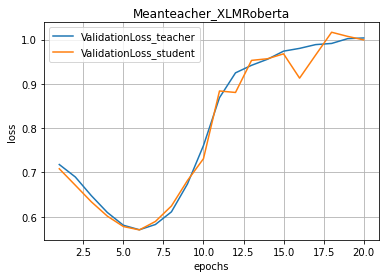

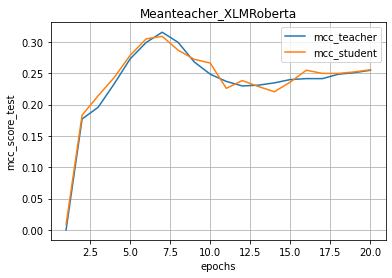

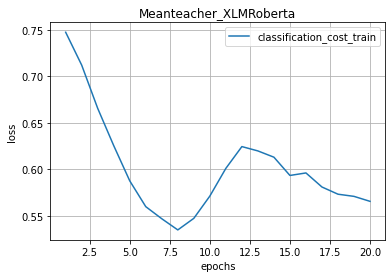

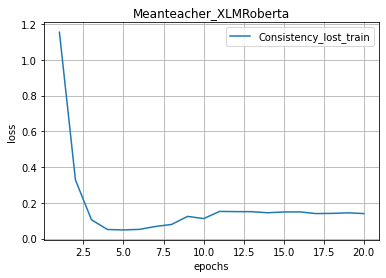

In [39]:
plot_against_epochs(test_cost_teacher,test_cost_student,label1 = 'ValidationLoss_teacher', 
                    label2 = 'ValidationLoss_student', y_label = 'loss', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(mcc_cost_teacher,mcc_cost_student,label1 = 'mcc_teacher', 
                    label2 = 'mcc_student', y_label = 'mcc_score_test', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(classification_cost_lst,None,label1 = 'classification_cost_train', 
                    label2 = None, y_label = 'loss', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(consistency_cost_lst,None,label1 = 'Consistency_lost_train', 
                    label2 = None, y_label = 'loss', title ='Meanteacher_XLMRoberta' )
# Classificataion_lost_train() # scale = 100 , epochs = 20 , apha = 0.995 

In [116]:
# config = reload(config)

config.EPOCHS

25

<h3> Running with Gaussian Noise in embeddings and with dropout in student -- labelled : unlabelled = 1:1</h3>

In [117]:
metrices = train_MeanTeacher(train_dataloader,val_dataloader,noise_layer=True) # alpha = 0.995 and full data w/o noise and dropout

consistency_cost_lst = get_items(metrices[0])
classification_cost_lst = get_items(metrices[1])
overall_cost_lst = get_items(metrices[2])
f1_class0_student_test = metrices[3]
f1_class1_student_test= metrices[4]
accuracy_student = metrices[5]
mcc_cost_student = metrices[6]
test_cost_student = tensors_to_lst(metrices[7])
f1_class1_teacher_test=metrices[8]
f1_class0_teacher_test = metrices[9]
accuracy_teacher = metrices[10]
mcc_cost_teacher = metrices[11]
test_cost_teacher=tensors_to_lst(metrices[12])

print('Consistency_lost_train :',consistency_cost_lst,'\n',
      'Classificataion_lost_train : ',classification_cost_lst,'\n',
      'Overall_loss_train :',overall_cost_lst,'\n',
      'f1_class0_student_test :',f1_class0_student_test,'\n',
      'f1_class1_student_test :',f1_class1_student_test,'\n',
      'accuracy_student :',accuracy_student,'\n',
      'mcc_cost_student :',mcc_cost_student,'\n',
      'test_cost_student :',test_cost_student,'\n',
      'f1_class0_teacher_test :',f1_class0_teacher_test,'\n',
      'f1_class1_teacher_test :',f1_class1_teacher_test,'\n',
    'accuracy_teacher :', accuracy_teacher,'\n',
      'mcc_cost_teacher',mcc_cost_teacher,'\n',
      'test_cost_teacher',test_cost_teacher)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are ini

Current epoch is 1 of 25


  8%|▊         | 51/600 [00:20<03:36,  2.54it/s]

train loss :  1.6658300280570983
Consistency Cost : 2.570526270866394
Classification Cost : 0.7611337685585022


 17%|█▋        | 101/600 [00:39<03:16,  2.54it/s]

train loss :  1.5892435240745544
Consistency Cost : 2.42912344455719
Classification Cost : 0.7493635946512223


 25%|██▌       | 151/600 [00:59<02:56,  2.54it/s]

train loss :  1.5303855697313944
Consistency Cost : 2.31594260374705
Classification Cost : 0.7448285293579101


 34%|███▎      | 201/600 [01:19<02:37,  2.53it/s]

train loss :  1.4812691712379455
Consistency Cost : 2.221318709254265
Classification Cost : 0.7412196299433709


 42%|████▏     | 251/600 [01:38<02:17,  2.53it/s]

train loss :  1.4355012335777282
Consistency Cost : 2.1331660375595094
Classification Cost : 0.7378364272117615


 50%|█████     | 301/600 [01:58<01:58,  2.53it/s]

train loss :  1.3939571030934652
Consistency Cost : 2.0523513217767078
Classification Cost : 0.735562885204951


 58%|█████▊    | 351/600 [02:18<01:38,  2.52it/s]

train loss :  1.3528458755356925
Consistency Cost : 1.972316895553044
Classification Cost : 0.7333748568807329


 67%|██████▋   | 401/600 [02:38<01:18,  2.53it/s]

train loss :  1.3132010366022586
Consistency Cost : 1.8951228207349777
Classification Cost : 0.7312792551517486


 75%|███████▌  | 451/600 [02:58<00:59,  2.52it/s]

train loss :  1.2764831994639503
Consistency Cost : 1.8232159601317512
Classification Cost : 0.7297504410478803


 84%|████████▎ | 501/600 [03:17<00:39,  2.52it/s]

train loss :  1.2408386536836624
Consistency Cost : 1.7538682099580765
Classification Cost : 0.7278090984821319


 92%|█████████▏| 551/600 [03:37<00:19,  2.52it/s]

train loss :  1.206998328187249
Consistency Cost : 1.6881000603329053
Classification Cost : 0.7258965977755459


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.44it/s]


Overall validation loss: tensor(0.6824, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.24678566466942428
Average F1 Validation score for whole sentence class 1 : 0.24869808545923497
Average Accuracy Validation score whole sentence  : 0.24774309052254673
Average mcc Validation score whole sentence : 0.11621342451241302


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.14      0.97      0.25     28264
           1       0.97      0.14      0.25    195161

    accuracy                           0.25    223425
   macro avg       0.56      0.56      0.25    223425
weighted avg       0.87      0.25      0.25    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.42it/s]


Overall validation loss: tensor(0.6881, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.23126949804400576
Average F1 Validation score for whole sentence class 1 : 0.08913640853127841
Average Accuracy Validation score whole sentence  : 0.16621685129237998
Average mcc Validation score whole sentence : 0.06329695884211571


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.13      0.99      0.23     28264
           1       0.97      0.05      0.09    195161

    accuracy                           0.17    223425
   macro avg       0.55      0.52      0.16    223425
weighted avg       0.87      0.17      0.11    223425

Current epoch is 2 of 25


  8%|▊         | 51/600 [00:20<04:00,  2.29it/s]

train loss :  0.782605631351471
Consistency Cost : 0.8515368485450745
Classification Cost : 0.71367440700531


 17%|█▋        | 101/600 [00:40<03:19,  2.50it/s]

train loss :  0.757477650642395
Consistency Cost : 0.8081368511915207
Classification Cost : 0.7068184417486191


 25%|██▌       | 151/600 [01:01<02:58,  2.52it/s]

train loss :  0.73594486673673
Consistency Cost : 0.7688182874520619
Classification Cost : 0.703071440855662


 34%|███▎      | 201/600 [01:21<02:38,  2.52it/s]

train loss :  0.715518214404583
Consistency Cost : 0.7305489277839661
Classification Cost : 0.7004874968528747


 42%|████▏     | 251/600 [01:40<02:18,  2.52it/s]

train loss :  0.6968336019515992
Consistency Cost : 0.6952488584518433
Classification Cost : 0.6984183418750763


 50%|█████     | 301/600 [02:00<01:58,  2.52it/s]

train loss :  0.6790608676274618
Consistency Cost : 0.6609847938021024
Classification Cost : 0.6971369381745657


 58%|█████▊    | 351/600 [02:20<01:38,  2.52it/s]

train loss :  0.6626894540446145
Consistency Cost : 0.6296839929478509
Classification Cost : 0.6956949128423419


 67%|██████▋   | 401/600 [02:40<01:19,  2.52it/s]

train loss :  0.647515449821949
Consistency Cost : 0.6004026857018471
Classification Cost : 0.6946282109618187


 75%|███████▌  | 451/600 [03:00<00:59,  2.52it/s]

train loss :  0.6331848319371541
Consistency Cost : 0.5729121622774336
Classification Cost : 0.6934574982855055


 84%|████████▎ | 501/600 [03:20<00:39,  2.51it/s]

train loss :  0.6194663501977921
Consistency Cost : 0.5466034093499184
Classification Cost : 0.6923292875289917


 92%|█████████▏| 551/600 [03:40<00:19,  2.51it/s]

train loss :  0.6067245476354253
Consistency Cost : 0.5216812003742565
Classification Cost : 0.6917678914286873


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.46it/s]


Overall validation loss: tensor(0.6759, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.26483447845096814
Average F1 Validation score for whole sentence class 1 : 0.3861811820649384
Average Accuracy Validation score whole sentence  : 0.33096564842788406
Average mcc Validation score whole sentence : 0.15621076806328865


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.15      0.95      0.26     28264
           1       0.97      0.24      0.39    195161

    accuracy                           0.33    223425
   macro avg       0.56      0.60      0.33    223425
weighted avg       0.87      0.33      0.37    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.46it/s]


Overall validation loss: tensor(0.6824, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2610450882013492
Average F1 Validation score for whole sentence class 1 : 0.3617762244178723
Average Accuracy Validation score whole sentence  : 0.3150945507440976
Average mcc Validation score whole sentence : 0.14846957363749982


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.15      0.96      0.26     28264
           1       0.97      0.22      0.36    195161

    accuracy                           0.32    223425
   macro avg       0.56      0.59      0.31    223425
weighted avg       0.87      0.32      0.35    223425

Current epoch is 3 of 25


  8%|▊         | 51/600 [00:20<03:38,  2.51it/s]

train loss :  0.4540046948194504
Consistency Cost : 0.21628592073917388
Classification Cost : 0.6917234694957733


 17%|█▋        | 101/600 [00:40<03:19,  2.51it/s]

train loss :  0.444160031080246
Consistency Cost : 0.2031486214697361
Classification Cost : 0.685171440243721


 25%|██▌       | 151/600 [01:00<02:58,  2.52it/s]

train loss :  0.436894193092982
Consistency Cost : 0.19083657632271447
Classification Cost : 0.6829518103599548


 34%|███▎      | 201/600 [01:20<02:39,  2.51it/s]

train loss :  0.4307635132968426
Consistency Cost : 0.17957845248281956
Classification Cost : 0.6819485750794411


 42%|████▏     | 251/600 [01:39<02:19,  2.51it/s]

train loss :  0.42484671306610106
Consistency Cost : 0.16904829171299934
Classification Cost : 0.6806451356410981


 50%|█████     | 301/600 [01:59<01:59,  2.51it/s]

train loss :  0.4198044091463089
Consistency Cost : 0.1596168427169323
Classification Cost : 0.6799919762214025


 58%|█████▊    | 351/600 [02:19<01:39,  2.51it/s]

train loss :  0.415009400503976
Consistency Cost : 0.1510528404372079
Classification Cost : 0.678965961933136


 67%|██████▋   | 401/600 [02:39<01:19,  2.52it/s]

train loss :  0.4106361681967974
Consistency Cost : 0.1430966593697667
Classification Cost : 0.6781756784021854


 75%|███████▌  | 451/600 [02:59<00:59,  2.51it/s]

train loss :  0.40664300991429225
Consistency Cost : 0.13569513827562332
Classification Cost : 0.6775908827781677


 84%|████████▎ | 501/600 [03:19<00:39,  2.51it/s]

train loss :  0.4028531168699265
Consistency Cost : 0.12893089003115893
Classification Cost : 0.6767753448486328


 92%|█████████▏| 551/600 [03:39<00:19,  2.51it/s]

train loss :  0.39938587963581085
Consistency Cost : 0.12259166716851971
Classification Cost : 0.6761800936135379


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.48it/s]


Overall validation loss: tensor(0.6655, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.27713676211831023
Average F1 Validation score for whole sentence class 1 : 0.45210022542458894
Average Accuracy Validation score whole sentence  : 0.37666330983551527
Average mcc Validation score whole sentence : 0.18017643783553736


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.16      0.94      0.28     28264
           1       0.97      0.29      0.45    195161

    accuracy                           0.38    223425
   macro avg       0.57      0.62      0.36    223425
weighted avg       0.87      0.38      0.43    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.43it/s]


Overall validation loss: tensor(0.6746, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.26534884180177337
Average F1 Validation score for whole sentence class 1 : 0.39086510516017586
Average Accuracy Validation score whole sentence  : 0.33396889336466373
Average mcc Validation score whole sentence : 0.1568679389291404


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.15      0.95      0.27     28264
           1       0.97      0.24      0.39    195161

    accuracy                           0.33    223425
   macro avg       0.56      0.60      0.33    223425
weighted avg       0.87      0.33      0.37    223425

Current epoch is 4 of 25


  8%|▊         | 51/600 [00:20<03:37,  2.52it/s]

train loss :  0.3630547571182251
Consistency Cost : 0.04758088000118733
Classification Cost : 0.6785286319255829


 17%|█▋        | 101/600 [00:40<03:18,  2.51it/s]

train loss :  0.3583552423119545
Consistency Cost : 0.04469248179346323
Classification Cost : 0.6720180028676986


 25%|██▌       | 151/600 [01:00<03:02,  2.46it/s]

train loss :  0.3559084894259771
Consistency Cost : 0.042280647655328116
Classification Cost : 0.6695363306999207


 34%|███▎      | 201/600 [01:20<02:39,  2.51it/s]

train loss :  0.3539504283666611
Consistency Cost : 0.04032424674369395
Classification Cost : 0.6675766092538834


 42%|████▏     | 251/600 [01:40<02:18,  2.52it/s]

train loss :  0.3523925292491913
Consistency Cost : 0.038338370710611344
Classification Cost : 0.66644668674469


 50%|█████     | 301/600 [01:59<01:58,  2.52it/s]

train loss :  0.3509676425655683
Consistency Cost : 0.036598414046068985
Classification Cost : 0.6653368705511093


 58%|█████▊    | 351/600 [02:20<01:39,  2.51it/s]

train loss :  0.34971289081232887
Consistency Cost : 0.03506056355578559
Classification Cost : 0.6643652183668954


 67%|██████▋   | 401/600 [02:40<01:19,  2.51it/s]

train loss :  0.3487870882451534
Consistency Cost : 0.03365679870825261
Classification Cost : 0.6639173781871796


 75%|███████▌  | 451/600 [02:59<00:59,  2.51it/s]

train loss :  0.3476833776632945
Consistency Cost : 0.03243650001784166
Classification Cost : 0.6629302555984921


 84%|████████▎ | 501/600 [03:19<00:39,  2.52it/s]

train loss :  0.34679765248298644
Consistency Cost : 0.031432250142097475
Classification Cost : 0.6621630551815033


 92%|█████████▏| 551/600 [03:39<00:19,  2.52it/s]

train loss :  0.34585985844785516
Consistency Cost : 0.030567761571569877
Classification Cost : 0.6611519556695765


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.44it/s]


Overall validation loss: tensor(0.6521, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2884340842570595
Average F1 Validation score for whole sentence class 1 : 0.513643949982858
Average Accuracy Validation score whole sentence  : 0.42220879489761665
Average mcc Validation score whole sentence : 0.1968727430629408


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.17      0.93      0.29     28264
           1       0.97      0.35      0.51    195161

    accuracy                           0.42    223425
   macro avg       0.57      0.64      0.40    223425
weighted avg       0.87      0.42      0.49    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.46it/s]


Overall validation loss: tensor(0.6589, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2785803591128295
Average F1 Validation score for whole sentence class 1 : 0.4645914882335511
Average Accuracy Validation score whole sentence  : 0.3853507888553206
Average mcc Validation score whole sentence : 0.18131704299386253


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.16      0.94      0.28     28264
           1       0.97      0.31      0.46    195161

    accuracy                           0.39    223425
   macro avg       0.57      0.62      0.37    223425
weighted avg       0.87      0.39      0.44    223425

Current epoch is 5 of 25


  8%|▊         | 51/600 [00:20<03:38,  2.52it/s]

train loss :  0.33984501361846925
Consistency Cost : 0.02181845862418413
Classification Cost : 0.6578715705871582


 17%|█▋        | 101/600 [00:41<03:18,  2.51it/s]

train loss :  0.3366310352087021
Consistency Cost : 0.021594081334769727
Classification Cost : 0.6516679894924163


 25%|██▌       | 151/600 [01:01<02:58,  2.51it/s]

train loss :  0.33540894409020744
Consistency Cost : 0.021538477192322412
Classification Cost : 0.6492794116338094


 34%|███▎      | 201/600 [01:21<02:39,  2.51it/s]

train loss :  0.33471058428287503
Consistency Cost : 0.02148706899024546
Classification Cost : 0.6479341009259224


 42%|████▏     | 251/600 [01:41<02:19,  2.51it/s]

train loss :  0.3337296687364578
Consistency Cost : 0.02177257188409567
Classification Cost : 0.6456867659091949


 50%|█████     | 301/600 [02:01<01:58,  2.52it/s]

train loss :  0.33331021656592685
Consistency Cost : 0.02202595608929793
Classification Cost : 0.6445944764216741


 58%|█████▊    | 351/600 [02:20<01:38,  2.52it/s]

train loss :  0.33276120364665984
Consistency Cost : 0.02220384922942945
Classification Cost : 0.6433185575689588


 67%|██████▋   | 401/600 [02:40<01:19,  2.51it/s]

train loss :  0.33245682895183565
Consistency Cost : 0.022300047040916978
Classification Cost : 0.642613609880209


 75%|███████▌  | 451/600 [03:00<00:59,  2.52it/s]

train loss :  0.33220151166121165
Consistency Cost : 0.022457180416418445
Classification Cost : 0.6419458419746823


 84%|████████▎ | 501/600 [03:20<00:39,  2.52it/s]

train loss :  0.33187660759687426
Consistency Cost : 0.022682565964758396
Classification Cost : 0.6410706485509873


 92%|█████████▏| 551/600 [03:40<00:19,  2.52it/s]

train loss :  0.33166628311980856
Consistency Cost : 0.022883044782687316
Classification Cost : 0.6404495212164792


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.43it/s]


Overall validation loss: tensor(0.6351, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.31903767693987395
Average F1 Validation score for whole sentence class 1 : 0.6325212160052924
Average Accuracy Validation score whole sentence  : 0.5226451829472978
Average mcc Validation score whole sentence : 0.23818894415131084


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.19      0.88      0.32     28264
           1       0.97      0.47      0.63    195161

    accuracy                           0.52    223425
   macro avg       0.58      0.68      0.48    223425
weighted avg       0.87      0.52      0.59    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.44it/s]


Overall validation loss: tensor(0.6428, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2930761773559875
Average F1 Validation score for whole sentence class 1 : 0.5389504509001364
Average Accuracy Validation score whole sentence  : 0.4418932527693857
Average mcc Validation score whole sentence : 0.202509469180495


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.17      0.91      0.29     28264
           1       0.97      0.37      0.54    195161

    accuracy                           0.44    223425
   macro avg       0.57      0.64      0.42    223425
weighted avg       0.87      0.44      0.51    223425

Current epoch is 6 of 25


  8%|▊         | 51/600 [00:20<03:37,  2.52it/s]

train loss :  0.3316634953022003
Consistency Cost : 0.02624807331711054
Classification Cost : 0.6370789158344269


 17%|█▋        | 101/600 [00:40<03:19,  2.50it/s]

train loss :  0.32835875540971754
Consistency Cost : 0.02672153478488326
Classification Cost : 0.6299959737062454


 25%|██▌       | 151/600 [01:00<02:58,  2.52it/s]

train loss :  0.3270400549968084
Consistency Cost : 0.026583151966333388
Classification Cost : 0.627496956984202


 34%|███▎      | 201/600 [01:20<02:38,  2.51it/s]

train loss :  0.32688254535198213
Consistency Cost : 0.02672154417261481
Classification Cost : 0.6270435446500778


 42%|████▏     | 251/600 [01:39<02:18,  2.52it/s]

train loss :  0.32666307532787325
Consistency Cost : 0.026867999084293843
Classification Cost : 0.6264581503868103


 50%|█████     | 301/600 [01:59<01:58,  2.52it/s]

train loss :  0.32625730087359744
Consistency Cost : 0.026968792993575335
Classification Cost : 0.6255458072821299


 58%|█████▊    | 351/600 [02:19<01:39,  2.51it/s]

train loss :  0.32590176275798255
Consistency Cost : 0.026918141783348153
Classification Cost : 0.6248853826522827


 67%|██████▋   | 401/600 [02:39<01:19,  2.52it/s]

train loss :  0.3257472414523363
Consistency Cost : 0.02676295935176313
Classification Cost : 0.6247315223515034


 75%|███████▌  | 451/600 [02:59<00:59,  2.52it/s]

train loss :  0.3255243985520469
Consistency Cost : 0.026818086761567328
Classification Cost : 0.6242307088110182


 84%|████████▎ | 501/600 [03:19<00:39,  2.52it/s]

train loss :  0.3251338857412338
Consistency Cost : 0.026947833962738515
Classification Cost : 0.6233199362754822


 92%|█████████▏| 551/600 [03:39<00:19,  2.51it/s]

train loss :  0.32482766964218834
Consistency Cost : 0.02698438745669343
Classification Cost : 0.6226709508895873


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.47it/s]


Overall validation loss: tensor(0.6216, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.33514146072829903
Average F1 Validation score for whole sentence class 1 : 0.6797400358113932
Average Accuracy Validation score whole sentence  : 0.567711760098467
Average mcc Validation score whole sentence : 0.2572259787555594


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.21      0.86      0.34     28264
           1       0.96      0.53      0.68    195161

    accuracy                           0.57    223425
   macro avg       0.59      0.69      0.51    223425
weighted avg       0.87      0.57      0.64    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.44it/s]


Overall validation loss: tensor(0.6320, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.31256902478067183
Average F1 Validation score for whole sentence class 1 : 0.6121620297119815
Average Accuracy Validation score whole sentence  : 0.5041020476670024
Average mcc Validation score whole sentence : 0.229713906533654


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.19      0.89      0.31     28264
           1       0.97      0.45      0.61    195161

    accuracy                           0.50    223425
   macro avg       0.58      0.67      0.46    223425
weighted avg       0.87      0.50      0.57    223425

Current epoch is 7 of 25


  8%|▊         | 51/600 [00:20<03:38,  2.51it/s]

train loss :  0.3231316763162613
Consistency Cost : 0.030960114002227784
Classification Cost : 0.6153032398223877


 17%|█▋        | 101/600 [00:40<03:18,  2.52it/s]

train loss :  0.32235968858003616
Consistency Cost : 0.030066736731678246
Classification Cost : 0.6146526408195495


 25%|██▌       | 151/600 [01:00<02:59,  2.50it/s]

train loss :  0.3217277131477992
Consistency Cost : 0.02982272144407034
Classification Cost : 0.6136327048142751


 34%|███▎      | 201/600 [01:20<02:38,  2.52it/s]

train loss :  0.32109713315963745
Consistency Cost : 0.029680804358795287
Classification Cost : 0.612513462305069


 42%|████▏     | 251/600 [01:40<02:18,  2.52it/s]

train loss :  0.3204337346553803
Consistency Cost : 0.02945142959803343
Classification Cost : 0.6114160404205322


 50%|█████     | 301/600 [02:00<01:58,  2.51it/s]

train loss :  0.3199096434315046
Consistency Cost : 0.02928093185648322
Classification Cost : 0.6105383549133937


 58%|█████▊    | 351/600 [02:20<01:39,  2.51it/s]

train loss :  0.3196688381263188
Consistency Cost : 0.029224179445632867
Classification Cost : 0.6101134967803955


 67%|██████▋   | 401/600 [02:40<01:25,  2.34it/s]

train loss :  0.3188973069190979
Consistency Cost : 0.02939319409430027
Classification Cost : 0.6084014199674129


 75%|███████▌  | 451/600 [03:00<00:59,  2.52it/s]

train loss :  0.31845918754736585
Consistency Cost : 0.02967474390235212
Classification Cost : 0.6072436315483517


 84%|████████▎ | 501/600 [03:21<00:39,  2.52it/s]

train loss :  0.31830434226989746
Consistency Cost : 0.02969949596375227
Classification Cost : 0.6069091893434525


 92%|█████████▏| 551/600 [03:40<00:19,  2.51it/s]

train loss :  0.31836527970704165
Consistency Cost : 0.02968838750300082
Classification Cost : 0.6070421723885969


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:15<00:00, 13.29it/s]


Overall validation loss: tensor(0.6148, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3449947741261178
Average F1 Validation score for whole sentence class 1 : 0.7080181445220239
Average Accuracy Validation score whole sentence  : 0.5960881727649099
Average mcc Validation score whole sentence : 0.26697983733994174


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.22      0.84      0.34     28264
           1       0.96      0.56      0.71    195161

    accuracy                           0.60    223425
   macro avg       0.59      0.70      0.53    223425
weighted avg       0.87      0.60      0.66    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.48it/s]


Overall validation loss: tensor(0.6243, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.32817226078961753
Average F1 Validation score for whole sentence class 1 : 0.6601876314228716
Average Accuracy Validation score whole sentence  : 0.5486628622580284
Average mcc Validation score whole sentence : 0.24921671004059104


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.20      0.87      0.33     28264
           1       0.96      0.50      0.66    195161

    accuracy                           0.55    223425
   macro avg       0.58      0.69      0.49    223425
weighted avg       0.87      0.55      0.62    223425

Current epoch is 8 of 25


  8%|▊         | 51/600 [00:20<03:37,  2.52it/s]

train loss :  0.3199190330505371
Consistency Cost : 0.031280096024274825
Classification Cost : 0.60855797290802


 17%|█▋        | 101/600 [00:40<03:18,  2.51it/s]

train loss :  0.31633579820394514
Consistency Cost : 0.02992799324914813
Classification Cost : 0.6027436041831971


 25%|██▌       | 151/600 [01:00<02:59,  2.51it/s]

train loss :  0.31511004249254865
Consistency Cost : 0.030353060600658257
Classification Cost : 0.5998670240243276


 34%|███▎      | 201/600 [01:20<02:39,  2.51it/s]

train loss :  0.3142699286341667
Consistency Cost : 0.03020622261799872
Classification Cost : 0.5983336338400841


 42%|████▏     | 251/600 [01:39<02:18,  2.51it/s]

train loss :  0.3137217445373535
Consistency Cost : 0.030366511844098568
Classification Cost : 0.5970769770145417


 50%|█████     | 301/600 [01:59<02:00,  2.49it/s]

train loss :  0.3131385609507561
Consistency Cost : 0.030343721887717643
Classification Cost : 0.5959333997964859


 58%|█████▊    | 351/600 [02:19<01:39,  2.51it/s]

train loss :  0.31287758341857363
Consistency Cost : 0.030220962134855135
Classification Cost : 0.5955342045852117


 67%|██████▋   | 401/600 [02:39<01:19,  2.51it/s]

train loss :  0.31243850842118265
Consistency Cost : 0.030220633498393
Classification Cost : 0.5946563827991486


 75%|███████▌  | 451/600 [02:59<00:59,  2.50it/s]

train loss :  0.31224618017673494
Consistency Cost : 0.030208131108019086
Classification Cost : 0.5942842288812001


 84%|████████▎ | 501/600 [03:19<00:39,  2.51it/s]

train loss :  0.3116902666687965
Consistency Cost : 0.030365424018353224
Classification Cost : 0.5930151090621948


 92%|█████████▏| 551/600 [03:39<00:19,  2.51it/s]

train loss :  0.3118634375117042
Consistency Cost : 0.030469730804589663
Classification Cost : 0.593257143497467


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.48it/s]


Overall validation loss: tensor(0.6124, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3577840691951925
Average F1 Validation score for whole sentence class 1 : 0.7415741621238228
Average Accuracy Validation score whole sentence  : 0.6314512700011189
Average mcc Validation score whole sentence : 0.2787160835452551


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.23      0.81      0.36     28264
           1       0.96      0.61      0.74    195161

    accuracy                           0.63    223425
   macro avg       0.59      0.71      0.55    223425
weighted avg       0.86      0.63      0.69    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.44it/s]


Overall validation loss: tensor(0.6186, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.34045474166908446
Average F1 Validation score for whole sentence class 1 : 0.6949620179420629
Average Accuracy Validation score whole sentence  : 0.5828533064786842
Average mcc Validation score whole sentence : 0.26268693993191006


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.21      0.85      0.34     28264
           1       0.96      0.54      0.69    195161

    accuracy                           0.58    223425
   macro avg       0.59      0.70      0.52    223425
weighted avg       0.87      0.58      0.65    223425

Current epoch is 9 of 25


  8%|▊         | 51/600 [00:20<03:38,  2.52it/s]

train loss :  0.31174610257148744
Consistency Cost : 0.03330446269363165
Classification Cost : 0.5901877421140671


 17%|█▋        | 101/600 [00:40<03:18,  2.51it/s]

train loss :  0.30983953952789306
Consistency Cost : 0.033019682094454765
Classification Cost : 0.5866593977808953


 25%|██▌       | 151/600 [01:00<02:58,  2.52it/s]

train loss :  0.3087962532043457
Consistency Cost : 0.032597492411732674
Classification Cost : 0.5849950144688288


 34%|███▎      | 201/600 [01:20<02:38,  2.51it/s]

train loss :  0.30789329573512075
Consistency Cost : 0.032300920067355035
Classification Cost : 0.5834856717288495


 42%|████▏     | 251/600 [01:39<02:18,  2.51it/s]

train loss :  0.3074544577598572
Consistency Cost : 0.0322220409065485
Classification Cost : 0.5826868752241134


 50%|█████     | 301/600 [01:59<01:58,  2.52it/s]

train loss :  0.30658353010813394
Consistency Cost : 0.031884817505876226
Classification Cost : 0.5812822432319323


 58%|█████▊    | 351/600 [02:19<01:39,  2.50it/s]

train loss :  0.30594435470444814
Consistency Cost : 0.03166473232209682
Classification Cost : 0.5802239778212138


 67%|██████▋   | 401/600 [02:39<01:19,  2.52it/s]

train loss :  0.3061529041081667
Consistency Cost : 0.03165242081042379
Classification Cost : 0.5806533879786729


 75%|███████▌  | 451/600 [02:59<00:59,  2.51it/s]

train loss :  0.30612019936243695
Consistency Cost : 0.03154680856813987
Classification Cost : 0.5806935908397038


 84%|████████▎ | 501/600 [03:19<00:39,  2.50it/s]

train loss :  0.3060836021304131
Consistency Cost : 0.03157445639744401
Classification Cost : 0.580592748105526


 92%|█████████▏| 551/600 [03:39<00:19,  2.52it/s]

train loss :  0.3057208989425139
Consistency Cost : 0.031666362285614015
Classification Cost : 0.5797754356535998


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.46it/s]


Overall validation loss: tensor(0.6068, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.36538257887405406
Average F1 Validation score for whole sentence class 1 : 0.7596199832763021
Average Accuracy Validation score whole sentence  : 0.6513147588676289
Average mcc Validation score whole sentence : 0.2854375213677065


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.24      0.79      0.37     28264
           1       0.95      0.63      0.76    195161

    accuracy                           0.65    223425
   macro avg       0.60      0.71      0.56    223425
weighted avg       0.86      0.65      0.71    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.45it/s]


Overall validation loss: tensor(0.6140, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.35191671899469656
Average F1 Validation score for whole sentence class 1 : 0.7277696387655679
Average Accuracy Validation score whole sentence  : 0.6165916974376189
Average mcc Validation score whole sentence : 0.27298063540314343


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.22      0.82      0.35     28264
           1       0.96      0.59      0.73    195161

    accuracy                           0.62    223425
   macro avg       0.59      0.70      0.54    223425
weighted avg       0.87      0.62      0.68    223425

Current epoch is 10 of 25


  8%|▊         | 51/600 [00:20<03:38,  2.51it/s]

train loss :  0.3061292004585266
Consistency Cost : 0.03411465659737587
Classification Cost : 0.5781437468528747


 17%|█▋        | 101/600 [00:40<03:18,  2.51it/s]

train loss :  0.3043156051635742
Consistency Cost : 0.03334410758689046
Classification Cost : 0.5752871054410934


 25%|██▌       | 151/600 [01:00<02:58,  2.51it/s]

train loss :  0.30242748459180196
Consistency Cost : 0.0333645294730862
Classification Cost : 0.5714904419581095


 34%|███▎      | 201/600 [01:20<02:38,  2.51it/s]

train loss :  0.30219451650977136
Consistency Cost : 0.03310743122361601
Classification Cost : 0.5712816035747528


 42%|████▏     | 251/600 [01:39<02:18,  2.52it/s]

train loss :  0.3011556934118271
Consistency Cost : 0.03332470642030239
Classification Cost : 0.5689866816997529


 50%|█████     | 301/600 [01:59<01:58,  2.52it/s]

train loss :  0.3003762904802958
Consistency Cost : 0.03345223896826307
Classification Cost : 0.5673003427187602


 58%|█████▊    | 351/600 [02:19<01:39,  2.51it/s]

train loss :  0.30011413753032684
Consistency Cost : 0.033616265718426026
Classification Cost : 0.5666120103427342


 67%|██████▋   | 401/600 [02:39<01:19,  2.51it/s]

train loss :  0.2996089995652437
Consistency Cost : 0.03360074491705745
Classification Cost : 0.5656172546744347


 75%|███████▌  | 451/600 [02:59<00:59,  2.51it/s]

train loss :  0.2992023757431242
Consistency Cost : 0.03372231610119343
Classification Cost : 0.5646824359893798


 84%|████████▎ | 501/600 [03:19<00:39,  2.52it/s]

train loss :  0.29899920070171354
Consistency Cost : 0.03362644698470831
Classification Cost : 0.5643719549179077


 92%|█████████▏| 551/600 [03:39<00:19,  2.51it/s]

train loss :  0.29876170738176866
Consistency Cost : 0.03373735179955309
Classification Cost : 0.5637860636277632


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.49it/s]


Overall validation loss: tensor(0.6039, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3812674743709227
Average F1 Validation score for whole sentence class 1 : 0.8044765130319541
Average Accuracy Validation score whole sentence  : 0.7028533064786842
Average mcc Validation score whole sentence : 0.29446449443387845


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.26      0.72      0.38     28264
           1       0.95      0.70      0.80    195161

    accuracy                           0.70    223425
   macro avg       0.60      0.71      0.59    223425
weighted avg       0.86      0.70      0.75    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.45it/s]


Overall validation loss: tensor(0.6087, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3628269878269878
Average F1 Validation score for whole sentence class 1 : 0.7564971017451391
Average Accuracy Validation score whole sentence  : 0.6476490992503077
Average mcc Validation score whole sentence : 0.282040499877051


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.24      0.79      0.36     28264
           1       0.95      0.63      0.76    195161

    accuracy                           0.65    223425
   macro avg       0.59      0.71      0.56    223425
weighted avg       0.86      0.65      0.71    223425

Current epoch is 11 of 25


  8%|▊         | 51/600 [00:20<03:38,  2.52it/s]

train loss :  0.2952176639437675
Consistency Cost : 0.036508522666990756
Classification Cost : 0.5539268082380295


 17%|█▋        | 101/600 [00:40<03:18,  2.51it/s]

train loss :  0.29496960625052454
Consistency Cost : 0.03594185262918472
Classification Cost : 0.5539973613619804


 25%|██▌       | 151/600 [01:00<02:58,  2.52it/s]

train loss :  0.2947894562284152
Consistency Cost : 0.036018051964541276
Classification Cost : 0.5535608609517415


 34%|███▎      | 201/600 [01:19<02:38,  2.52it/s]

train loss :  0.2948804610222578
Consistency Cost : 0.03591864122077823
Classification Cost : 0.5538422802090645


 42%|████▏     | 251/600 [01:39<02:18,  2.52it/s]

train loss :  0.29423442310094833
Consistency Cost : 0.035920961640775205
Classification Cost : 0.5525478838682175


 50%|█████     | 301/600 [01:59<02:07,  2.35it/s]

train loss :  0.2942923192679882
Consistency Cost : 0.0358274202918013
Classification Cost : 0.5527572175860405


 58%|█████▊    | 351/600 [02:19<01:38,  2.52it/s]

train loss :  0.2943419130785125
Consistency Cost : 0.0362243925673621
Classification Cost : 0.5524594331639153


 67%|██████▋   | 401/600 [02:39<01:19,  2.51it/s]

train loss :  0.2936282122507691
Consistency Cost : 0.03621161608491093
Classification Cost : 0.5510448073595762


 75%|███████▌  | 451/600 [02:59<00:59,  2.51it/s]

train loss :  0.29380943619542654
Consistency Cost : 0.03628513163162602
Classification Cost : 0.5513337402211296


 84%|████████▎ | 501/600 [03:19<00:39,  2.52it/s]

train loss :  0.2938724873960018
Consistency Cost : 0.03617409011349082
Classification Cost : 0.5515708839893341


 92%|█████████▏| 551/600 [03:39<00:19,  2.50it/s]

train loss :  0.2939305038614707
Consistency Cost : 0.036363354362547395
Classification Cost : 0.5514976527474144


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:15<00:00, 12.85it/s]


Overall validation loss: tensor(0.6012, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3897442226404615
Average F1 Validation score for whole sentence class 1 : 0.8302799921056471
Average Accuracy Validation score whole sentence  : 0.7344209466263847
Average mcc Validation score whole sentence : 0.29797215109529196


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.27      0.67      0.39     28264
           1       0.94      0.74      0.83    195161

    accuracy                           0.73    223425
   macro avg       0.61      0.71      0.61    223425
weighted avg       0.86      0.73      0.77    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.43it/s]


Overall validation loss: tensor(0.6046, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3740684767314607
Average F1 Validation score for whole sentence class 1 : 0.782747892775748
Average Accuracy Validation score whole sentence  : 0.6774488083249413
Average mcc Validation score whole sentence : 0.2912475173057786


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.25      0.76      0.37     28264
           1       0.95      0.67      0.78    195161

    accuracy                           0.68    223425
   macro avg       0.60      0.71      0.58    223425
weighted avg       0.86      0.68      0.73    223425

Current epoch is 12 of 25


  8%|▊         | 51/600 [00:20<03:38,  2.51it/s]

train loss :  0.29680017471313475
Consistency Cost : 0.040183473974466324
Classification Cost : 0.5534168773889542


 17%|█▋        | 101/600 [00:40<03:18,  2.51it/s]

train loss :  0.2933069851994514
Consistency Cost : 0.03930971127003431
Classification Cost : 0.5473042598366737


 25%|██▌       | 151/600 [01:00<02:58,  2.52it/s]

train loss :  0.2919677941997846
Consistency Cost : 0.03867039465655883
Classification Cost : 0.545265194773674


 34%|███▎      | 201/600 [01:20<02:38,  2.51it/s]

train loss :  0.2896159679442644
Consistency Cost : 0.038795433808118104
Classification Cost : 0.5404365022480487


 42%|████▏     | 251/600 [01:40<02:41,  2.16it/s]

train loss :  0.2895972382426262
Consistency Cost : 0.03835461731255054
Classification Cost : 0.5408398584127426


 50%|█████     | 301/600 [02:00<01:58,  2.52it/s]

train loss :  0.2886417362590631
Consistency Cost : 0.03778261923541625
Classification Cost : 0.5395008529225985


 58%|█████▊    | 351/600 [02:20<01:38,  2.52it/s]

train loss :  0.2889986970169204
Consistency Cost : 0.038007228214825904
Classification Cost : 0.5399901653187615


 67%|██████▋   | 401/600 [02:40<01:19,  2.51it/s]

train loss :  0.288275624923408
Consistency Cost : 0.037713535581715404
Classification Cost : 0.5388377139717341


 75%|███████▌  | 451/600 [03:00<00:59,  2.51it/s]

train loss :  0.2878749552700255
Consistency Cost : 0.03761640190664265
Classification Cost : 0.5381335083643596


 84%|████████▎ | 501/600 [03:20<00:39,  2.52it/s]

train loss :  0.2875661828815937
Consistency Cost : 0.037887058213353156
Classification Cost : 0.5372453075051308


 92%|█████████▏| 551/600 [03:40<00:19,  2.51it/s]

train loss :  0.2874589195576581
Consistency Cost : 0.038205848647789524
Classification Cost : 0.5367119904539802


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.43it/s]


Overall validation loss: tensor(0.5931, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.39170526404838946
Average F1 Validation score for whole sentence class 1 : 0.8367112897548568
Average Accuracy Validation score whole sentence  : 0.7425355264630189
Average mcc Validation score whole sentence : 0.2986744427172123


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.28      0.66      0.39     28264
           1       0.94      0.76      0.84    195161

    accuracy                           0.74    223425
   macro avg       0.61      0.71      0.61    223425
weighted avg       0.85      0.74      0.78    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.47it/s]


Overall validation loss: tensor(0.6006, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3845663384903891
Average F1 Validation score for whole sentence class 1 : 0.8070664315108759
Average Accuracy Validation score whole sentence  : 0.7062280407295513
Average mcc Validation score whole sentence : 0.2988065801744302


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.26      0.73      0.38     28264
           1       0.95      0.70      0.81    195161

    accuracy                           0.71    223425
   macro avg       0.60      0.71      0.60    223425
weighted avg       0.86      0.71      0.75    223425

Current epoch is 13 of 25


  8%|▊         | 51/600 [00:20<03:38,  2.51it/s]

train loss :  0.28947856545448303
Consistency Cost : 0.040994123369455335
Classification Cost : 0.5379630047082901


 17%|█▋        | 101/600 [00:40<03:18,  2.52it/s]

train loss :  0.2852956920862198
Consistency Cost : 0.04034567635506391
Classification Cost : 0.5302457058429718


 25%|██▌       | 151/600 [01:00<02:58,  2.51it/s]

train loss :  0.28475625892480216
Consistency Cost : 0.04052040518571933
Classification Cost : 0.5289921114842097


 34%|███▎      | 201/600 [01:20<02:38,  2.51it/s]

train loss :  0.2840254232287407
Consistency Cost : 0.040133012887090445
Classification Cost : 0.527917832583189


 42%|████▏     | 251/600 [01:39<02:18,  2.51it/s]

train loss :  0.28379700684547426
Consistency Cost : 0.0410218215957284
Classification Cost : 0.5265721908807754


 50%|█████     | 301/600 [01:59<01:58,  2.51it/s]

train loss :  0.28309800222516057
Consistency Cost : 0.041226712043086686
Classification Cost : 0.5249692915876707


 58%|█████▊    | 351/600 [02:19<01:38,  2.52it/s]

train loss :  0.2829326073186738
Consistency Cost : 0.04115501718861716
Classification Cost : 0.5247101961714881


 67%|██████▋   | 401/600 [02:39<01:19,  2.51it/s]

train loss :  0.2825391264259815
Consistency Cost : 0.04118867046199739
Classification Cost : 0.5238895812630653


 75%|███████▌  | 451/600 [02:59<00:59,  2.51it/s]

train loss :  0.2823198433054818
Consistency Cost : 0.04126586901230944
Classification Cost : 0.5233738166093826


 84%|████████▎ | 501/600 [03:19<00:39,  2.51it/s]

train loss :  0.282565978705883
Consistency Cost : 0.041416308790445326
Classification Cost : 0.5237156478762627


 92%|█████████▏| 551/600 [03:39<00:19,  2.51it/s]

train loss :  0.28219689613038845
Consistency Cost : 0.041316147548231215
Classification Cost : 0.5230776443264701


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.45it/s]


Overall validation loss: tensor(0.5935, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3968209574418496
Average F1 Validation score for whole sentence class 1 : 0.8566355896055263
Average Accuracy Validation score whole sentence  : 0.7683338928051919
Average mcc Validation score whole sentence : 0.30007934801446623


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.30      0.60      0.40     28264
           1       0.93      0.79      0.86    195161

    accuracy                           0.77    223425
   macro avg       0.61      0.70      0.63    223425
weighted avg       0.85      0.77      0.80    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.43it/s]


Overall validation loss: tensor(0.5971, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3923766132066837
Average F1 Validation score for whole sentence class 1 : 0.8285698709690378
Average Accuracy Validation score whole sentence  : 0.7325858789302898
Average mcc Validation score whole sentence : 0.3026174362086231


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.28      0.68      0.39     28264
           1       0.94      0.74      0.83    195161

    accuracy                           0.73    223425
   macro avg       0.61      0.71      0.61    223425
weighted avg       0.86      0.73      0.77    223425

Current epoch is 14 of 25


  8%|▊         | 51/600 [00:20<03:38,  2.51it/s]

train loss :  0.28484131455421446
Consistency Cost : 0.04275819484144449
Classification Cost : 0.5269244313240051


 17%|█▋        | 101/600 [00:40<03:18,  2.52it/s]

train loss :  0.2802057176828384
Consistency Cost : 0.04230079457163811
Classification Cost : 0.5181106403470039


 25%|██▌       | 151/600 [01:00<02:58,  2.52it/s]

train loss :  0.27757331808408103
Consistency Cost : 0.0421133728697896
Classification Cost : 0.5130332636833191


 34%|███▎      | 201/600 [01:20<02:38,  2.52it/s]

train loss :  0.2773091521114111
Consistency Cost : 0.04282493380829692
Classification Cost : 0.5117933702468872


 42%|████▏     | 251/600 [01:39<02:18,  2.52it/s]

train loss :  0.27686356526613237
Consistency Cost : 0.04308965236693621
Classification Cost : 0.5106374778747559


 50%|█████     | 301/600 [01:59<01:58,  2.52it/s]

train loss :  0.2766276740034421
Consistency Cost : 0.04311843356738488
Classification Cost : 0.5101369138558706


 58%|█████▊    | 351/600 [02:20<01:41,  2.45it/s]

train loss :  0.27629205733537676
Consistency Cost : 0.04322952603655202
Classification Cost : 0.5093545883893966


 67%|██████▋   | 401/600 [02:39<01:19,  2.51it/s]

train loss :  0.27570731081068517
Consistency Cost : 0.04350816337857395
Classification Cost : 0.5079064579308032


 75%|███████▌  | 451/600 [02:59<00:59,  2.52it/s]

train loss :  0.27613086574607426
Consistency Cost : 0.04423441256913874
Classification Cost : 0.5080273187822766


 84%|████████▎ | 501/600 [03:19<00:39,  2.51it/s]

train loss :  0.2758720286488533
Consistency Cost : 0.04430833826586604
Classification Cost : 0.5074357190728187


 92%|█████████▏| 551/600 [03:39<00:19,  2.52it/s]

train loss :  0.27563987000422047
Consistency Cost : 0.044510343941775235
Classification Cost : 0.5067693960124796


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.44it/s]


Overall validation loss: tensor(0.5933, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.39838533217640626
Average F1 Validation score for whole sentence class 1 : 0.8697598066038892
Average Accuracy Validation score whole sentence  : 0.7858744545149379
Average mcc Validation score whole sentence : 0.2996039257594072


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.31      0.56      0.40     28264
           1       0.93      0.82      0.87    195161

    accuracy                           0.79    223425
   macro avg       0.62      0.69      0.63    223425
weighted avg       0.85      0.79      0.81    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.44it/s]


Overall validation loss: tensor(0.5951, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.39804875880614254
Average F1 Validation score for whole sentence class 1 : 0.8481964714058331
Average Accuracy Validation score whole sentence  : 0.7575383238223118
Average mcc Validation score whole sentence : 0.30417762944255955


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.29      0.63      0.40     28264
           1       0.94      0.78      0.85    195161

    accuracy                           0.76    223425
   macro avg       0.61      0.70      0.62    223425
weighted avg       0.85      0.76      0.79    223425

Current epoch is 15 of 25


  8%|▊         | 51/600 [00:20<03:38,  2.51it/s]

train loss :  0.27666064232587817
Consistency Cost : 0.043176287598907945
Classification Cost : 0.5101449972391129


 17%|█▋        | 101/600 [00:40<03:17,  2.52it/s]

train loss :  0.2718552601337433
Consistency Cost : 0.044080717712640764
Classification Cost : 0.4996298041939735


 25%|██▌       | 151/600 [01:00<02:58,  2.51it/s]

train loss :  0.2724374706546466
Consistency Cost : 0.04490156096716722
Classification Cost : 0.49997338235378264


 34%|███▎      | 201/600 [01:20<02:40,  2.49it/s]

train loss :  0.271542009934783
Consistency Cost : 0.04558545391075313
Classification Cost : 0.49749856770038603


 42%|████▏     | 251/600 [01:40<02:18,  2.52it/s]

train loss :  0.27199627566337586
Consistency Cost : 0.046821745291352274
Classification Cost : 0.49717080771923067


 50%|█████     | 301/600 [02:00<01:59,  2.51it/s]

train loss :  0.2721270870665709
Consistency Cost : 0.04684134026989341
Classification Cost : 0.49741283516089124


 58%|█████▊    | 351/600 [02:20<01:39,  2.51it/s]

train loss :  0.2714980075614793
Consistency Cost : 0.046973979781780924
Classification Cost : 0.49602203624589103


 67%|██████▋   | 401/600 [02:39<01:19,  2.51it/s]

train loss :  0.27122772604227063
Consistency Cost : 0.047092361683025954
Classification Cost : 0.4953630905598402


 75%|███████▌  | 451/600 [02:59<00:59,  2.51it/s]

train loss :  0.2711238787240452
Consistency Cost : 0.04685322228405211
Classification Cost : 0.49539453466733296


 84%|████████▎ | 501/600 [03:19<00:39,  2.51it/s]

train loss :  0.27106225141882895
Consistency Cost : 0.04720551371946931
Classification Cost : 0.4949189885854721


 92%|█████████▏| 551/600 [03:39<00:19,  2.51it/s]

train loss :  0.2705254104733467
Consistency Cost : 0.04727561970326034
Classification Cost : 0.4937752005728808


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:15<00:00, 13.28it/s]


Overall validation loss: tensor(0.5889, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.40324105334233623
Average F1 Validation score for whole sentence class 1 : 0.8814645922746781
Average Accuracy Validation score whole sentence  : 0.8022155085599194
Average mcc Validation score whole sentence : 0.3048107435994113


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.33      0.53      0.40     28264
           1       0.92      0.84      0.88    195161

    accuracy                           0.80    223425
   macro avg       0.63      0.69      0.64    223425
weighted avg       0.85      0.80      0.82    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.42it/s]


Overall validation loss: tensor(0.5933, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.40201856401195646
Average F1 Validation score for whole sentence class 1 : 0.8643308796678904
Average Accuracy Validation score whole sentence  : 0.778838536421618
Average mcc Validation score whole sentence : 0.30537670760410107


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.31      0.59      0.40     28264
           1       0.93      0.81      0.86    195161

    accuracy                           0.78    223425
   macro avg       0.62      0.70      0.63    223425
weighted avg       0.85      0.78      0.81    223425

Current epoch is 16 of 25


  8%|▊         | 51/600 [00:21<03:39,  2.50it/s]

train loss :  0.2684076946973801
Consistency Cost : 0.04808599267154932
Classification Cost : 0.4887294006347656


 17%|█▋        | 101/600 [00:42<03:21,  2.48it/s]

train loss :  0.26639643862843515
Consistency Cost : 0.0471563639678061
Classification Cost : 0.4856365156173706


 25%|██▌       | 151/600 [01:02<02:58,  2.52it/s]

train loss :  0.2661803642908732
Consistency Cost : 0.046972060489157835
Classification Cost : 0.4853886687755585


 34%|███▎      | 201/600 [01:21<02:38,  2.51it/s]

train loss :  0.26559582583606245
Consistency Cost : 0.04733555597253144
Classification Cost : 0.48385609686374664


 42%|████▏     | 251/600 [01:41<02:19,  2.51it/s]

train loss :  0.2649960387945175
Consistency Cost : 0.04821736095100641
Classification Cost : 0.48177471816539763


 50%|█████     | 301/600 [02:01<01:58,  2.52it/s]

train loss :  0.2654890316228072
Consistency Cost : 0.04838843476648132
Classification Cost : 0.4825896292924881


 58%|█████▊    | 351/600 [02:21<01:39,  2.51it/s]

train loss :  0.2652098382370813
Consistency Cost : 0.04853648475238255
Classification Cost : 0.4818831924029759


 67%|██████▋   | 401/600 [02:41<01:19,  2.51it/s]

train loss :  0.26442236203700303
Consistency Cost : 0.04845798930618912
Classification Cost : 0.4803867352753878


 75%|███████▌  | 451/600 [03:01<00:59,  2.51it/s]

train loss :  0.2638788858718342
Consistency Cost : 0.04857487022876739
Classification Cost : 0.47918290184603796


 84%|████████▎ | 501/600 [03:21<00:39,  2.51it/s]

train loss :  0.26439185136556625
Consistency Cost : 0.048713437270373104
Classification Cost : 0.4800702657699585


 92%|█████████▏| 551/600 [03:41<00:19,  2.52it/s]

train loss :  0.2634570433063941
Consistency Cost : 0.048669982190159236
Classification Cost : 0.47824410487305036


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.45it/s]


Overall validation loss: tensor(0.5895, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.4021112247772391
Average F1 Validation score for whole sentence class 1 : 0.893708767240993
Average Accuracy Validation score whole sentence  : 0.8195054268770281
Average mcc Validation score whole sentence : 0.3046248604807417


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.35      0.48      0.40     28264
           1       0.92      0.87      0.89    195161

    accuracy                           0.82    223425
   macro avg       0.63      0.67      0.65    223425
weighted avg       0.85      0.82      0.83    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.43it/s]


Overall validation loss: tensor(0.5911, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.40357928862297543
Average F1 Validation score for whole sentence class 1 : 0.8780032832932131
Average Accuracy Validation score whole sentence  : 0.7974398567752042
Average mcc Validation score whole sentence : 0.3053894151808981


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.32      0.54      0.40     28264
           1       0.93      0.83      0.88    195161

    accuracy                           0.80    223425
   macro avg       0.62      0.69      0.64    223425
weighted avg       0.85      0.80      0.82    223425

Current epoch is 17 of 25


  8%|▊         | 51/600 [00:20<03:38,  2.51it/s]

train loss :  0.2636115673184395
Consistency Cost : 0.050118834786117075
Classification Cost : 0.4771042990684509


 17%|█▋        | 101/600 [00:40<03:18,  2.51it/s]

train loss :  0.26208169892430305
Consistency Cost : 0.05189431309700012
Classification Cost : 0.4722690838575363


 25%|██▌       | 151/600 [01:00<02:58,  2.51it/s]

train loss :  0.26015581319729486
Consistency Cost : 0.05205562231441339
Classification Cost : 0.46825600345929463


 34%|███▎      | 201/600 [01:20<02:42,  2.45it/s]

train loss :  0.25849709019064904
Consistency Cost : 0.05109568761661649
Classification Cost : 0.4658984932303429


 42%|████▏     | 251/600 [01:40<02:18,  2.51it/s]

train loss :  0.2593954418897629
Consistency Cost : 0.05155339927226305
Classification Cost : 0.4672374850511551


 50%|█████     | 301/600 [02:01<01:58,  2.51it/s]

train loss :  0.2595994930466016
Consistency Cost : 0.05136024832725525
Classification Cost : 0.4678387379646301


 58%|█████▊    | 351/600 [02:21<01:39,  2.51it/s]

train loss :  0.25916849281106674
Consistency Cost : 0.05128994322248868
Classification Cost : 0.46704704199518476


 67%|██████▋   | 401/600 [02:40<01:19,  2.51it/s]

train loss :  0.2584333784505725
Consistency Cost : 0.05114909399766475
Classification Cost : 0.4657176627218723


 75%|███████▌  | 451/600 [03:00<00:59,  2.51it/s]

train loss :  0.25856255829334257
Consistency Cost : 0.0510121135537823
Classification Cost : 0.4661130021015803


 84%|████████▎ | 501/600 [03:20<00:39,  2.50it/s]

train loss :  0.25836184072494506
Consistency Cost : 0.051049118012189865
Classification Cost : 0.46567456233501436


 92%|█████████▏| 551/600 [03:40<00:19,  2.52it/s]

train loss :  0.25777746376666155
Consistency Cost : 0.05119066979397427
Classification Cost : 0.4643642569130117


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.40it/s]


Overall validation loss: tensor(0.5940, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3910739191073919
Average F1 Validation score for whole sentence class 1 : 0.8972222222222223
Average Accuracy Validation score whole sentence  : 0.8241289023162135
Average mcc Validation score whole sentence : 0.29321845735781177


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.35      0.45      0.39     28264
           1       0.92      0.88      0.90    195161

    accuracy                           0.82    223425
   macro avg       0.63      0.66      0.64    223425
weighted avg       0.84      0.82      0.83    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.43it/s]


Overall validation loss: tensor(0.5900, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.4027391397389257
Average F1 Validation score for whole sentence class 1 : 0.8888800414062188
Average Accuracy Validation score whole sentence  : 0.812621685129238
Average mcc Validation score whole sentence : 0.3045416380677388


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.34      0.50      0.40     28264
           1       0.92      0.86      0.89    195161

    accuracy                           0.81    223425
   macro avg       0.63      0.68      0.65    223425
weighted avg       0.85      0.81      0.83    223425

Current epoch is 18 of 25


  8%|▊         | 51/600 [00:20<03:39,  2.51it/s]

train loss :  0.26296098709106447
Consistency Cost : 0.05331650838255882
Classification Cost : 0.47260546684265137


 17%|█▋        | 101/600 [00:40<03:18,  2.52it/s]

train loss :  0.25715337023139
Consistency Cost : 0.0539718347042799
Classification Cost : 0.46033490568399427


 25%|██▌       | 151/600 [01:00<02:58,  2.51it/s]

train loss :  0.2556178472439448
Consistency Cost : 0.052868249217669167
Classification Cost : 0.4583674450715383


 34%|███▎      | 201/600 [01:20<02:38,  2.51it/s]

train loss :  0.25577581629157065
Consistency Cost : 0.05378310990519822
Classification Cost : 0.4577685214579105


 42%|████▏     | 251/600 [01:40<02:19,  2.50it/s]

train loss :  0.25611501157283784
Consistency Cost : 0.054006187297403814
Classification Cost : 0.4582238349914551


 50%|█████     | 301/600 [02:00<01:58,  2.51it/s]

train loss :  0.2549738509953022
Consistency Cost : 0.053718272540718315
Classification Cost : 0.4562294288476308


 58%|█████▊    | 351/600 [02:19<01:39,  2.51it/s]

train loss :  0.2547632443904877
Consistency Cost : 0.054414238232587064
Classification Cost : 0.4551122498512268


 67%|██████▋   | 401/600 [02:39<01:19,  2.50it/s]

train loss :  0.2544650638848543
Consistency Cost : 0.05443190386984497
Classification Cost : 0.45449822306633


 75%|███████▌  | 451/600 [02:59<00:59,  2.51it/s]

train loss :  0.25447468012571334
Consistency Cost : 0.05422395633326636
Classification Cost : 0.4547254030572043


 84%|████████▎ | 501/600 [03:19<00:39,  2.51it/s]

train loss :  0.2548559019267559
Consistency Cost : 0.05473173001781106
Classification Cost : 0.45498007315397265


 92%|█████████▏| 551/600 [03:39<00:19,  2.50it/s]

train loss :  0.25509635841304606
Consistency Cost : 0.055137281160462986
Classification Cost : 0.45505543519150127


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.46it/s]


Overall validation loss: tensor(0.5914, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3962650643542385
Average F1 Validation score for whole sentence class 1 : 0.90890827984794
Average Accuracy Validation score whole sentence  : 0.8417007944500392
Average mcc Validation score whole sentence : 0.30555097154185906


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.38      0.41      0.40     28264
           1       0.91      0.90      0.91    195161

    accuracy                           0.84    223425
   macro avg       0.65      0.66      0.65    223425
weighted avg       0.85      0.84      0.84    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.44it/s]


Overall validation loss: tensor(0.5908, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.39948417998434116
Average F1 Validation score for whole sentence class 1 : 0.8975219472323303
Average Accuracy Validation score whole sentence  : 0.8249211144679423
Average mcc Validation score whole sentence : 0.3027213863026122


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.35      0.46      0.40     28264
           1       0.92      0.88      0.90    195161

    accuracy                           0.82    223425
   macro avg       0.64      0.67      0.65    223425
weighted avg       0.85      0.82      0.83    223425

Current epoch is 19 of 25


  8%|▊         | 51/600 [00:20<03:38,  2.52it/s]

train loss :  0.2576305064558983
Consistency Cost : 0.05552228614687919
Classification Cost : 0.4597387254238129


 17%|█▋        | 101/600 [00:40<03:18,  2.52it/s]

train loss :  0.25516103833913806
Consistency Cost : 0.05529496718198061
Classification Cost : 0.45502710819244385


 25%|██▌       | 151/600 [01:00<02:59,  2.51it/s]

train loss :  0.25634191383918126
Consistency Cost : 0.055448007968564826
Classification Cost : 0.45723581890265147


 34%|███▎      | 201/600 [01:20<02:38,  2.51it/s]

train loss :  0.2540595092624426
Consistency Cost : 0.05563989379443228
Classification Cost : 0.4524791245162487


 42%|████▏     | 251/600 [01:39<02:18,  2.52it/s]

train loss :  0.2524300938248634
Consistency Cost : 0.055606178008019924
Classification Cost : 0.4492540090084076


 50%|█████     | 301/600 [01:59<01:59,  2.49it/s]

train loss :  0.25162068064014115
Consistency Cost : 0.05564005107308428
Classification Cost : 0.44760130941867826


 58%|█████▊    | 351/600 [02:19<01:39,  2.51it/s]

train loss :  0.25134686461516786
Consistency Cost : 0.05608641810183014
Classification Cost : 0.44660731017589567


 67%|██████▋   | 401/600 [02:39<01:19,  2.51it/s]

train loss :  0.2504627988487482
Consistency Cost : 0.0560807040752843
Classification Cost : 0.44484489254653453


 75%|███████▌  | 451/600 [02:59<00:59,  2.51it/s]

train loss :  0.250088122288386
Consistency Cost : 0.05614543343169821
Classification Cost : 0.4440308103296492


 84%|████████▎ | 501/600 [03:19<00:39,  2.51it/s]

train loss :  0.2503238034248352
Consistency Cost : 0.05623132837191224
Classification Cost : 0.4444162776470184


 92%|█████████▏| 551/600 [03:39<00:19,  2.52it/s]

train loss :  0.25014827928759836
Consistency Cost : 0.05672682828185233
Classification Cost : 0.4435697297074578


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.43it/s]


Overall validation loss: tensor(0.5973, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.38160061477659457
Average F1 Validation score for whole sentence class 1 : 0.9138237003947006
Average Accuracy Validation score whole sentence  : 0.848727760993622
Average mcc Validation score whole sentence : 0.2957654437083334


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.40      0.37      0.38     28264
           1       0.91      0.92      0.91    195161

    accuracy                           0.85    223425
   macro avg       0.65      0.64      0.65    223425
weighted avg       0.84      0.85      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.46it/s]


Overall validation loss: tensor(0.5919, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3965903699219581
Average F1 Validation score for whole sentence class 1 : 0.9043862400804709
Average Accuracy Validation score whole sentence  : 0.8349289470739621
Average mcc Validation score whole sentence : 0.30274881061261094


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.37      0.43      0.40     28264
           1       0.92      0.89      0.90    195161

    accuracy                           0.83    223425
   macro avg       0.64      0.66      0.65    223425
weighted avg       0.85      0.83      0.84    223425

Current epoch is 20 of 25


  8%|▊         | 51/600 [00:20<03:39,  2.50it/s]

train loss :  0.2556482443213463
Consistency Cost : 0.06388499937951565
Classification Cost : 0.4474114882946014


 17%|█▋        | 101/600 [00:40<03:19,  2.50it/s]

train loss :  0.2534937074780464
Consistency Cost : 0.06309020824730396
Classification Cost : 0.443897205889225


 25%|██▌       | 151/600 [01:00<02:59,  2.51it/s]

train loss :  0.25155837565660477
Consistency Cost : 0.06073490329086781
Classification Cost : 0.44238184750080106


 34%|███▎      | 201/600 [01:20<02:38,  2.51it/s]

train loss :  0.24900275364518165
Consistency Cost : 0.05923241779208183
Classification Cost : 0.4387730887532234


 42%|████▏     | 251/600 [01:40<02:19,  2.50it/s]

train loss :  0.24824492871761322
Consistency Cost : 0.05953024300932884
Classification Cost : 0.43695961344242096


 50%|█████     | 301/600 [02:00<01:59,  2.51it/s]

train loss :  0.2486286913851897
Consistency Cost : 0.059883164105316
Classification Cost : 0.43737421800692877


 58%|█████▊    | 351/600 [02:20<01:38,  2.52it/s]

train loss :  0.24778308902468
Consistency Cost : 0.05971782570438726
Classification Cost : 0.43584835171699526


 67%|██████▋   | 401/600 [02:40<01:19,  2.50it/s]

train loss :  0.2463372278213501
Consistency Cost : 0.059231073204427956
Classification Cost : 0.4334433817118406


 75%|███████▌  | 451/600 [03:00<00:59,  2.51it/s]

train loss :  0.24642054475016065
Consistency Cost : 0.05895306772655911
Classification Cost : 0.43388802097903356


 84%|████████▎ | 501/600 [03:20<00:39,  2.51it/s]

train loss :  0.24591018271446227
Consistency Cost : 0.05934907830506563
Classification Cost : 0.4324712863564491


 92%|█████████▏| 551/600 [03:40<00:19,  2.50it/s]

train loss :  0.24538876016031613
Consistency Cost : 0.05925524505701932
Classification Cost : 0.43152227439663626


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.38it/s]


Overall validation loss: tensor(0.5956, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3869953763774923
Average F1 Validation score for whole sentence class 1 : 0.9144597086177833
Average Accuracy Validation score whole sentence  : 0.8498690835850957
Average mcc Validation score whole sentence : 0.30177576600084693


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.40      0.37      0.39     28264
           1       0.91      0.92      0.91    195161

    accuracy                           0.85    223425
   macro avg       0.66      0.65      0.65    223425
weighted avg       0.85      0.85      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.37it/s]


Overall validation loss: tensor(0.5938, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.39193442396153977
Average F1 Validation score for whole sentence class 1 : 0.9096148309615859
Average Accuracy Validation score whole sentence  : 0.8426228040729551
Average mcc Validation score whole sentence : 0.3017018444843026


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.38      0.40      0.39     28264
           1       0.91      0.91      0.91    195161

    accuracy                           0.84    223425
   macro avg       0.65      0.65      0.65    223425
weighted avg       0.85      0.84      0.84    223425

Current epoch is 21 of 25


  8%|▊         | 51/600 [00:20<03:38,  2.51it/s]

train loss :  0.24048585087060928
Consistency Cost : 0.059404905289411544
Classification Cost : 0.42156679451465606


 17%|█▋        | 101/600 [00:41<03:19,  2.50it/s]

train loss :  0.23905963122844695
Consistency Cost : 0.06117458797991276
Classification Cost : 0.41694467425346377


 25%|██▌       | 151/600 [01:01<02:59,  2.51it/s]

train loss :  0.2435031231244405
Consistency Cost : 0.061700417349735893
Classification Cost : 0.4253058290481567


 34%|███▎      | 201/600 [01:21<02:38,  2.51it/s]

train loss :  0.242760866060853
Consistency Cost : 0.06214414531365037
Classification Cost : 0.4233775870501995


 42%|████▏     | 251/600 [01:41<02:19,  2.50it/s]

train loss :  0.24253320795297623
Consistency Cost : 0.0619097421169281
Classification Cost : 0.42315667402744295


 50%|█████     | 301/600 [02:01<01:59,  2.51it/s]

train loss :  0.2422918035586675
Consistency Cost : 0.062339959541956584
Classification Cost : 0.4222436476747195


 58%|█████▊    | 351/600 [02:21<01:39,  2.51it/s]

train loss :  0.24217238128185273
Consistency Cost : 0.06187230059078762
Classification Cost : 0.4224724623135158


 67%|██████▋   | 401/600 [02:41<01:19,  2.50it/s]

train loss :  0.2419666438922286
Consistency Cost : 0.062004219396039846
Classification Cost : 0.42192906893789767


 75%|███████▌  | 451/600 [03:01<00:59,  2.51it/s]

train loss :  0.242120503352748
Consistency Cost : 0.06167468381424745
Classification Cost : 0.42256632334656186


 84%|████████▎ | 501/600 [03:21<00:39,  2.51it/s]

train loss :  0.24181518694758417
Consistency Cost : 0.061593167275190354
Classification Cost : 0.4220372069478035


 92%|█████████▏| 551/600 [03:41<00:19,  2.50it/s]

train loss :  0.2417542904073542
Consistency Cost : 0.06186492962593382
Classification Cost : 0.4216436514529315


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.47it/s]


Overall validation loss: tensor(0.6002, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3783721422116253
Average F1 Validation score for whole sentence class 1 : 0.9181218864206785
Average Accuracy Validation score whole sentence  : 0.8553026742754839
Average mcc Validation score whole sentence : 0.29863943627051986


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.41      0.35      0.38     28264
           1       0.91      0.93      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.66      0.64      0.65    223425
weighted avg       0.85      0.86      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.42it/s]


Overall validation loss: tensor(0.5946, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3874375964418626
Average F1 Validation score for whole sentence class 1 : 0.9138692838819189
Average Accuracy Validation score whole sentence  : 0.8489739286113909
Average mcc Validation score whole sentence : 0.3015088820667613


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.40      0.38      0.39     28264
           1       0.91      0.92      0.91    195161

    accuracy                           0.85    223425
   macro avg       0.65      0.65      0.65    223425
weighted avg       0.85      0.85      0.85    223425

Current epoch is 22 of 25


  8%|▊         | 51/600 [00:20<03:38,  2.51it/s]

train loss :  0.2386107251048088
Consistency Cost : 0.06342124581336975
Classification Cost : 0.4138002026081085


 17%|█▋        | 101/600 [00:40<03:19,  2.51it/s]

train loss :  0.2411519008874893
Consistency Cost : 0.06312686450779438
Classification Cost : 0.4191769379377365


 25%|██▌       | 151/600 [01:00<02:58,  2.51it/s]

train loss :  0.24032317568858463
Consistency Cost : 0.0636158995081981
Classification Cost : 0.4170304528872172


 34%|███▎      | 201/600 [01:20<02:39,  2.51it/s]

train loss :  0.24131332226097585
Consistency Cost : 0.06404154382646084
Classification Cost : 0.4185851010680199


 42%|████▏     | 251/600 [01:40<02:19,  2.51it/s]

train loss :  0.24080949455499648
Consistency Cost : 0.06426206037402153
Classification Cost : 0.41735692954063414


 50%|█████     | 301/600 [02:00<01:59,  2.50it/s]

train loss :  0.24044835398594538
Consistency Cost : 0.06461459950854381
Classification Cost : 0.41628210882345834


 58%|█████▊    | 351/600 [02:20<01:39,  2.50it/s]

train loss :  0.23996706583670208
Consistency Cost : 0.06523844310215542
Classification Cost : 0.4146956890821457


 67%|██████▋   | 401/600 [02:40<01:19,  2.50it/s]

train loss :  0.2395686186477542
Consistency Cost : 0.06481539701111615
Classification Cost : 0.4143218407779932


 75%|███████▌  | 451/600 [02:59<00:59,  2.51it/s]

train loss :  0.23932267877790664
Consistency Cost : 0.06495828438136313
Classification Cost : 0.4136870739195082


 84%|████████▎ | 501/600 [03:19<00:39,  2.51it/s]

train loss :  0.23945749485492707
Consistency Cost : 0.06463435310125351
Classification Cost : 0.4142806370258331


 92%|█████████▏| 551/600 [03:39<00:19,  2.51it/s]

train loss :  0.23906086921691894
Consistency Cost : 0.0649279257926074
Classification Cost : 0.4131938129121607


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.37it/s]


Overall validation loss: tensor(0.6031, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.37889603366566377
Average F1 Validation score for whole sentence class 1 : 0.920239294742132
Average Accuracy Validation score whole sentence  : 0.8586326507776659
Average mcc Validation score whole sentence : 0.3026559888482731


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.43      0.34      0.38     28264
           1       0.91      0.93      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.67      0.64      0.65    223425
weighted avg       0.85      0.86      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.34it/s]


Overall validation loss: tensor(0.5978, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.38246816846229187
Average F1 Validation score for whole sentence class 1 : 0.9167356599738926
Average Accuracy Validation score whole sentence  : 0.8532572451605684
Average mcc Validation score whole sentence : 0.3004097594914886


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.41      0.36      0.38     28264
           1       0.91      0.92      0.92    195161

    accuracy                           0.85    223425
   macro avg       0.66      0.64      0.65    223425
weighted avg       0.85      0.85      0.85    223425

Current epoch is 23 of 25


  8%|▊         | 51/600 [00:20<03:38,  2.51it/s]

train loss :  0.24152682095766068
Consistency Cost : 0.06485655046999454
Classification Cost : 0.4181970924139023


 17%|█▋        | 101/600 [00:40<03:19,  2.51it/s]

train loss :  0.2398351973295212
Consistency Cost : 0.06655340328812599
Classification Cost : 0.4131169921159744


 25%|██▌       | 151/600 [01:00<02:58,  2.51it/s]

train loss :  0.24035958528518678
Consistency Cost : 0.06860865170756976
Classification Cost : 0.41211051841576896


 34%|███▎      | 201/600 [01:20<02:38,  2.52it/s]

train loss :  0.24138143345713614
Consistency Cost : 0.06918049354106187
Classification Cost : 0.41358237266540526


 42%|████▏     | 251/600 [01:40<02:18,  2.52it/s]

train loss :  0.24035461086034776
Consistency Cost : 0.06887359811365604
Classification Cost : 0.41183562314510347


 50%|█████     | 301/600 [02:00<01:59,  2.51it/s]

train loss :  0.24002211004495622
Consistency Cost : 0.0681563413888216
Classification Cost : 0.4118878784775734


 58%|█████▊    | 351/600 [02:19<01:39,  2.52it/s]

train loss :  0.24017467413629803
Consistency Cost : 0.06790639957146985
Classification Cost : 0.4124429485627583


 67%|██████▋   | 401/600 [02:39<01:19,  2.52it/s]

train loss :  0.23957853872328996
Consistency Cost : 0.06737981368787586
Classification Cost : 0.41177726335823533


 75%|███████▌  | 451/600 [02:59<00:59,  2.50it/s]

train loss :  0.23875484118858972
Consistency Cost : 0.0679532165825367
Classification Cost : 0.4095564655462901


 84%|████████▎ | 501/600 [03:19<00:39,  2.52it/s]

train loss :  0.23804459708929063
Consistency Cost : 0.06815742787718773
Classification Cost : 0.4079317660331726


 92%|█████████▏| 551/600 [03:39<00:19,  2.51it/s]

train loss :  0.23752858690240167
Consistency Cost : 0.06801027320325374
Classification Cost : 0.40704690049995074


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.41it/s]


Overall validation loss: tensor(0.6125, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.36747812383361667
Average F1 Validation score for whole sentence class 1 : 0.9234767600545878
Average Accuracy Validation score whole sentence  : 0.8634709634105404
Average mcc Validation score whole sentence : 0.2990688028229034


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.44      0.31      0.37     28264
           1       0.90      0.94      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.67      0.63      0.65    223425
weighted avg       0.85      0.86      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.44it/s]


Overall validation loss: tensor(0.6019, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3791216282013828
Average F1 Validation score for whole sentence class 1 : 0.9193967206482851
Average Accuracy Validation score whole sentence  : 0.8573167729663198
Average mcc Validation score whole sentence : 0.30140652355628567


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.42      0.34      0.38     28264
           1       0.91      0.93      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.66      0.64      0.65    223425
weighted avg       0.85      0.86      0.85    223425

Current epoch is 24 of 25


  8%|▊         | 51/600 [00:20<03:38,  2.51it/s]

train loss :  0.24001644551753998
Consistency Cost : 0.07045556753873825
Classification Cost : 0.40957732379436496


 17%|█▋        | 101/600 [00:40<03:18,  2.52it/s]

train loss :  0.23385086968541147
Consistency Cost : 0.06829776130616665
Classification Cost : 0.3994039782881737


 25%|██▌       | 151/600 [01:00<02:58,  2.52it/s]

train loss :  0.23093057950337728
Consistency Cost : 0.06707953418294589
Classification Cost : 0.39478162586689


 34%|███▎      | 201/600 [01:20<02:38,  2.52it/s]

train loss :  0.23213385462760924
Consistency Cost : 0.06769894303753972
Classification Cost : 0.3965687671303749


 42%|████▏     | 251/600 [01:39<02:18,  2.51it/s]

train loss :  0.2317587230205536
Consistency Cost : 0.06808491188287735
Classification Cost : 0.3954325351715088


 50%|█████     | 301/600 [02:00<01:58,  2.51it/s]

train loss :  0.23275956824421884
Consistency Cost : 0.06863174503048261
Classification Cost : 0.39688739240169524


 58%|█████▊    | 351/600 [02:19<01:38,  2.52it/s]

train loss :  0.23270602677549634
Consistency Cost : 0.0679448355947222
Classification Cost : 0.3974672188929149


 67%|██████▋   | 401/600 [02:39<01:18,  2.52it/s]

train loss :  0.23328387025743724
Consistency Cost : 0.0685353006888181
Classification Cost : 0.3980324401706457


 75%|███████▌  | 451/600 [02:59<00:59,  2.50it/s]

train loss :  0.23359628485308753
Consistency Cost : 0.0686927442252636
Classification Cost : 0.39849982599417366


 84%|████████▎ | 501/600 [03:19<00:39,  2.52it/s]

train loss :  0.23412429890036582
Consistency Cost : 0.06970309542119503
Classification Cost : 0.3985455028414726


 92%|█████████▏| 551/600 [03:39<00:19,  2.52it/s]

train loss :  0.23373078373345463
Consistency Cost : 0.06962769385765899
Classification Cost : 0.3978338739546863


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.40it/s]


Overall validation loss: tensor(0.6176, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.36656738799908356
Average F1 Validation score for whole sentence class 1 : 0.923745790887004
Average Accuracy Validation score whole sentence  : 0.8638782589235762
Average mcc Validation score whole sentence : 0.2989046933262072


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.45      0.31      0.37     28264
           1       0.90      0.94      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.68      0.63      0.65    223425
weighted avg       0.85      0.86      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.40it/s]


Overall validation loss: tensor(0.6062, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3750525241611141
Average F1 Validation score for whole sentence class 1 : 0.9213022805784218
Average Accuracy Validation score whole sentence  : 0.8602081235313864
Average mcc Validation score whole sentence : 0.30115762515167566


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.43      0.33      0.38     28264
           1       0.91      0.94      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.67      0.63      0.65    223425
weighted avg       0.85      0.86      0.85    223425

Current epoch is 25 of 25


  8%|▊         | 51/600 [00:20<03:38,  2.51it/s]

train loss :  0.23054155915975572
Consistency Cost : 0.06883876048028469
Classification Cost : 0.39224435806274416


 17%|█▋        | 101/600 [00:40<03:18,  2.51it/s]

train loss :  0.23131478384137152
Consistency Cost : 0.06992058519273997
Classification Cost : 0.39270898312330244


 25%|██▌       | 151/600 [01:00<02:59,  2.50it/s]

train loss :  0.23263181904951732
Consistency Cost : 0.07120206599434217
Classification Cost : 0.3940615723530451


 34%|███▎      | 201/600 [01:20<02:39,  2.50it/s]

train loss :  0.23340991333127023
Consistency Cost : 0.07094211569055915
Classification Cost : 0.39587771132588384


 42%|████▏     | 251/600 [01:40<02:19,  2.51it/s]

train loss :  0.23313583660125733
Consistency Cost : 0.07198251138627529
Classification Cost : 0.3942891618013382


 50%|█████     | 301/600 [02:00<01:59,  2.50it/s]

train loss :  0.23417608420054117
Consistency Cost : 0.07269377930710713
Classification Cost : 0.39565838863452274


 58%|█████▊    | 351/600 [02:20<01:39,  2.51it/s]

train loss :  0.2319781470298767
Consistency Cost : 0.07253022975155285
Classification Cost : 0.39142606403146474


 67%|██████▋   | 401/600 [02:40<01:19,  2.51it/s]

train loss :  0.23235983431339263
Consistency Cost : 0.07257005281746387
Classification Cost : 0.3921496154367924


 75%|███████▌  | 451/600 [02:59<00:59,  2.50it/s]

train loss :  0.23149115638600457
Consistency Cost : 0.07256346240639687
Classification Cost : 0.39041885018348693


 84%|████████▎ | 501/600 [03:19<00:39,  2.51it/s]

train loss :  0.23185441622138023
Consistency Cost : 0.07288039266318083
Classification Cost : 0.3908284400105476


 92%|█████████▏| 551/600 [03:39<00:19,  2.51it/s]

train loss :  0.23270911341363734
Consistency Cost : 0.0735497479818084
Classification Cost : 0.39186847919767553


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:14<00:00, 13.36it/s]


Overall validation loss: tensor(0.6243, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.35880327623446895
Average F1 Validation score for whole sentence class 1 : 0.9250591743337108
Average Accuracy Validation score whole sentence  : 0.8658028421170415
Average mcc Validation score whole sentence : 0.29556679098105554


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.45      0.30      0.36     28264
           1       0.90      0.95      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.68      0.62      0.64    223425
weighted avg       0.85      0.87      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:14<00:00, 13.36it/s]


Overall validation loss: tensor(0.6128, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3708473464030842
Average F1 Validation score for whole sentence class 1 : 0.9229312259160082
Average Accuracy Validation score whole sentence  : 0.8626832270336802
Average mcc Validation score whole sentence : 0.3007770620436568
Classification Report :
               precision    recall  f1-score   support

           0       0.44      0.32      0.37     28264
           1       0.91      0.94      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.67      0.63      0.65    223425
weighted avg       0.85      0.86      0.85    223425

Consistency_lost_train : [1.6239565767844517, 0.49798710557321707, 0.11672209713608027, 0.029690529874836405, 0.023147321445867418, 0.02702290556083123, 0.02972689919794599, 0.030483571436877053, 0.0317342549127837, 0.03371453968808055, 0.03625425363580386, 0.03807460453982155, 0.04127282000457247, 0.0

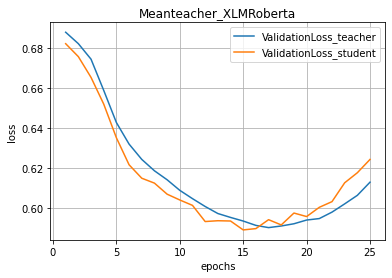

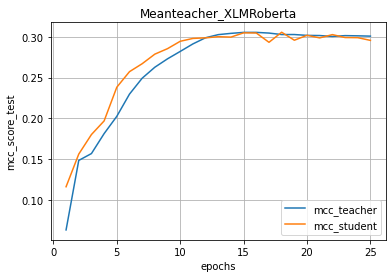

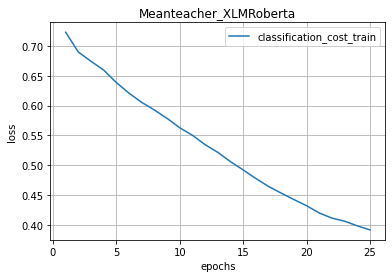

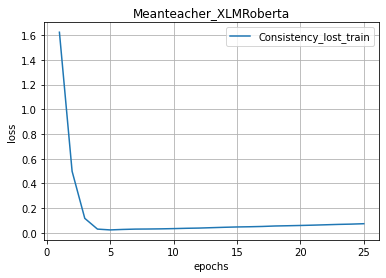

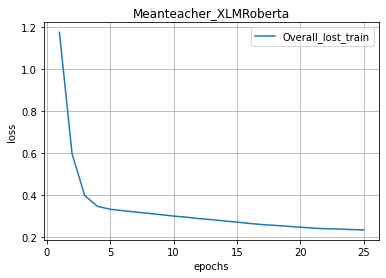

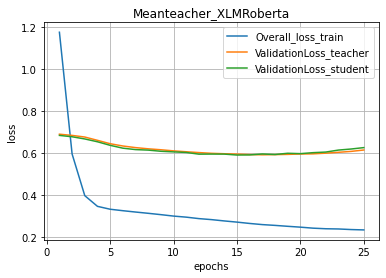

In [118]:
plot_against_epochs(test_cost_teacher,test_cost_student,None,label1 = 'ValidationLoss_teacher', 
                    label2 = 'ValidationLoss_student',label3=None, y_label = 'loss', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(mcc_cost_teacher,mcc_cost_student,None,label1 = 'mcc_teacher', 
                    label2 = 'mcc_student',label3=None, y_label = 'mcc_score_test', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(classification_cost_lst,None,None,label1 = 'classification_cost_train', 
                    label2 = None,label3=None, y_label = 'loss', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(consistency_cost_lst,None,None,label1 = 'Consistency_lost_train', 
                    label2 = None,label3=None, y_label = 'loss', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(overall_cost_lst,None,None,label1 = 'Overall_lost_train', 
                    label2 = None,label3=None, y_label = 'loss', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(overall_cost_lst,test_cost_teacher,test_cost_student,label1 = 'Overall_loss_train', 
                    label2 = 'ValidationLoss_teacher',label3 = 'ValidationLoss_student', y_label = 'loss', title ='Meanteacher_XLMRoberta' )
# Classificataion_lost_train()

In [ ]:
# more labelled and less unlabelled - 3600 unlabelled
metrices = train_MeanTeacher(train_dataloader,val_dataloader,writer, noise_layer=True) # alpha = 0.999 and scaled_consistency = 100
writer.close()
consistency_cost_lst = get_items(metrices[0])
classification_cost_lst = get_items(metrices[1])
overall_cost_lst = get_items(metrices[2])
f1_class0_student_test = metrices[3]
f1_class1_student_test= metrices[4]
accuracy_student = metrices[5]
mcc_cost_student = metrices[6]
test_cost_student = tensors_to_lst(metrices[7])
f1_class1_teacher_test=metrices[8]
f1_class0_teacher_test = metrices[9]
accuracy_teacher = metrices[10]
mcc_cost_teacher = metrices[11]
test_cost_teacher=tensors_to_lst(metrices[12])

print('Consistency_lost_train :',consistency_cost_lst,'\n',
      'Classificataion_lost_train : ',classification_cost_lst,'\n',
      'Overall_loss_train :',overall_cost_lst,'\n',
      'f1_class0_student_test :',f1_class0_student_test,'\n',
      'f1_class1_student_test :',f1_class1_student_test,'\n',
      'accuracy_student :',accuracy_student,'\n',
      'mcc_cost_student :',mcc_cost_student,'\n',
      'test_cost_student :',test_cost_student,'\n',
      'f1_class0_teacher_test :',f1_class0_teacher_test,'\n',
      'f1_class1_teacher_test :',f1_class1_teacher_test,'\n',
    'accuracy_teacher :', accuracy_teacher,'\n',
      'mcc_cost_teacher',mcc_cost_teacher,'\n',
      'test_cost_teacher',test_cost_teacher)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are ini

Current epoch is 1 of 6


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /codebuild/output/src811146734/src/torch/csrc/utils/python_arg_parser.cpp:766.)
  del sys.path[0]
  8%|▊         | 51/600 [00:48<08:36,  1.06it/s]

train loss :  1.6645975923538208
Consistency Cost : 2.5690077114105225
Classification Cost : 0.7601874828338623


 17%|█▋        | 101/600 [01:35<08:01,  1.04it/s]

train loss :  1.585494657754898
Consistency Cost : 2.4223224687576295
Classification Cost : 0.7486668467521668


 25%|██▌       | 151/600 [02:24<07:22,  1.02it/s]

train loss :  1.5222491526603699
Consistency Cost : 2.2999211287498476
Classification Cost : 0.7445771745840708


 34%|███▎      | 201/600 [03:12<06:17,  1.06it/s]

train loss :  1.47222931265831
Consistency Cost : 2.2032296031713487
Classification Cost : 0.7412290248274803


 42%|████▏     | 251/600 [03:59<05:28,  1.06it/s]

train loss :  1.425004425048828
Consistency Cost : 2.1124742932319642
Classification Cost : 0.7375345594882965


 50%|█████     | 301/600 [04:46<04:43,  1.06it/s]

train loss :  1.3816590611139934
Consistency Cost : 2.028090546528498
Classification Cost : 0.7352275782823563


 58%|█████▊    | 351/600 [05:34<03:57,  1.05it/s]

train loss :  1.3391200620787485
Consistency Cost : 1.9451308631896973
Classification Cost : 0.7331092623301915


 67%|██████▋   | 401/600 [06:22<03:12,  1.03it/s]

train loss :  1.2976105213165283
Consistency Cost : 1.8643003475666047
Classification Cost : 0.7309206931293011


 75%|███████▌  | 451/600 [07:11<02:27,  1.01it/s]

train loss :  1.2585266404681736
Consistency Cost : 1.7879810116026136
Classification Cost : 0.7290722676118215


 84%|████████▎ | 501/600 [07:59<01:34,  1.05it/s]

train loss :  1.2211723181009293
Consistency Cost : 1.7152377866506576
Classification Cost : 0.7271068487167358


 92%|█████████▏| 551/600 [08:47<00:46,  1.06it/s]

train loss :  1.1856692232868888
Consistency Cost : 1.6461137874559923
Classification Cost : 0.7252246592261574


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:42<00:00,  4.72it/s]


Overall validation loss: tensor(0.6814, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2608180087247837
Average F1 Validation score for whole sentence class 1 : 0.3594394202051004
Average Accuracy Validation score whole sentence  : 0.3136533512364328
Average mcc Validation score whole sentence : 0.1481923584353105


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.15      0.96      0.26     28264
           1       0.97      0.22      0.36    195161

    accuracy                           0.31    223425
   macro avg       0.56      0.59      0.31    223425
weighted avg       0.87      0.31      0.35    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:42<00:00,  4.69it/s]


Overall validation loss: tensor(0.6882, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.23632632424233413
Average F1 Validation score for whole sentence class 1 : 0.15012601128191064
Average Accuracy Validation score whole sentence  : 0.19552870090634442
Average mcc Validation score whole sentence : 0.08342133234446686


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.13      0.98      0.24     28264
           1       0.97      0.08      0.15    195161

    accuracy                           0.20    223425
   macro avg       0.55      0.53      0.19    223425
weighted avg       0.87      0.20      0.16    223425

Current epoch is 2 of 6


  8%|▊         | 51/600 [00:49<08:56,  1.02it/s]

train loss :  0.7439069998264313
Consistency Cost : 0.7746685576438904
Classification Cost : 0.7131454408168793


 17%|█▋        | 101/600 [01:38<08:01,  1.04it/s]

train loss :  0.7165013891458512
Consistency Cost : 0.7285026830434799
Classification Cost : 0.7045001018047333


 25%|██▌       | 151/600 [02:26<07:04,  1.06it/s]

train loss :  0.6936642626921335
Consistency Cost : 0.6864629940191904
Classification Cost : 0.7008655345439911


 34%|███▎      | 201/600 [03:13<06:16,  1.06it/s]

train loss :  0.673724927008152
Consistency Cost : 0.6489078103005886
Classification Cost : 0.6985420474410057


 42%|████▏     | 251/600 [04:00<05:30,  1.06it/s]

train loss :  0.6549938695430756
Consistency Cost : 0.6134218523502349
Classification Cost : 0.6965658922195435


 50%|█████     | 301/600 [04:48<04:46,  1.04it/s]

train loss :  0.6371541013320287
Consistency Cost : 0.5791428545117379
Classification Cost : 0.695165352622668


 58%|█████▊    | 351/600 [05:36<04:02,  1.03it/s]

train loss :  0.620419854266303
Consistency Cost : 0.5472079775163106
Classification Cost : 0.6936317345074244


 67%|██████▋   | 401/600 [06:26<03:15,  1.02it/s]

train loss :  0.6045867110788822
Consistency Cost : 0.5166949544101953
Classification Cost : 0.6924784706532955


 75%|███████▌  | 451/600 [07:13<02:21,  1.05it/s]

train loss :  0.5898562777704662
Consistency Cost : 0.4884480995602078
Classification Cost : 0.6912644588947296


 84%|████████▎ | 501/600 [08:01<01:33,  1.06it/s]

train loss :  0.5761102130413055
Consistency Cost : 0.4620481632053852
Classification Cost : 0.690172265291214


 92%|█████████▏| 551/600 [08:48<00:46,  1.06it/s]

train loss :  0.5633671949126504
Consistency Cost : 0.4373033929413015
Classification Cost : 0.6894309993223711


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:42<00:00,  4.66it/s]


Overall validation loss: tensor(0.6740, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2718047592470445
Average F1 Validation score for whole sentence class 1 : 0.4253683536194747
Average Accuracy Validation score whole sentence  : 0.35763679086941924
Average mcc Validation score whole sentence : 0.17007581620237675


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.16      0.95      0.27     28264
           1       0.97      0.27      0.43    195161

    accuracy                           0.36    223425
   macro avg       0.57      0.61      0.35    223425
weighted avg       0.87      0.36      0.41    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:43<00:00,  4.58it/s]


Overall validation loss: tensor(0.6809, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.26536113533655753
Average F1 Validation score for whole sentence class 1 : 0.3949771875841693
Average Accuracy Validation score whole sentence  : 0.3364395210920891
Average mcc Validation score whole sentence : 0.1559133404566644


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.15      0.95      0.27     28264
           1       0.97      0.25      0.39    195161

    accuracy                           0.34    223425
   macro avg       0.56      0.60      0.33    223425
weighted avg       0.87      0.34      0.38    223425

Current epoch is 3 of 6


  2%|▏         | 13/600 [00:12<09:45,  1.00it/s]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f6e46f8b320>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1188, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1155, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
  2%|▏         | 14/600 [00:13<09:46,  1.00s/it]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f6e46f8b320>>
Traceback (most recent call last):
  File 

train loss :  0.4137538081407547
Consistency Cost : 0.13936329022049904
Classification Cost : 0.6881443250179291


 17%|█▋        | 101/600 [01:37<07:50,  1.06it/s]

train loss :  0.40463356137275697
Consistency Cost : 0.12800006099045277
Classification Cost : 0.6812670594453811


 25%|██▌       | 151/600 [02:24<07:03,  1.06it/s]

train loss :  0.39818575421969093
Consistency Cost : 0.11746361980835597
Classification Cost : 0.6789078867435455


 34%|███▎      | 201/600 [03:11<06:18,  1.05it/s]

train loss :  0.39286435037851336
Consistency Cost : 0.1079684442281723
Classification Cost : 0.6777602544426918


 42%|████▏     | 251/600 [03:59<05:36,  1.04it/s]

train loss :  0.38808412456512453
Consistency Cost : 0.09986558628082276
Classification Cost : 0.6763026607036591


 50%|█████     | 301/600 [04:47<04:51,  1.02it/s]

train loss :  0.3840865372618039
Consistency Cost : 0.09271193142980337
Classification Cost : 0.6754611406723658


 58%|█████▊    | 351/600 [05:37<03:58,  1.04it/s]

train loss :  0.3803278989451272
Consistency Cost : 0.08623387628367969
Classification Cost : 0.6744219194139753


 67%|██████▋   | 401/600 [06:24<03:07,  1.06it/s]

train loss :  0.3770441371947527
Consistency Cost : 0.08054310906678439
Classification Cost : 0.673545163422823


 75%|███████▌  | 451/600 [07:11<02:20,  1.06it/s]

train loss :  0.37410096453295816
Consistency Cost : 0.07544235706329346
Classification Cost : 0.6727595698833465


 84%|████████▎ | 501/600 [07:58<01:33,  1.06it/s]

train loss :  0.3713969086408615
Consistency Cost : 0.07100086621567607
Classification Cost : 0.6717929493188858


 92%|█████████▏| 551/600 [08:46<00:46,  1.05it/s]

train loss :  0.3689763195406307
Consistency Cost : 0.06701173765754158
Classification Cost : 0.6709408997405659


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 200/200 [00:44<00:00,  4.52it/s]


Overall validation loss: tensor(0.6592, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3082128343256781
Average F1 Validation score for whole sentence class 1 : 0.6189390389921392
Average Accuracy Validation score whole sentence  : 0.5085733467606579
Average mcc Validation score whole sentence : 0.2173386758195051


  0%|          | 0/200 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.19      0.87      0.31     28264
           1       0.96      0.46      0.62    195161

    accuracy                           0.51    223425
   macro avg       0.57      0.66      0.46    223425
weighted avg       0.86      0.51      0.58    223425

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:42<00:00,  4.66it/s]


Overall validation loss: tensor(0.6689, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.28533609576427255
Average F1 Validation score for whole sentence class 1 : 0.5452781134424548
Average Accuracy Validation score whole sentence  : 0.4441982768266756
Average mcc Validation score whole sentence : 0.18036613300055956


  0%|          | 0/600 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.17      0.88      0.29     28264
           1       0.96      0.38      0.55    195161

    accuracy                           0.44    223425
   macro avg       0.56      0.63      0.42    223425
weighted avg       0.86      0.44      0.51    223425

Current epoch is 4 of 6


  8%|▊         | 51/600 [00:48<08:34,  1.07it/s]

train loss :  0.34650888919830325
Consistency Cost : 0.023772554844617842
Classification Cost : 0.6692452216148377


 17%|█▋        | 101/600 [01:35<07:52,  1.06it/s]

train loss :  0.34265058279037475
Consistency Cost : 0.023124693408608437
Classification Cost : 0.6621764695644379


 25%|██▌       | 151/600 [02:22<07:06,  1.05it/s]

train loss :  0.3409992001454035
Consistency Cost : 0.022498152752717337
Classification Cost : 0.6595002456506094


 34%|███▎      | 201/600 [03:10<06:25,  1.04it/s]

train loss :  0.3398056535422802
Consistency Cost : 0.022187100229784845
Classification Cost : 0.6574242049455643


 42%|████▏     | 251/600 [03:58<05:45,  1.01it/s]

train loss :  0.33883343505859376
Consistency Cost : 0.021770801700651647
Classification Cost : 0.6558960673809051


 50%|█████     | 301/600 [04:47<04:44,  1.05it/s]

train loss :  0.33801857630411786
Consistency Cost : 0.021489242712656658
Classification Cost : 0.6545479091008505


 58%|█████▊    | 351/600 [05:34<03:54,  1.06it/s]

train loss :  0.3372501450777054
Consistency Cost : 0.021267799974552224
Classification Cost : 0.653232489653996


 67%|██████▋   | 401/600 [06:21<03:07,  1.06it/s]

train loss :  0.3368567603826523
Consistency Cost : 0.021099382867105304
Classification Cost : 0.6526141376793384


 68%|██████▊   | 410/600 [06:30<02:59,  1.06it/s]

In [29]:
student_params, teacher_params = train_MeanTeacher(train_dataloader,val_dataloader) # 0.999, alpha = 0.5 seed = 1234

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are ini

Current epoch is 1 of 4


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /codebuild/output/src811146734/src/torch/csrc/utils/python_arg_parser.cpp:766.)
  if __name__ == '__main__':
  3%|▎         | 51/1675 [00:32<17:15,  1.57it/s]

train loss :  0.27290147364139555
Consistency Cost : 0.046313055977225306
Classification Cost : 0.4994898933172226


  6%|▌         | 101/1675 [01:04<16:43,  1.57it/s]

train loss :  0.24581431105732918
Consistency Cost : 0.0440163266658783
Classification Cost : 0.4476122967153788


  9%|▉         | 151/1675 [01:36<16:13,  1.57it/s]

train loss :  0.2339782245705525
Consistency Cost : 0.04336325091620286
Classification Cost : 0.4245932003359


 12%|█▏        | 201/1675 [02:08<15:41,  1.57it/s]

train loss :  0.22139231553301214
Consistency Cost : 0.04302987653762102
Classification Cost : 0.3997547558322549


 15%|█▍        | 251/1675 [02:40<15:09,  1.57it/s]

train loss :  0.2189373445957899
Consistency Cost : 0.042841043159365655
Classification Cost : 0.395033646941185


 18%|█▊        | 301/1675 [03:12<14:37,  1.57it/s]

train loss :  0.21585984367877245
Consistency Cost : 0.04249130042890708
Classification Cost : 0.38922838772336643


 21%|██        | 351/1675 [03:44<14:07,  1.56it/s]

train loss :  0.2117095658183098
Consistency Cost : 0.04222941566790853
Classification Cost : 0.3811897167776312


 24%|██▍       | 401/1675 [04:16<13:34,  1.56it/s]

train loss :  0.21291011072695254
Consistency Cost : 0.04172843007370829
Classification Cost : 0.3840917919017375


 27%|██▋       | 451/1675 [04:48<13:08,  1.55it/s]

train loss :  0.21103448562737967
Consistency Cost : 0.041422960393958624
Classification Cost : 0.38064601161413725


 30%|██▉       | 501/1675 [05:20<12:38,  1.55it/s]

train loss :  0.21183336287364363
Consistency Cost : 0.040858491964638234
Classification Cost : 0.38280823443830014


 33%|███▎      | 551/1675 [05:52<12:07,  1.54it/s]

train loss :  0.2108161899684505
Consistency Cost : 0.04033925298940052
Classification Cost : 0.38129312749613414


 36%|███▌      | 601/1675 [06:25<11:29,  1.56it/s]

train loss :  0.20957365189678967
Consistency Cost : 0.039827546697730816
Classification Cost : 0.3793197577322523


 39%|███▉      | 651/1675 [06:57<10:55,  1.56it/s]

train loss :  0.20841650340562828
Consistency Cost : 0.03912713605050857
Classification Cost : 0.37770587131381034


 42%|████▏     | 701/1675 [07:29<10:23,  1.56it/s]

train loss :  0.20692189130532954
Consistency Cost : 0.03843877202698163
Classification Cost : 0.37540501108126983


 45%|████▍     | 751/1675 [08:01<09:51,  1.56it/s]

train loss :  0.2061405060303708
Consistency Cost : 0.03776826447993517
Classification Cost : 0.37451274813214935


 48%|████▊     | 801/1675 [08:33<09:18,  1.56it/s]

train loss :  0.2056927970435936
Consistency Cost : 0.03725478996755555
Classification Cost : 0.3741308045294136


 51%|█████     | 851/1675 [09:05<08:49,  1.56it/s]

train loss :  0.20482004660126918
Consistency Cost : 0.036595620357376686
Classification Cost : 0.3730444731519503


 54%|█████▍    | 901/1675 [09:37<08:19,  1.55it/s]

train loss :  0.20371962089608942
Consistency Cost : 0.035949630828367336
Classification Cost : 0.3714896111438672


 57%|█████▋    | 951/1675 [10:09<07:49,  1.54it/s]

train loss :  0.2018499048613012
Consistency Cost : 0.03535163177079276
Classification Cost : 0.3683481781027819


 60%|█████▉    | 1001/1675 [10:42<07:18,  1.54it/s]

train loss :  0.20096490713302045
Consistency Cost : 0.03475816012918949
Classification Cost : 0.36717165423184633


 63%|██████▎   | 1051/1675 [11:14<06:49,  1.52it/s]

train loss :  0.20015125875050824
Consistency Cost : 0.0341887396485323
Classification Cost : 0.3661137779057026


 66%|██████▌   | 1101/1675 [11:47<06:21,  1.50it/s]

train loss :  0.1985019031310962
Consistency Cost : 0.033597823345864364
Classification Cost : 0.363405983007767


 69%|██████▊   | 1151/1675 [12:21<05:40,  1.54it/s]

train loss :  0.19728988463706945
Consistency Cost : 0.03295749374219905
Classification Cost : 0.36162227558053056


 72%|███████▏  | 1201/1675 [12:53<05:06,  1.55it/s]

train loss :  0.1962143301172182
Consistency Cost : 0.032368357276233536
Classification Cost : 0.3600603030932446


 75%|███████▍  | 1251/1675 [13:25<04:32,  1.56it/s]

train loss :  0.19604067432433367
Consistency Cost : 0.031787992081791165
Classification Cost : 0.3602933566689491


 78%|███████▊  | 1301/1675 [13:57<04:00,  1.56it/s]

train loss :  0.19476465312190927
Consistency Cost : 0.031251405716085666
Classification Cost : 0.3582779006144175


 81%|████████  | 1351/1675 [14:29<03:29,  1.55it/s]

train loss :  0.19343189194936444
Consistency Cost : 0.03072745031159785
Classification Cost : 0.35613633368026326


 84%|████████▎ | 1401/1675 [15:02<02:57,  1.54it/s]

train loss :  0.19227886191968407
Consistency Cost : 0.03024953749629536
Classification Cost : 0.35430818645150536


 87%|████████▋ | 1451/1675 [15:34<02:26,  1.53it/s]

train loss :  0.19137791696807435
Consistency Cost : 0.029747860947431162
Classification Cost : 0.3530079730946956


 90%|████████▉ | 1501/1675 [16:07<01:54,  1.52it/s]

train loss :  0.1904690784579143
Consistency Cost : 0.02928481923540433
Classification Cost : 0.35165333771829804


 93%|█████████▎| 1551/1675 [16:40<01:22,  1.50it/s]

train loss :  0.1900727550147642
Consistency Cost : 0.02882237284774742
Classification Cost : 0.35132313718839037


 96%|█████████▌| 1601/1675 [17:13<00:48,  1.52it/s]

train loss :  0.18937893664609873
Consistency Cost : 0.028386789999203757
Classification Cost : 0.3503710833110381


 99%|█████████▊| 1651/1675 [17:46<00:15,  1.55it/s]

train loss :  0.18858533462255517
Consistency Cost : 0.027965139332932955
Classification Cost : 0.34920552993701265


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


  0%|          | 0/200 [00:00<?, ?it/s]

Overall validation loss: tensor(0.3144, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.060456095766735767
Average F1 Validation score for whole sentence class 1 : 0.9325938116234773
Average Accuracy Validation score whole sentence  : 0.8742120908244395
Average mcc Validation score whole sentence : 0.1283903975346142
Classification Report :
               precision    recall  f1-score   support

           0       0.68      0.03      0.06     14292
           1       0.88      1.00      0.93     97396

    accuracy                           0.87    111688
   macro avg       0.78      0.51      0.50    111688
weighted avg       0.85      0.87      0.82    111688

---------Running validation for teacher -------------


  0%|          | 0/1675 [00:00<?, ?it/s]

Overall validation loss: tensor(0.3192, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.00013992863639543835
Average F1 Validation score for whole sentence class 1 : 0.9316491536853785
Average Accuracy Validation score whole sentence  : 0.8720453405916482
Average mcc Validation score whole sentence : 0.007811289682067611
Classification Report :
               precision    recall  f1-score   support

           0       1.00      0.00      0.00     14292
           1       0.87      1.00      0.93     97396

    accuracy                           0.87    111688
   macro avg       0.94      0.50      0.47    111688
weighted avg       0.89      0.87      0.81    111688

Current epoch is 2 of 4


  3%|▎         | 51/1675 [00:32<17:28,  1.55it/s]

train loss :  0.1732227848470211
Consistency Cost : 0.013965581245720386
Classification Cost : 0.3324799890816212


  6%|▌         | 101/1675 [01:04<16:50,  1.56it/s]

train loss :  0.16982437420636415
Consistency Cost : 0.013822836074978114
Classification Cost : 0.32582591332495214


  9%|▉         | 151/1675 [01:36<16:16,  1.56it/s]

train loss :  0.1674068315078815
Consistency Cost : 0.013688174436489741
Classification Cost : 0.3211254904170831


 12%|█▏        | 201/1675 [02:08<15:44,  1.56it/s]

train loss :  0.16954823216423393
Consistency Cost : 0.013695679046213627
Classification Cost : 0.32540078718215226


 15%|█▍        | 251/1675 [02:41<15:13,  1.56it/s]

train loss :  0.1677556169182062
Consistency Cost : 0.013589196063578128
Classification Cost : 0.3219220391511917


 18%|█▊        | 301/1675 [03:13<14:45,  1.55it/s]

train loss :  0.16651072756697735
Consistency Cost : 0.013513304758816957
Classification Cost : 0.31950815141201017


 21%|██        | 351/1675 [03:45<14:09,  1.56it/s]

train loss :  0.16470882004392998
Consistency Cost : 0.013454357441514731
Classification Cost : 0.3159632835217885


 24%|██▍       | 401/1675 [04:17<13:35,  1.56it/s]

train loss :  0.16325430440250785
Consistency Cost : 0.013405688316561281
Classification Cost : 0.31310292122885586


 27%|██▋       | 451/1675 [04:49<13:04,  1.56it/s]

train loss :  0.16089131522923708
Consistency Cost : 0.013337545123779111
Classification Cost : 0.30844508599903847


 30%|██▉       | 501/1675 [05:21<12:35,  1.55it/s]

train loss :  0.1602308876477182
Consistency Cost : 0.013249569645151496
Classification Cost : 0.30721220636367796


 33%|███▎      | 551/1675 [05:53<12:05,  1.55it/s]

train loss :  0.16109997583722527
Consistency Cost : 0.013239683397114278
Classification Cost : 0.30896026903932744


 36%|███▌      | 601/1675 [06:26<11:37,  1.54it/s]

train loss :  0.15960629195906223
Consistency Cost : 0.013090299642644822
Classification Cost : 0.30612228498483696


 39%|███▉      | 651/1675 [06:58<10:58,  1.56it/s]

train loss :  0.1580069126102787
Consistency Cost : 0.013011049889028072
Classification Cost : 0.303002775947635


 42%|████▏     | 701/1675 [07:30<10:24,  1.56it/s]

train loss :  0.157459588740021
Consistency Cost : 0.012911990465862411
Classification Cost : 0.30200718742928334


 45%|████▍     | 751/1675 [08:02<09:53,  1.56it/s]

train loss :  0.15782610668987035
Consistency Cost : 0.012833105728030205
Classification Cost : 0.3028191081533829


 48%|████▊     | 801/1675 [08:34<09:18,  1.56it/s]

train loss :  0.15680188060505315
Consistency Cost : 0.012753323580836877
Classification Cost : 0.30085043810773643


 51%|█████     | 851/1675 [09:06<08:46,  1.56it/s]

train loss :  0.15721340458840133
Consistency Cost : 0.012688067881938289
Classification Cost : 0.30173874173532517


 54%|█████▍    | 901/1675 [09:38<08:14,  1.56it/s]

train loss :  0.1583404225959546
Consistency Cost : 0.012646965447606313
Classification Cost : 0.30403388027929595


 57%|█████▋    | 951/1675 [10:10<07:43,  1.56it/s]

train loss :  0.15823720914164657
Consistency Cost : 0.012593947844089647
Classification Cost : 0.30388047097152787


 60%|█████▉    | 1001/1675 [10:42<07:10,  1.57it/s]

train loss :  0.15748361260816454
Consistency Cost : 0.012509963102638721
Classification Cost : 0.3024572625942528


 63%|██████▎   | 1051/1675 [11:14<06:39,  1.56it/s]

train loss :  0.15688432216289497
Consistency Cost : 0.0124116065663596
Classification Cost : 0.30135703823396137


 66%|██████▌   | 1101/1675 [11:46<06:09,  1.55it/s]

train loss :  0.15693554648621516
Consistency Cost : 0.012345960632135923
Classification Cost : 0.30152513283220206


 69%|██████▊   | 1151/1675 [12:18<05:39,  1.54it/s]

train loss :  0.15685709896618905
Consistency Cost : 0.012276494371826234
Classification Cost : 0.3014377040772334


 72%|███████▏  | 1201/1675 [12:51<05:07,  1.54it/s]

train loss :  0.15690077912372846
Consistency Cost : 0.01222283678362146
Classification Cost : 0.30157872193182506


 75%|███████▍  | 1251/1675 [13:23<04:35,  1.54it/s]

train loss :  0.15704216317236425
Consistency Cost : 0.012157308977097273
Classification Cost : 0.30192701781392095


 78%|███████▊  | 1301/1675 [13:56<04:00,  1.55it/s]

train loss :  0.1575273054952805
Consistency Cost : 0.012144582177010867
Classification Cost : 0.3029100292061384


 81%|████████  | 1351/1675 [14:28<03:27,  1.56it/s]

train loss :  0.15698077226402582
Consistency Cost : 0.012072688617778046
Classification Cost : 0.30188885619242983


 84%|████████▎ | 1401/1675 [15:00<02:56,  1.55it/s]

train loss :  0.1569826151217733
Consistency Cost : 0.011994552526489965
Classification Cost : 0.30197067799312727


 87%|████████▋ | 1451/1675 [15:32<02:23,  1.56it/s]

train loss :  0.1565437010495827
Consistency Cost : 0.01191139777287327
Classification Cost : 0.3011760045999083


 90%|████████▉ | 1501/1675 [16:04<01:51,  1.57it/s]

train loss :  0.156449345258375
Consistency Cost : 0.011852342646569014
Classification Cost : 0.3010463482191165


 93%|█████████▎| 1551/1675 [16:36<01:19,  1.56it/s]

train loss :  0.15635198769309827
Consistency Cost : 0.01179758400385899
Classification Cost : 0.3009063917638794


 96%|█████████▌| 1601/1675 [17:08<00:47,  1.56it/s]

train loss :  0.15615656732814387
Consistency Cost : 0.01172358994896058
Classification Cost : 0.300589545071125


 99%|█████████▊| 1651/1675 [17:40<00:15,  1.55it/s]

train loss :  0.15541340329656095
Consistency Cost : 0.011646909807441812
Classification Cost : 0.2991798971345027


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


  0%|          | 0/200 [00:00<?, ?it/s]

Overall validation loss: tensor(0.3167, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.20657443537897602
Average F1 Validation score for whole sentence class 1 : 0.9350001453051894
Average Accuracy Validation score whole sentence  : 0.8798438507270253
Average mcc Validation score whole sentence : 0.24986358082167137
Classification Report :
               precision    recall  f1-score   support

           0       0.67      0.12      0.21     14292
           1       0.88      0.99      0.94     97396

    accuracy                           0.88    111688
   macro avg       0.78      0.56      0.57    111688
weighted avg       0.86      0.88      0.84    111688

---------Running validation for teacher -------------


  0%|          | 0/1675 [00:00<?, ?it/s]

Overall validation loss: tensor(0.3052, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.13260162082828153
Average F1 Validation score for whole sentence class 1 : 0.9345562215642377
Average Accuracy Validation score whole sentence  : 0.8782948929159803
Average mcc Validation score whole sentence : 0.20935347302883067
Classification Report :
               precision    recall  f1-score   support

           0       0.75      0.07      0.13     14292
           1       0.88      1.00      0.93     97396

    accuracy                           0.88    111688
   macro avg       0.82      0.53      0.53    111688
weighted avg       0.86      0.88      0.83    111688

Current epoch is 3 of 4


  3%|▎         | 51/1675 [00:32<17:18,  1.56it/s]

train loss :  0.131777857914567
Consistency Cost : 0.009685238860547542
Classification Cost : 0.25387047708034516


  6%|▌         | 101/1675 [01:04<16:47,  1.56it/s]

train loss :  0.1348660758510232
Consistency Cost : 0.010118739884346724
Classification Cost : 0.2596134133264422


  9%|▉         | 151/1675 [01:36<16:20,  1.55it/s]

train loss :  0.13080705081423125
Consistency Cost : 0.01002068250750502
Classification Cost : 0.25159341968595983


 12%|█▏        | 201/1675 [02:08<15:51,  1.55it/s]

train loss :  0.12997793883318082
Consistency Cost : 0.009964283430017531
Classification Cost : 0.24999159449711442


 15%|█▍        | 251/1675 [02:41<15:23,  1.54it/s]

train loss :  0.12796145404689013
Consistency Cost : 0.009909681770950555
Classification Cost : 0.24601322643458842


 18%|█▊        | 301/1675 [03:13<14:54,  1.54it/s]

train loss :  0.12833909027123203
Consistency Cost : 0.009934557809804876
Classification Cost : 0.24674362289408844


 21%|██        | 351/1675 [03:46<14:30,  1.52it/s]

train loss :  0.12977934755251877
Consistency Cost : 0.009971155723822967
Classification Cost : 0.24958753947700774


 24%|██▍       | 401/1675 [04:19<14:14,  1.49it/s]

train loss :  0.13029431717353873
Consistency Cost : 0.009958846264053136
Classification Cost : 0.25062978800386193


 27%|██▋       | 451/1675 [04:53<13:21,  1.53it/s]

train loss :  0.12866036258534425
Consistency Cost : 0.009875675235978432
Classification Cost : 0.24744504974948037


 30%|██▉       | 501/1675 [05:25<12:39,  1.55it/s]

train loss :  0.12928565650898963
Consistency Cost : 0.00997969828825444
Classification Cost : 0.24859161464869975


 33%|███▎      | 551/1675 [05:57<12:03,  1.55it/s]

train loss :  0.12861937425268644
Consistency Cost : 0.009925710617310622
Classification Cost : 0.24731303788044237


 36%|███▌      | 601/1675 [06:29<11:27,  1.56it/s]

train loss :  0.12926364755180353
Consistency Cost : 0.009886376399081201
Classification Cost : 0.24864091869443655


 39%|███▉      | 651/1675 [07:01<10:56,  1.56it/s]

train loss :  0.12955963179039268
Consistency Cost : 0.009827042857471567
Classification Cost : 0.24929222064522596


 42%|████▏     | 701/1675 [07:33<10:22,  1.56it/s]

train loss :  0.13086761657281645
Consistency Cost : 0.009886003809182772
Classification Cost : 0.2518492293251412


 45%|████▍     | 751/1675 [08:05<09:53,  1.56it/s]

train loss :  0.13117406426991027
Consistency Cost : 0.009850638790676991
Classification Cost : 0.2524974897603194


 48%|████▊     | 801/1675 [08:38<09:22,  1.55it/s]

train loss :  0.13071131748263723
Consistency Cost : 0.00978723875072319
Classification Cost : 0.2516353961476125


 51%|█████     | 851/1675 [09:10<08:54,  1.54it/s]

train loss :  0.13076950381455177
Consistency Cost : 0.009769480946638128
Classification Cost : 0.251769526646856


 54%|█████▍    | 901/1675 [09:42<08:21,  1.54it/s]

train loss :  0.13054199353377852
Consistency Cost : 0.009755030731256636
Classification Cost : 0.2513289561722842


 57%|█████▋    | 951/1675 [10:15<07:45,  1.56it/s]

train loss :  0.13108363160471384
Consistency Cost : 0.009718219367787242
Classification Cost : 0.2524490436460627


 60%|█████▉    | 1001/1675 [10:47<07:11,  1.56it/s]

train loss :  0.13083610681723803
Consistency Cost : 0.009688663899432869
Classification Cost : 0.2519835495892912


 63%|██████▎   | 1051/1675 [11:19<06:40,  1.56it/s]

train loss :  0.1310430145254802
Consistency Cost : 0.009659237003486072
Classification Cost : 0.2524267918456878


 66%|██████▌   | 1101/1675 [11:51<06:09,  1.55it/s]

train loss :  0.13132348871789873
Consistency Cost : 0.009610631518827921
Classification Cost : 0.2530363457988609


 69%|██████▊   | 1151/1675 [12:23<05:39,  1.54it/s]

train loss :  0.13106698851263068
Consistency Cost : 0.00958605581044179
Classification Cost : 0.25254792110427565


 72%|███████▏  | 1201/1675 [12:56<05:07,  1.54it/s]

train loss :  0.13161931359247925
Consistency Cost : 0.009550657029030844
Classification Cost : 0.25368797008569044


 75%|███████▍  | 1251/1675 [13:28<04:37,  1.53it/s]

train loss :  0.13073168087266385
Consistency Cost : 0.009507130598276854
Classification Cost : 0.25195623111575843


 78%|███████▊  | 1301/1675 [14:01<04:08,  1.51it/s]

train loss :  0.13087466646523144
Consistency Cost : 0.009482568658243578
Classification Cost : 0.2522667642783087


 81%|████████  | 1351/1675 [14:35<03:36,  1.49it/s]

train loss :  0.1312280638926421
Consistency Cost : 0.009461228947534605
Classification Cost : 0.2529948988708633


 84%|████████▎ | 1401/1675 [15:07<02:57,  1.54it/s]

train loss :  0.13131675189061623
Consistency Cost : 0.009448072553412722
Classification Cost : 0.25318543123879605


 87%|████████▋ | 1451/1675 [15:40<02:24,  1.55it/s]

train loss :  0.13081115957959716
Consistency Cost : 0.00940235936564618
Classification Cost : 0.25221995976978334


 90%|████████▉ | 1501/1675 [16:12<01:52,  1.55it/s]

train loss :  0.1305074544213712
Consistency Cost : 0.00936123026565959
Classification Cost : 0.25165367852151393


 93%|█████████▎| 1551/1675 [16:44<01:20,  1.55it/s]

train loss :  0.1300669803434322
Consistency Cost : 0.00934019852189287
Classification Cost : 0.2507937620820538


 96%|█████████▌| 1601/1675 [17:16<00:47,  1.54it/s]

train loss :  0.1302260544220917
Consistency Cost : 0.009313938824343495
Classification Cost : 0.25113816994940863


 99%|█████████▊| 1651/1675 [17:49<00:15,  1.54it/s]

train loss :  0.1297418924104987
Consistency Cost : 0.009272309948379794
Classification Cost : 0.25021147476226996


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation for student -------------


  0%|          | 0/200 [00:00<?, ?it/s]

Overall validation loss: tensor(0.3178, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3340052408788551
Average F1 Validation score for whole sentence class 1 : 0.9350667216948687
Average Accuracy Validation score whole sentence  : 0.8816703674521882
Average mcc Validation score whole sentence : 0.3210691821845812
Classification Report :
               precision    recall  f1-score   support

           0       0.60      0.23      0.33     14292
           1       0.90      0.98      0.94     97396

    accuracy                           0.88    111688
   macro avg       0.75      0.60      0.63    111688
weighted avg       0.86      0.88      0.86    111688

---------Running validation for teacher -------------


  0%|          | 0/1675 [00:00<?, ?it/s]

Overall validation loss: tensor(0.3236, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2631135098667566
Average F1 Validation score for whole sentence class 1 : 0.9362465890684812
Average Accuracy Validation score whole sentence  : 0.8826463004082802
Average mcc Validation score whole sentence : 0.29138250551718176
Classification Report :
               precision    recall  f1-score   support

           0       0.67      0.16      0.26     14292
           1       0.89      0.99      0.94     97396

    accuracy                           0.88    111688
   macro avg       0.78      0.58      0.60    111688
weighted avg       0.86      0.88      0.85    111688

Current epoch is 4 of 4


  3%|▎         | 51/1675 [00:33<18:05,  1.50it/s]

train loss :  0.11208390206098556
Consistency Cost : 0.008647518530488014
Classification Cost : 0.21552028365433215


  6%|▌         | 101/1675 [01:07<17:08,  1.53it/s]

train loss :  0.11312185611575842
Consistency Cost : 0.008280448177829384
Classification Cost : 0.21796326395124196


  9%|▉         | 151/1675 [01:39<16:23,  1.55it/s]

train loss :  0.11078067203362783
Consistency Cost : 0.008228024551644921
Classification Cost : 0.2133333192765713


 12%|█▏        | 201/1675 [02:11<15:48,  1.55it/s]

train loss :  0.11023891133256257
Consistency Cost : 0.008218742394819855
Classification Cost : 0.21225908005610108


 15%|█▍        | 251/1675 [02:43<15:16,  1.55it/s]

train loss :  0.11154293879121542
Consistency Cost : 0.008240763012319803
Classification Cost : 0.21484511454403402


 18%|█▊        | 301/1675 [03:15<14:45,  1.55it/s]

train loss :  0.11150384618279835
Consistency Cost : 0.008326220586895942
Classification Cost : 0.21468147167004645


 21%|██        | 351/1675 [03:48<14:19,  1.54it/s]

train loss :  0.1119892885615783
Consistency Cost : 0.008340057183855346
Classification Cost : 0.21563851976767182


 24%|██▍       | 401/1675 [04:20<13:51,  1.53it/s]

train loss :  0.1101985160727054
Consistency Cost : 0.00833111108513549
Classification Cost : 0.2120659208856523


 27%|██▋       | 451/1675 [04:53<13:25,  1.52it/s]

train loss :  0.1095033795448641
Consistency Cost : 0.008316578721213672
Classification Cost : 0.21069018023088573


 30%|██▉       | 501/1675 [05:26<13:07,  1.49it/s]

train loss :  0.10938645078940316
Consistency Cost : 0.008343924563378095
Classification Cost : 0.21042897674627603


 33%|███▎      | 551/1675 [06:00<12:18,  1.52it/s]

train loss :  0.11075830108782446
Consistency Cost : 0.008400511360642585
Classification Cost : 0.21311609056185593


 36%|███▌      | 601/1675 [06:32<11:31,  1.55it/s]

train loss :  0.11134199664811603
Consistency Cost : 0.008383830655366182
Classification Cost : 0.21430016246624292


 39%|███▉      | 651/1675 [07:04<10:57,  1.56it/s]

train loss :  0.11103651570156217
Consistency Cost : 0.008361612647915117
Classification Cost : 0.21371141873013516


 42%|████▏     | 701/1675 [07:36<10:28,  1.55it/s]

train loss :  0.1110320093336382
Consistency Cost : 0.008397485919828926
Classification Cost : 0.21366653268092445


 45%|████▍     | 751/1675 [08:09<09:56,  1.55it/s]

train loss :  0.11161131195972362
Consistency Cost : 0.008424403248975674
Classification Cost : 0.21479822064191104


 48%|████▊     | 801/1675 [08:41<09:28,  1.54it/s]

train loss :  0.11113954414380714
Consistency Cost : 0.008390091806650162
Classification Cost : 0.21388899647397921


 51%|█████     | 851/1675 [09:13<08:56,  1.53it/s]

train loss :  0.11129886128117933
Consistency Cost : 0.008379215662203291
Classification Cost : 0.21421850681304933


 54%|█████▍    | 901/1675 [09:46<08:28,  1.52it/s]

train loss :  0.11116183730359706
Consistency Cost : 0.00837237977474514
Classification Cost : 0.2139512947988179


 57%|█████▋    | 951/1675 [10:19<08:01,  1.50it/s]

train loss :  0.11163059815666393
Consistency Cost : 0.008368179282957786
Classification Cost : 0.21489301688969134


 60%|█████▉    | 1001/1675 [10:53<07:27,  1.51it/s]

train loss :  0.11205144078563899
Consistency Cost : 0.008373756035231054
Classification Cost : 0.21572912536375224


 63%|██████▎   | 1051/1675 [11:25<06:43,  1.55it/s]

train loss :  0.11185614940444273
Consistency Cost : 0.00837126643840401
Classification Cost : 0.21534103220417386


 66%|██████▌   | 1101/1675 [11:57<06:09,  1.55it/s]

train loss :  0.11140582638242366
Consistency Cost : 0.00836098999293013
Classification Cost : 0.21445066265761853


 69%|██████▊   | 1151/1675 [12:30<05:36,  1.56it/s]

train loss :  0.11150816312829114
Consistency Cost : 0.00834550579280957
Classification Cost : 0.2146708204532447


 72%|███████▏  | 1201/1675 [13:02<05:05,  1.55it/s]

train loss :  0.11136091845692135
Consistency Cost : 0.0083375843858812
Classification Cost : 0.21438425249730547


 75%|███████▍  | 1251/1675 [13:34<04:34,  1.54it/s]

train loss :  0.11127410611473024
Consistency Cost : 0.00832793255224824
Classification Cost : 0.21422027962207793


 78%|███████▊  | 1301/1675 [14:07<04:03,  1.54it/s]

train loss :  0.11109731414247877
Consistency Cost : 0.008315893348592979
Classification Cost : 0.21387873487117198


 81%|████████  | 1351/1675 [14:39<03:33,  1.52it/s]

train loss :  0.11082173014921999
Consistency Cost : 0.008305301363062527
Classification Cost : 0.21333815887570381


 84%|████████▎ | 1401/1675 [15:12<03:01,  1.51it/s]

train loss :  0.11076958921139261
Consistency Cost : 0.008291200173220464
Classification Cost : 0.21324797821829894


 87%|████████▋ | 1451/1675 [15:46<02:29,  1.49it/s]

train loss :  0.11067778627291835
Consistency Cost : 0.008288235036527803
Classification Cost : 0.21306733748201154


 90%|████████▉ | 1501/1675 [16:19<01:52,  1.54it/s]

train loss :  0.11106371546412508
Consistency Cost : 0.008291740825089315
Classification Cost : 0.21383569009788334


 93%|█████████▎| 1551/1675 [16:51<01:19,  1.55it/s]

train loss :  0.11076720231873614
Consistency Cost : 0.008281168383996814
Classification Cost : 0.21325323625798187


 96%|█████████▌| 1601/1675 [17:23<00:47,  1.56it/s]

train loss :  0.1110130107072473
Consistency Cost : 0.008278591752168723
Classification Cost : 0.2137474296509754


 99%|█████████▊| 1651/1675 [17:55<00:15,  1.55it/s]

train loss :  0.11098238051854864
Consistency Cost : 0.008274432463910093
Classification Cost : 0.21369032856528505


100%|██████████| 1675/1675 [18:10<00:00,  1.54it/s]


---------Running validation for student -------------


  0%|          | 0/200 [00:00<?, ?it/s]

Overall validation loss: tensor(0.3584, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.31466778102799836
Average F1 Validation score for whole sentence class 1 : 0.9357593325237964
Average Accuracy Validation score whole sentence  : 0.8825299047346179
Average mcc Validation score whole sentence : 0.31439216611866655
Classification Report :
               precision    recall  f1-score   support

           0       0.62      0.21      0.31     14292
           1       0.89      0.98      0.94     97396

    accuracy                           0.88    111688
   macro avg       0.76      0.60      0.63    111688
weighted avg       0.86      0.88      0.86    111688

---------Running validation for teacher -------------


100%|██████████| 200/200 [00:21<00:00,  9.41it/s]


Overall validation loss: tensor(0.3500, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.30523410128463746
Average F1 Validation score for whole sentence class 1 : 0.93601189021111
Average Accuracy Validation score whole sentence  : 0.8828164171620944
Average mcc Validation score whole sentence : 0.31106521863072695
Classification Report :
               precision    recall  f1-score   support

           0       0.63      0.20      0.31     14292
           1       0.89      0.98      0.94     97396

    accuracy                           0.88    111688
   macro avg       0.76      0.59      0.62    111688
weighted avg       0.86      0.88      0.86    111688



In [25]:
student_params, teacher_params = train_MeanTeacher(train_dataloader,val_dataloader)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are ini

Current epoch is 1 of 2


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /codebuild/output/src811146734/src/torch/csrc/utils/python_arg_parser.cpp:766.)
  if __name__ == '__main__':
  3%|▎         | 51/1675 [00:32<17:17,  1.57it/s]

train loss :  0.2715214358270168
Consistency Cost : 0.04599896505475044
Classification Cost : 0.4970439076423645


  6%|▌         | 101/1675 [01:04<16:52,  1.56it/s]

train loss :  0.24447688713669777
Consistency Cost : 0.04257252637296915
Classification Cost : 0.44638124853372574


  9%|▉         | 151/1675 [01:37<16:19,  1.56it/s]

train loss :  0.23266905196011067
Consistency Cost : 0.0415723346422116
Classification Cost : 0.42376576910416286


 12%|█▏        | 201/1675 [02:09<15:51,  1.55it/s]

train loss :  0.2197160097397864
Consistency Cost : 0.0413771920837462
Classification Cost : 0.3980548272281885


 15%|█▍        | 251/1675 [02:41<15:19,  1.55it/s]

train loss :  0.21726649482548238
Consistency Cost : 0.04121703059971332
Classification Cost : 0.39331595942378045


 18%|█▊        | 301/1675 [03:13<14:46,  1.55it/s]

train loss :  0.2147532626365622
Consistency Cost : 0.0409948401649793
Classification Cost : 0.38851168485979237


 21%|██        | 351/1675 [03:46<14:14,  1.55it/s]

train loss :  0.21125655022582837
Consistency Cost : 0.04076331919857434
Classification Cost : 0.3817497811785766


 24%|██▍       | 401/1675 [04:18<13:48,  1.54it/s]

train loss :  0.21255200085695833
Consistency Cost : 0.040237443121150136
Classification Cost : 0.3848665583319962


 27%|██▋       | 451/1675 [04:50<13:14,  1.54it/s]

train loss :  0.21080302541040713
Consistency Cost : 0.03986567196332746
Classification Cost : 0.3817403783566422


 30%|██▉       | 501/1675 [05:23<12:49,  1.53it/s]

train loss :  0.21154440693184734
Consistency Cost : 0.039280203696340325
Classification Cost : 0.38380860958993435


 33%|███▎      | 551/1675 [05:56<12:23,  1.51it/s]

train loss :  0.21064152855426074
Consistency Cost : 0.03876884457062591
Classification Cost : 0.38251421196894214


 36%|███▌      | 601/1675 [06:29<12:00,  1.49it/s]

train loss :  0.2097675403331717
Consistency Cost : 0.038247008019437395
Classification Cost : 0.3812880720446507


 39%|███▉      | 651/1675 [07:03<11:32,  1.48it/s]

train loss :  0.2086070182117132
Consistency Cost : 0.03763979732703704
Classification Cost : 0.37957423833700327


 42%|████▏     | 701/1675 [07:36<10:37,  1.53it/s]

train loss :  0.20718322772000516
Consistency Cost : 0.037046873399189544
Classification Cost : 0.3773195813383375


 45%|████▍     | 751/1675 [08:09<09:59,  1.54it/s]

train loss :  0.20632088061173756
Consistency Cost : 0.036408896480997405
Classification Cost : 0.37623286414146423


 48%|████▊     | 801/1675 [08:41<09:24,  1.55it/s]

train loss :  0.20576702474616468
Consistency Cost : 0.035845830098260194
Classification Cost : 0.3756882189307362


 51%|█████     | 851/1675 [09:13<08:54,  1.54it/s]

train loss :  0.2048916273958543
Consistency Cost : 0.035168726553811744
Classification Cost : 0.37461452767252923


 54%|█████▍    | 901/1675 [09:46<08:24,  1.54it/s]

train loss :  0.203765851855278
Consistency Cost : 0.03447812442564302
Classification Cost : 0.3730535787012842


 57%|█████▋    | 951/1675 [10:19<07:54,  1.53it/s]

train loss :  0.20193858232545225
Consistency Cost : 0.03385525642845191
Classification Cost : 0.3700219076009173


 60%|█████▉    | 1001/1675 [10:52<07:26,  1.51it/s]

train loss :  0.20099055011197925
Consistency Cost : 0.03318522289209068
Classification Cost : 0.3687958768978715


 63%|██████▎   | 1051/1675 [11:25<06:58,  1.49it/s]

train loss :  0.20008897524859223
Consistency Cost : 0.032569765801585854
Classification Cost : 0.3676081842609814


 66%|██████▌   | 1101/1675 [11:59<06:31,  1.47it/s]

train loss :  0.19832915119488131
Consistency Cost : 0.031943120707503776
Classification Cost : 0.36471518131819636


 69%|██████▊   | 1151/1675 [12:32<05:42,  1.53it/s]

train loss :  0.19717673501080793
Consistency Cost : 0.03126935214857044
Classification Cost : 0.36308411753695946


 72%|███████▏  | 1201/1675 [13:04<05:07,  1.54it/s]

train loss :  0.19613434378989042
Consistency Cost : 0.03063535106445973
Classification Cost : 0.36163333621496957


 75%|███████▍  | 1251/1675 [13:37<04:34,  1.55it/s]

train loss :  0.19588789086639882
Consistency Cost : 0.029989504554122685
Classification Cost : 0.36178627690672877


 78%|███████▊  | 1301/1675 [14:09<04:01,  1.55it/s]

train loss :  0.19448710843920708
Consistency Cost : 0.029390957470123585
Classification Cost : 0.35958325917331074


 81%|████████  | 1351/1675 [14:41<03:29,  1.55it/s]

train loss :  0.19314639478163034
Consistency Cost : 0.02881422759482154
Classification Cost : 0.35747856173802306


 84%|████████▎ | 1401/1675 [15:14<02:56,  1.55it/s]

train loss :  0.19203274624056316
Consistency Cost : 0.028273728317581116
Classification Cost : 0.3557917639786111


 87%|████████▋ | 1451/1675 [15:46<02:24,  1.55it/s]

train loss :  0.19099713364455465
Consistency Cost : 0.027717611522510135
Classification Cost : 0.35427665563107563


 90%|████████▉ | 1501/1675 [16:18<01:51,  1.56it/s]

train loss :  0.1901181135814016
Consistency Cost : 0.0271878958735615
Classification Cost : 0.3530483311526477


 93%|█████████▎| 1551/1675 [16:50<01:19,  1.55it/s]

train loss :  0.1895834777134681
Consistency Cost : 0.026655697483689553
Classification Cost : 0.3525112578717451


 96%|█████████▌| 1601/1675 [17:22<00:47,  1.55it/s]

train loss :  0.18892148521641502
Consistency Cost : 0.02616161701269448
Classification Cost : 0.35168135340441947


 99%|█████████▊| 1651/1675 [17:55<00:15,  1.55it/s]

train loss :  0.18809585497827466
Consistency Cost : 0.02567304429231268
Classification Cost : 0.35051866563319256


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation -------------


  0%|          | 0/200 [00:00<?, ?it/s]

Overall validation loss: tensor(0.3158, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.06377704830173511
Average F1 Validation score for whole sentence class 1 : 0.9329572221502621
Average Accuracy Validation score whole sentence  : 0.874874650812979
Average mcc Validation score whole sentence : 0.14071875801469816
Classification Report :               precision    recall  f1-score   support

           0       0.75      0.03      0.06     14292
           1       0.88      1.00      0.93     97396

    accuracy                           0.87    111688
   macro avg       0.81      0.52      0.50    111688
weighted avg       0.86      0.87      0.82    111688



  0%|          | 0/1675 [00:00<?, ?it/s]

Overall validation loss: tensor(0.3221, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.0005595970900951316
Average F1 Validation score for whole sentence class 1 : 0.9316625215228621
Average Accuracy Validation score whole sentence  : 0.8720722011317241
Average mcc Validation score whole sentence : 0.015622789185700361
Classification Report :               precision    recall  f1-score   support

           0       1.00      0.00      0.00     14292
           1       0.87      1.00      0.93     97396

    accuracy                           0.87    111688
   macro avg       0.94      0.50      0.47    111688
weighted avg       0.89      0.87      0.81    111688

Current epoch is 2 of 2


  3%|▎         | 51/1675 [00:33<17:34,  1.54it/s]

train loss :  0.1691105852276087
Consistency Cost : 0.009479862516745924
Classification Cost : 0.32874131098389625


  6%|▌         | 101/1675 [01:05<17:05,  1.54it/s]

train loss :  0.16328243557363747
Consistency Cost : 0.009602553066797555
Classification Cost : 0.3169623199850321


  9%|▉         | 151/1675 [01:38<16:40,  1.52it/s]

train loss :  0.16189425252377987
Consistency Cost : 0.009445621132229765
Classification Cost : 0.3143428848683834


 12%|█▏        | 201/1675 [02:11<16:17,  1.51it/s]

train loss :  0.16570701787248254
Consistency Cost : 0.009397074449807405
Classification Cost : 0.3220169619843364


 15%|█▍        | 251/1675 [02:44<15:55,  1.49it/s]

train loss :  0.1640633487403393
Consistency Cost : 0.00916192407719791
Classification Cost : 0.3189647742509842


 18%|█▊        | 301/1675 [03:18<15:12,  1.51it/s]

train loss :  0.16271563852826754
Consistency Cost : 0.009005693557361761
Classification Cost : 0.31642558380961416


 21%|██        | 351/1675 [03:51<14:20,  1.54it/s]

train loss :  0.16066925022618048
Consistency Cost : 0.00883162853308022
Classification Cost : 0.3125068720110825


 24%|██▍       | 401/1675 [04:23<13:44,  1.55it/s]

train loss :  0.15948383745155298
Consistency Cost : 0.00871887910994701
Classification Cost : 0.3102487960085273


 27%|██▋       | 451/1675 [04:56<13:14,  1.54it/s]

train loss :  0.157318133905323
Consistency Cost : 0.00860798477816085
Classification Cost : 0.3060282832549678


 30%|██▉       | 501/1675 [05:28<12:42,  1.54it/s]

train loss :  0.15623690132331103
Consistency Cost : 0.008497354744002223
Classification Cost : 0.3039764481037855


 33%|███▎      | 551/1675 [06:01<12:12,  1.53it/s]

train loss :  0.15713184680027717
Consistency Cost : 0.00846273580227386
Classification Cost : 0.30580095793713225


 36%|███▌      | 601/1675 [06:33<11:45,  1.52it/s]

train loss :  0.15583741449052468
Consistency Cost : 0.008304909287641446
Classification Cost : 0.30336991991847756


 39%|███▉      | 651/1675 [07:06<11:19,  1.51it/s]

train loss :  0.15434604646458935
Consistency Cost : 0.008166601860609192
Classification Cost : 0.30052549120325306


 42%|████▏     | 701/1675 [07:40<10:56,  1.48it/s]

train loss :  0.1537804225243495
Consistency Cost : 0.008049408775488182
Classification Cost : 0.2995114363729954


 45%|████▍     | 751/1675 [08:14<10:19,  1.49it/s]

train loss :  0.15420109937805682
Consistency Cost : 0.00792475786805153
Classification Cost : 0.3004774411122004


 48%|████▊     | 801/1675 [08:47<09:30,  1.53it/s]

train loss :  0.15307349327689734
Consistency Cost : 0.0077997626713477075
Classification Cost : 0.29834722411818804


 51%|█████     | 851/1675 [09:19<08:53,  1.54it/s]

train loss :  0.15354025758994633
Consistency Cost : 0.007696554771460155
Classification Cost : 0.2993839605766184


 54%|█████▍    | 901/1675 [09:51<08:20,  1.55it/s]

train loss :  0.15443717585022873
Consistency Cost : 0.007628710373408265
Classification Cost : 0.30124564139379395


 57%|█████▋    | 951/1675 [10:24<07:46,  1.55it/s]

train loss :  0.15433734880245634
Consistency Cost : 0.007535094243327254
Classification Cost : 0.30113960343756174


 60%|█████▉    | 1001/1675 [10:56<07:14,  1.55it/s]

train loss :  0.15353868947760202
Consistency Cost : 0.007453343583503738
Classification Cost : 0.29962403552979233


 63%|██████▎   | 1051/1675 [11:28<06:42,  1.55it/s]

train loss :  0.15291958686873494
Consistency Cost : 0.007334623854119508
Classification Cost : 0.2985045500773759


 66%|██████▌   | 1101/1675 [12:00<06:09,  1.55it/s]

train loss :  0.15299870520343326
Consistency Cost : 0.007240635805382309
Classification Cost : 0.2987567748264833


 69%|██████▊   | 1151/1675 [12:32<05:37,  1.55it/s]

train loss :  0.15312256999860477
Consistency Cost : 0.007191816846151715
Classification Cost : 0.2990533233207205


 72%|███████▏  | 1201/1675 [13:05<05:04,  1.55it/s]

train loss :  0.1531017598034426
Consistency Cost : 0.007101634252855244
Classification Cost : 0.29910188548266886


 75%|███████▍  | 1251/1675 [13:37<04:33,  1.55it/s]

train loss :  0.1531906617930159
Consistency Cost : 0.007013094998896122
Classification Cost : 0.29936822875738145


 78%|███████▊  | 1301/1675 [14:09<04:01,  1.55it/s]

train loss :  0.15365441021061718
Consistency Cost : 0.0069568357553977805
Classification Cost : 0.3003519848562204


 81%|████████  | 1351/1675 [14:41<03:29,  1.55it/s]

train loss :  0.153072573888564
Consistency Cost : 0.006888787331990898
Classification Cost : 0.2992563606467512


 84%|████████▎ | 1401/1675 [15:14<02:57,  1.54it/s]

train loss :  0.15309181637097416
Consistency Cost : 0.006811440168447526
Classification Cost : 0.2993721927196852


 87%|████████▋ | 1451/1675 [15:46<02:25,  1.54it/s]

train loss :  0.15270679591127254
Consistency Cost : 0.0067344188290359135
Classification Cost : 0.2986791731134571


 90%|████████▉ | 1501/1675 [16:19<01:53,  1.53it/s]

train loss :  0.15280010888446122
Consistency Cost : 0.006660079494584352
Classification Cost : 0.2989401384368539


 93%|█████████▎| 1551/1675 [16:52<01:21,  1.51it/s]

train loss :  0.15275541545372576
Consistency Cost : 0.006583768652241317
Classification Cost : 0.29892706238214045


 96%|█████████▌| 1601/1675 [17:25<00:49,  1.50it/s]

train loss :  0.15259788760886295
Consistency Cost : 0.0065104056888958435
Classification Cost : 0.2986853695823811


 99%|█████████▊| 1651/1675 [17:58<00:16,  1.48it/s]

train loss :  0.1519698203239364
Consistency Cost : 0.006437942598184402
Classification Cost : 0.29750169808891685


  0%|          | 0/200 [00:00<?, ?it/s]

---------Running validation -------------


  0%|          | 0/200 [00:00<?, ?it/s]

Overall validation loss: tensor(0.3154, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.18619854721549636
Average F1 Validation score for whole sentence class 1 : 0.9350079282205979
Average Accuracy Validation score whole sentence  : 0.8796289664064179
Average mcc Validation score whole sentence : 0.24017042600668237
Classification Report :               precision    recall  f1-score   support

           0       0.69      0.11      0.19     14292
           1       0.88      0.99      0.94     97396

    accuracy                           0.88    111688
   macro avg       0.79      0.55      0.56    111688
weighted avg       0.86      0.88      0.84    111688



100%|██████████| 200/200 [00:21<00:00,  9.33it/s]


Overall validation loss: tensor(0.3077, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.14068128673450042
Average F1 Validation score for whole sentence class 1 : 0.934489022081107
Average Accuracy Validation score whole sentence  : 0.8782590788625456
Average mcc Validation score whole sentence : 0.21140082475171185
Classification Report :               precision    recall  f1-score   support

           0       0.73      0.08      0.14     14292
           1       0.88      1.00      0.93     97396

    accuracy                           0.88    111688
   macro avg       0.80      0.54      0.54    111688
weighted avg       0.86      0.88      0.83    111688



In [25]:
student, teacher = train_MeanTeacher(train_dataloader,val_dataloader)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are ini

Current epoch is 1 of 1


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /codebuild/output/src811146734/src/torch/csrc/utils/python_arg_parser.cpp:766.)
  if __name__ == '__main__':
  3%|▎         | 51/1675 [00:33<17:30,  1.55it/s]

train loss :  0.27170794025063516
Consistency Cost : 0.05664871990680695
Classification Cost : 0.4867671623826027


  6%|▌         | 101/1675 [01:05<17:18,  1.52it/s]

train loss :  0.24142124630510808
Consistency Cost : 0.04844584174454212
Classification Cost : 0.4343966510146856


  9%|▉         | 151/1675 [01:39<17:21,  1.46it/s]

train loss :  0.22677072352419297
Consistency Cost : 0.042897462472319604
Classification Cost : 0.4106439841290315


 12%|█▏        | 201/1675 [02:13<16:46,  1.46it/s]

train loss :  0.2128298891801387
Consistency Cost : 0.03869360941462219
Classification Cost : 0.3869661688432097


 15%|█▍        | 251/1675 [02:47<16:21,  1.45it/s]

train loss :  0.20877787209302187
Consistency Cost : 0.03497115573659539
Classification Cost : 0.3825845886170864


 18%|█▊        | 301/1675 [03:22<15:56,  1.44it/s]

train loss :  0.2043262645912667
Consistency Cost : 0.031634971254194774
Classification Cost : 0.37701755824188393


 21%|██        | 351/1675 [03:57<15:36,  1.41it/s]

train loss :  0.20202544143822576
Consistency Cost : 0.029396034537681512
Classification Cost : 0.37465484872460364


 24%|██▍       | 401/1675 [04:32<15:04,  1.41it/s]

train loss :  0.2029967468569521
Consistency Cost : 0.02695531375706196
Classification Cost : 0.37903818022459745


 27%|██▋       | 451/1675 [05:08<14:35,  1.40it/s]

train loss :  0.20105630951933562
Consistency Cost : 0.02485903177306884
Classification Cost : 0.3772535875439644


 30%|██▉       | 501/1675 [05:44<14:05,  1.39it/s]

train loss :  0.20206078189145774
Consistency Cost : 0.023260160081088544
Classification Cost : 0.3808614042699337


 33%|███▎      | 551/1675 [06:20<13:29,  1.39it/s]

train loss :  0.20157470557754012
Consistency Cost : 0.02190388645976782
Classification Cost : 0.38124552512710747


 36%|███▌      | 601/1675 [06:56<12:54,  1.39it/s]

train loss :  0.2008094897757595
Consistency Cost : 0.020673339505059025
Classification Cost : 0.3809456404174368


 39%|███▉      | 651/1675 [07:32<12:17,  1.39it/s]

train loss :  0.2006319507999489
Consistency Cost : 0.019631239068336213
Classification Cost : 0.38163266274791496


 42%|████▏     | 701/1675 [08:08<11:39,  1.39it/s]

train loss :  0.19975370341512774
Consistency Cost : 0.018763375763914413
Classification Cost : 0.380744031135525


 45%|████▍     | 751/1675 [08:44<11:04,  1.39it/s]

train loss :  0.1993231320021053
Consistency Cost : 0.017952672303964693
Classification Cost : 0.38069359175364176


 48%|████▊     | 801/1675 [09:20<10:28,  1.39it/s]

train loss :  0.19874042006093076
Consistency Cost : 0.017175365037401205
Classification Cost : 0.3803054750710726


 51%|█████     | 851/1675 [09:56<09:52,  1.39it/s]

train loss :  0.1983083364531836
Consistency Cost : 0.016527846247943886
Classification Cost : 0.38008882659323073


 54%|█████▍    | 901/1675 [10:32<09:16,  1.39it/s]

train loss :  0.1973007281942086
Consistency Cost : 0.015904613587384424
Classification Cost : 0.3786968425826894


 57%|█████▋    | 951/1675 [11:08<08:41,  1.39it/s]

train loss :  0.19567644250922298
Consistency Cost : 0.015309901659523971
Classification Cost : 0.3760429832104005


 60%|█████▉    | 1001/1675 [11:44<08:05,  1.39it/s]

train loss :  0.1949683179920539
Consistency Cost : 0.01478295495128259
Classification Cost : 0.37515368089824913


 63%|██████▎   | 1051/1675 [12:20<07:27,  1.39it/s]

train loss :  0.1940314540400037
Consistency Cost : 0.014266188008976834
Classification Cost : 0.3737967199158101


 66%|██████▌   | 1101/1675 [12:56<06:52,  1.39it/s]

train loss :  0.192506040814756
Consistency Cost : 0.01377344447674907
Classification Cost : 0.37123863699761306


 69%|██████▊   | 1151/1675 [13:32<06:17,  1.39it/s]

train loss :  0.19153722095910622
Consistency Cost : 0.013340185372887746
Classification Cost : 0.3697342563452928


 72%|███████▏  | 1201/1675 [14:08<05:41,  1.39it/s]

train loss :  0.19071139956242406
Consistency Cost : 0.01292653232483038
Classification Cost : 0.3684962666593492


 75%|███████▍  | 1251/1675 [14:44<05:04,  1.39it/s]

train loss :  0.19049293701685965
Consistency Cost : 0.012558396784588694
Classification Cost : 0.3684274770736694


 78%|███████▊  | 1301/1675 [15:20<04:29,  1.39it/s]

train loss :  0.18908884346520957
Consistency Cost : 0.012202993974877665
Classification Cost : 0.3659746927825304


 81%|████████  | 1351/1675 [15:56<03:52,  1.39it/s]

train loss :  0.18786506861241328
Consistency Cost : 0.011855135262184948
Classification Cost : 0.36387500177930904


 84%|████████▎ | 1401/1675 [16:31<03:16,  1.39it/s]

train loss :  0.18706587156729906
Consistency Cost : 0.011550890399708545
Classification Cost : 0.3625808524606483


 87%|████████▋ | 1451/1675 [17:07<02:41,  1.39it/s]

train loss :  0.18616991508286446
Consistency Cost : 0.011235544248002357
Classification Cost : 0.3611042856193822


 90%|████████▉ | 1501/1675 [17:43<02:05,  1.39it/s]

train loss :  0.1854553814053846
Consistency Cost : 0.010948072290591275
Classification Cost : 0.3599626901845137


 93%|█████████▎| 1551/1675 [18:19<01:29,  1.39it/s]

train loss :  0.1851873575675211
Consistency Cost : 0.010681062127057944
Classification Cost : 0.35969365273271836


 96%|█████████▌| 1601/1675 [18:55<00:53,  1.39it/s]

train loss :  0.18460589838636224
Consistency Cost : 0.010432511946492013
Classification Cost : 0.35877928451169283


 99%|█████████▊| 1651/1675 [19:31<00:17,  1.39it/s]

train loss :  0.18396372427274896
Consistency Cost : 0.010197605776783983
Classification Cost : 0.3577298424415516


100%|██████████| 1/1 [20:12<00:00, 1212.55s/it]


In [36]:
test(student,val_dataloader)

100%|██████████| 200/200 [00:21<00:00,  9.52it/s]


Overall validation loss: tensor(0.3293, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.0
Average F1 Validation score for whole sentence class 1 : 0.9316446978247978
Average Accuracy Validation score whole sentence  : 0.8720363870782896
Average mcc Validation score whole sentence : 0.0
Classification Report :               precision    recall  f1-score   support

           0       0.00      0.00      0.00     14292
           1       0.87      1.00      0.93     97396

    accuracy                           0.87    111688
   macro avg       0.44      0.50      0.47    111688
weighted avg       0.76      0.87      0.81    111688



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted 

In [39]:
student.training

False

In [40]:
teacher.training

False

In [29]:
test(teacher,val_dataloader)

100%|██████████| 200/200 [00:21<00:00,  9.32it/s]


Average F1 Validation score for whole sentence class 0 : 0.0
Average F1 Validation score for whole sentence class 1 : 0.9316446978247978
Average Accuracy Validation score whole sentence  : 0.8720363870782896
Average mcc Validation score whole sentence : 0.0


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [26]:
config = reload(config)

In [85]:
# model = EntityModel(std_gaussian=0.2,with_noise_layer=False)
# print(model)

In [71]:
input_ids_b = batch[0]
attention_mask_b = batch[1]
labels_b = batch[2]

In [72]:
output_model = model(input_ids_b,attention_mask=attention_mask_b,labels = labels_b)

In [86]:
# output_model

In [14]:
# class AddGaussianNoise(nn.Module):
#     def __init__(self, mean=0., std=1.):
#         super().__init__()
#         self.std = std
#         self.mean = mean
        
#     def forward(self, tensor):
#         if self.training:
#             return tensor + torch.randn(tensor.size()) * self.std + self.mean
#         else:
#             return tensor
    

In [63]:
# noiseObj = AddGaussianNoise(std=0.2)
# noiseObj(outputs[0][0])

In [38]:
# torch.cuda.memory_summary(device=None, abbreviated=False)
# torch.cuda.empty_cache()
# outputs[0]

In [21]:
class EarlyStopping(object):
    def __init__(self, mode='max', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = 0
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            print('terminating because of early stopping!')
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best 
            if mode == 'max':
                self.is_better = lambda a, best: a > best 
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [64]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
num_train_steps = int(len(syn_dataset) / config.TRAIN_BATCH_SIZE * config.EPOCHS) #10 is the batchsize
optimizer = AdamW(optimizer_parameters, lr=2e-5) # used 3e-5
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)
# early_stopping = EarlyStopping(patience=4)

NameError: name 'syn_dataset' is not defined

In [23]:
config.EPOCHS

20

In [25]:
for name,param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = True

In [ ]:
best_accuracy = -1
train_loss_lst = []
val_loss_lst = []
with open('metrics_xlmroberta__DataAugmentation_synonyms.txt', 'w') as f:
    f.write('With 2 synonyms and 2 sentences new created for each'+'\n')
    for epoch in range(config.EPOCHS):
            print(f'Epoch {epoch+1} of {config.EPOCHS}')
            train_metrics = engine.train_fn(train_dataloader, model, optimizer, scheduler)
            print(classification_report(train_metrics[5],train_metrics[6]))
            test_metrics = engine.eval_fn(val_dataloader, model)
            print(classification_report(test_metrics[5],test_metrics[6]))
            print(f"Train Loss = {train_metrics[0]} Valid Loss = {test_metrics[0]}")
            train_loss_lst.append(train_metrics[:-2])
            val_loss_lst.append(test_metrics[:-2])
            f.write(f"Train_loss {epoch+1} : {str(train_loss_lst)}" + '\n')
            f.write(f"val_loss {epoch+1} : {str(val_loss_lst)}" + '\n')
            if early_stopping.step(float("{:.2f}".format(test_metrics[4]))): #mcc score for early stopping "{:.2f}".format(a_float)
                  break  # early stop criterion is met, we can stop now
            if float("{:.2f}".format(test_metrics[4])) >  best_accuracy:
                torch.save(model.state_dict(), './models/training_data/model_xlmrobertatokenclassificationmodel_DataAugsyn_earlystopping.bin')
                best_accuracy = float("{:.2f}".format(test_metrics[4]))

  0%|          | 0/1313 [00:00<?, ?it/s]

Epoch 1 of 20


100%|██████████| 1313/1313 [16:04<00:00,  1.36it/s]


Average F1 Training score for class 0 : 0.21621739719383187
Average F1 Training score for class 1 : 0.9349475996897
Average Accuracy Training score  : 0.879866076571303
Average mcc Training score  : 0.2405450922127301


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.60      0.13      0.22    187438
           1       0.89      0.99      0.93   1305654

    accuracy                           0.88   1493092
   macro avg       0.74      0.56      0.58   1493092
weighted avg       0.85      0.88      0.84   1493092



100%|██████████| 125/125 [00:13<00:00,  9.18it/s]


Average F1 Validation score for class 0 : 0.2792963911140474
Average F1 Validation score for class 1 : 0.9321030396863063
Average Accuracy Validation score  : 0.8758976692595384
Average mcc Validation score  : 0.2814235775595017
              precision    recall  f1-score   support

           0       0.60      0.18      0.28      9274
           1       0.89      0.98      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.74      0.58      0.61     70321
weighted avg       0.85      0.88      0.85     70321

Train Loss = 0.30570135504484 Valid Loss = 0.3142368052005768


  0%|          | 0/1313 [00:00<?, ?it/s]

Epoch 2 of 20


100%|██████████| 1313/1313 [16:26<00:00,  1.33it/s]


Average F1 Training score for class 0 : 0.55876953125
Average F1 Training score for class 1 : 0.9494039531404442
Average Accuracy Training score  : 0.9092179182528605
Average mcc Training score  : 0.5268460558793198


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.72      0.46      0.56    187438
           1       0.93      0.97      0.95   1305654

    accuracy                           0.91   1493092
   macro avg       0.82      0.72      0.75   1493092
weighted avg       0.90      0.91      0.90   1493092



100%|██████████| 125/125 [00:13<00:00,  9.03it/s]


Average F1 Validation score for class 0 : 0.3540788134360913
Average F1 Validation score for class 1 : 0.9299854990227603
Average Accuracy Validation score  : 0.8736650502694785
Average mcc Validation score  : 0.31734660563196504
              precision    recall  f1-score   support

           0       0.54      0.26      0.35      9274
           1       0.90      0.97      0.93     61047

    accuracy                           0.87     70321
   macro avg       0.72      0.61      0.64     70321
weighted avg       0.85      0.87      0.85     70321

Train Loss = 0.22569522981709955 Valid Loss = 0.3852432572841644


  0%|          | 0/1313 [00:00<?, ?it/s]

Epoch 3 of 20


100%|██████████| 1313/1313 [15:46<00:00,  1.39it/s]


Average F1 Training score for class 0 : 0.71370142550569
Average F1 Training score for class 1 : 0.9630234351160337
Average Accuracy Training score  : 0.9345057102978249
Average mcc Training score  : 0.6812551002576461


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.79      0.65      0.71    187438
           1       0.95      0.98      0.96   1305654

    accuracy                           0.93   1493092
   macro avg       0.87      0.81      0.84   1493092
weighted avg       0.93      0.93      0.93   1493092



100%|██████████| 125/125 [00:13<00:00,  8.93it/s]


Average F1 Validation score for class 0 : 0.3372190476190477
Average F1 Validation score for class 1 : 0.9317816448003012
Average Accuracy Validation score  : 0.8762958433469377
Average mcc Validation score  : 0.3149751768340832
              precision    recall  f1-score   support

           0       0.57      0.24      0.34      9274
           1       0.89      0.97      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.73      0.61      0.63     70321
weighted avg       0.85      0.88      0.85     70321

Train Loss = 0.1644940828735694 Valid Loss = 0.52990469789505
Epoch 4 of 20


100%|██████████| 1313/1313 [16:11<00:00,  1.35it/s]


Average F1 Training score for class 0 : 0.7882572023222697
Average F1 Training score for class 1 : 0.9713374088883802
Average Accuracy Training score  : 0.9495094742989715
Average mcc Training score  : 0.761060234270728


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.83      0.75      0.79    187438
           1       0.96      0.98      0.97   1305654

    accuracy                           0.95   1493092
   macro avg       0.90      0.86      0.88   1493092
weighted avg       0.95      0.95      0.95   1493092



100%|██████████| 125/125 [00:13<00:00,  9.14it/s]


Average F1 Validation score for class 0 : 0.36437709956400544
Average F1 Validation score for class 1 : 0.9297834205809666
Average Accuracy Validation score  : 0.8735370657413859
Average mcc Validation score  : 0.32373106008712976
              precision    recall  f1-score   support

           0       0.54      0.27      0.36      9274
           1       0.90      0.96      0.93     61047

    accuracy                           0.87     70321
   macro avg       0.72      0.62      0.65     70321
weighted avg       0.85      0.87      0.86     70321

Train Loss = 0.12704592027048164 Valid Loss = 0.5866565897464752
Epoch 5 of 20


100%|██████████| 1313/1313 [16:08<00:00,  1.36it/s]


Average F1 Training score for class 0 : 0.8339483191611226
Average F1 Training score for class 1 : 0.977010574022734
Average Accuracy Training score  : 0.9596126695474894
Average mcc Training score  : 0.8115343168694776


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.86      0.81      0.83    187438
           1       0.97      0.98      0.98   1305654

    accuracy                           0.96   1493092
   macro avg       0.92      0.89      0.91   1493092
weighted avg       0.96      0.96      0.96   1493092



100%|██████████| 125/125 [00:14<00:00,  8.88it/s]


Average F1 Validation score for class 0 : 0.35769004124926335
Average F1 Validation score for class 1 : 0.9313742464545984
Average Accuracy Validation score  : 0.8759972127813882
Average mcc Validation score  : 0.3262976269642181
              precision    recall  f1-score   support

           0       0.56      0.26      0.36      9274
           1       0.90      0.97      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.73      0.62      0.64     70321
weighted avg       0.85      0.88      0.86     70321

Train Loss = 0.10130218130175339 Valid Loss = 0.6680939408540726


  0%|          | 0/1313 [00:00<?, ?it/s]

Epoch 6 of 20


100%|██████████| 1313/1313 [16:27<00:00,  1.33it/s]


Average F1 Training score for class 0 : 0.8679062607934165
Average F1 Training score for class 1 : 0.9814507102012883
Average Accuracy Training score  : 0.9674695196277255
Average mcc Training score  : 0.8495753871299485


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.85      0.87    187438
           1       0.98      0.98      0.98   1305654

    accuracy                           0.97   1493092
   macro avg       0.93      0.92      0.92   1493092
weighted avg       0.97      0.97      0.97   1493092



100%|██████████| 125/125 [00:13<00:00,  8.97it/s]


Average F1 Validation score for class 0 : 0.3606846396826562
Average F1 Validation score for class 1 : 0.9314880853978226
Average Accuracy Validation score  : 0.876238961334452
Average mcc Validation score  : 0.32885822415321614
              precision    recall  f1-score   support

           0       0.57      0.26      0.36      9274
           1       0.90      0.97      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.73      0.62      0.65     70321
weighted avg       0.85      0.88      0.86     70321

Train Loss = 0.08233160487541423 Valid Loss = 0.7265387146472931
Epoch 7 of 20


100%|██████████| 1313/1313 [16:09<00:00,  1.35it/s]


Average F1 Training score for class 0 : 0.8929220775717424
Average F1 Training score for class 1 : 0.9848234474563389
Average Accuracy Training score  : 0.9734149000865319
Average mcc Training score  : 0.8778202593086828


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.90      0.88      0.89    187438
           1       0.98      0.99      0.98   1305654

    accuracy                           0.97   1493092
   macro avg       0.94      0.93      0.94   1493092
weighted avg       0.97      0.97      0.97   1493092



100%|██████████| 125/125 [00:13<00:00,  9.29it/s]


Average F1 Validation score for class 0 : 0.39665455542606426
Average F1 Validation score for class 1 : 0.9301812700805203
Average Accuracy Validation score  : 0.8748453520285547
Average mcc Validation score  : 0.3486336299571777
              precision    recall  f1-score   support

           0       0.54      0.31      0.40      9274
           1       0.90      0.96      0.93     61047

    accuracy                           0.87     70321
   macro avg       0.72      0.64      0.66     70321
weighted avg       0.85      0.87      0.86     70321

Train Loss = 0.06728881029362499 Valid Loss = 0.7158814071416855


  0%|          | 0/1313 [00:00<?, ?it/s]

Epoch 8 of 20


100%|██████████| 1313/1313 [16:10<00:00,  1.35it/s]


Average F1 Training score for class 0 : 0.9129244205576083
Average F1 Training score for class 1 : 0.9876043348677288
Average Accuracy Training score  : 0.9782980553107243
Average mcc Training score  : 0.9005616429958894


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.92      0.91      0.91    187438
           1       0.99      0.99      0.99   1305654

    accuracy                           0.98   1493092
   macro avg       0.95      0.95      0.95   1493092
weighted avg       0.98      0.98      0.98   1493092



100%|██████████| 125/125 [00:13<00:00,  8.98it/s]


Average F1 Validation score for class 0 : 0.3562105880627658
Average F1 Validation score for class 1 : 0.9308683191080596
Average Accuracy Validation score  : 0.8751439825941042
Average mcc Validation score  : 0.32287352537569997
              precision    recall  f1-score   support

           0       0.56      0.26      0.36      9274
           1       0.90      0.97      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.73      0.62      0.64     70321
weighted avg       0.85      0.88      0.86     70321

Train Loss = 0.05496863259097614 Valid Loss = 0.8353734058141709
Epoch 9 of 20


100%|██████████| 1313/1313 [15:58<00:00,  1.37it/s]


Average F1 Training score for class 0 : 0.9296016069635087
Average F1 Training score for class 1 : 0.9899399458590352
Average Accuracy Training score  : 0.9823955925020026
Average mcc Training score  : 0.9195514445194947


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.93      0.93      0.93    187438
           1       0.99      0.99      0.99   1305654

    accuracy                           0.98   1493092
   macro avg       0.96      0.96      0.96   1493092
weighted avg       0.98      0.98      0.98   1493092



100%|██████████| 125/125 [00:13<00:00,  9.47it/s]


Average F1 Validation score for class 0 : 0.35691458454386993
Average F1 Validation score for class 1 : 0.930214228289484
Average Accuracy Validation score  : 0.8740916653631206
Average mcc Validation score  : 0.32034862143257303
              precision    recall  f1-score   support

           0       0.55      0.26      0.36      9274
           1       0.90      0.97      0.93     61047

    accuracy                           0.87     70321
   macro avg       0.72      0.62      0.64     70321
weighted avg       0.85      0.87      0.85     70321

Train Loss = 0.04497170452665472 Valid Loss = 0.8764177551269531
Epoch 10 of 20


100%|██████████| 1313/1313 [16:06<00:00,  1.36it/s]


Average F1 Training score for class 0 : 0.9425625053514856
Average F1 Training score for class 1 : 0.9917832108942696
Average Accuracy Training score  : 0.9856231230225599
Average mcc Training score  : 0.9343515644124208


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.95      0.94      0.94    187438
           1       0.99      0.99      0.99   1305654

    accuracy                           0.99   1493092
   macro avg       0.97      0.97      0.97   1493092
weighted avg       0.99      0.99      0.99   1493092



100%|██████████| 125/125 [00:13<00:00,  9.14it/s]


Average F1 Validation score for class 0 : 0.3451890677648821
Average F1 Validation score for class 1 : 0.9312969902660916
Average Accuracy Validation score  : 0.8756417002033532
Average mcc Validation score  : 0.31758629363133917
              precision    recall  f1-score   support

           0       0.56      0.25      0.35      9274
           1       0.89      0.97      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.73      0.61      0.64     70321
weighted avg       0.85      0.88      0.85     70321

Train Loss = 0.03721813064406187 Valid Loss = 0.948239264011383
Epoch 11 of 20


100%|██████████| 1313/1313 [16:09<00:00,  1.35it/s]


Average F1 Training score for class 0 : 0.9523977527249012
Average F1 Training score for class 1 : 0.9931815797755167
Average Accuracy Training score  : 0.98807173302114
Average mcc Training score  : 0.9455817407716577


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.95      0.95      0.95    187438
           1       0.99      0.99      0.99   1305654

    accuracy                           0.99   1493092
   macro avg       0.97      0.97      0.97   1493092
weighted avg       0.99      0.99      0.99   1493092



100%|██████████| 125/125 [00:14<00:00,  8.87it/s]


Average F1 Validation score for class 0 : 0.3358685731670216
Average F1 Validation score for class 1 : 0.9315105024550174
Average Accuracy Validation score  : 0.8758265667439314
Average mcc Validation score  : 0.31261335624760744
              precision    recall  f1-score   support

           0       0.57      0.24      0.34      9274
           1       0.89      0.97      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.73      0.61      0.63     70321
weighted avg       0.85      0.88      0.85     70321

Train Loss = 0.031005724326488245 Valid Loss = 1.0030939769744873
terminating because of early stopping!


In [12]:
train_loss_lst = [(0.2596988670428594, 0.4423549401437414, 0.9430568975210891, 0.8966656316008377, 0.42575340281886703), (0.14535545800413405, 0.7568812560106071, 0.967716097217064, 0.9430011150027067, 0.7270081931893919), (0.09486724980956032, 0.8482965696001926, 0.978948651802155, 0.96302780435855, 0.8277030327095686), (0.06549827310052656, 0.8972757686363754, 0.9854895324832081, 0.974571067497521, 0.8828600023288193), (0.045746724264252754, 0.9300456093481112, 0.9900320566254329, 0.9825505244982071, 0.9200927155940536), (0.03231346381482269, 0.9521440480160053, 0.9931613479692177, 0.9880328157003588, 0.9453091288516656), (0.023793228765018284, 0.9656451898604365, 0.9950825050609498, 0.9913965016998538, 0.9607283117728831), (0.01822031439125671, 0.974330639470636, 0.9963243340524522, 0.9935694728735485, 0.9706552474835313), (0.014465644095281494, 0.9802559775114599, 0.9971718268656239, 0.9950523631019822, 0.9774278848485424), (0.011736312873212487, 0.9839995953981867, 0.9977079306514609, 0.9959902594857779, 0.9817075843311471), (0.00975374302065133, 0.9866133988445922, 0.9980821643573136, 0.9966449858731858, 0.9846955921132662)]
val_loss_lst = [(0.41108598244190214, 0.3796382355043969, 0.9314910583869568, 0.8766086944156084, 0.34176269965220984), (0.5780734926462173, 0.3774881855935845, 0.9313682149736334, 0.8763669458625446, 0.3397383216114773), (0.7182654665112496, 0.3644411656215419, 0.9322117919220692, 0.8774903656091353, 0.3349140532080163), (0.7967876689434051, 0.36616252985020625, 0.9309352404532301, 0.8754426131596535, 0.3299979218395618), (0.8810246188640595, 0.36134024381341706, 0.9310793033093593, 0.8755848181908676, 0.32735780993961483), (0.8989573067426682, 0.39102829537612144, 0.9300526349166086, 0.8745182804567626, 0.34402715830199043), (0.9440780160427094, 0.3907983393452665, 0.9289315516597987, 0.8727122765603447, 0.33981878229986434), (1.0269084532260895, 0.37212285327442457, 0.9304077909153378, 0.8747031469973408, 0.331849370462251), (1.0335683481693267, 0.38136373291793524, 0.9309431784949296, 0.8757554642283244, 0.34061369504195677), (1.089434811115265, 0.39230089097463106, 0.9290529542079896, 0.8729398046102871, 0.3413711231293385), (1.136594078540802, 0.37711056163899676, 0.9302932317155121, 0.8746178239786123, 0.33491168926083303)]
train_metrices = np.array(train_loss_lst)
test_metrices = np.array(val_loss_lst)
loss_train = train_metrices[:,0]
loss_test = test_metrices[:,0]
f1_class0_train = train_metrices[:,1]
f1_class0_test= test_metrices[:,1]
f1_class1_train = train_metrices[:,2]
f1_class1_test = test_metrices[:,2]
accuracy_score_train = train_metrices[:,3]
accuracy_score_test = test_metrices[:,3]
mcc_score_train = train_metrices[:,4]
mcc_score_test = test_metrices[:,4]
print('loss_train :',list(loss_train),'\n','loss_test : ',list(loss_test),'\n','f1_class0_train :',list(f1_class0_train),'\n','f1_class0_test :',list(f1_class0_test),'\n','f1_class1_train :',list(f1_class1_train),'\n','f1_class1_test :',list(f1_class1_test),'\n','accuracy_score_train :',list(accuracy_score_train),'\n','accuracy_score_test :',list(accuracy_score_test),'\n','mcc_score_train :',list(mcc_score_train),'\n',
    'mcc_score_test :', list(mcc_score_test))

loss_train : [0.2596988670428594, 0.14535545800413405, 0.09486724980956032, 0.06549827310052656, 0.045746724264252754, 0.03231346381482269, 0.023793228765018284, 0.01822031439125671, 0.014465644095281494, 0.011736312873212487, 0.00975374302065133] 
 loss_test :  [0.41108598244190214, 0.5780734926462173, 0.7182654665112496, 0.7967876689434051, 0.8810246188640595, 0.8989573067426682, 0.9440780160427094, 1.0269084532260895, 1.0335683481693267, 1.089434811115265, 1.136594078540802] 
 f1_class0_train : [0.4423549401437414, 0.7568812560106071, 0.8482965696001926, 0.8972757686363754, 0.9300456093481112, 0.9521440480160053, 0.9656451898604365, 0.974330639470636, 0.9802559775114599, 0.9839995953981867, 0.9866133988445922] 
 f1_class0_test : [0.3796382355043969, 0.3774881855935845, 0.3644411656215419, 0.36616252985020625, 0.36134024381341706, 0.39102829537612144, 0.3907983393452665, 0.37212285327442457, 0.38136373291793524, 0.39230089097463106, 0.37711056163899676] 
 f1_class1_train : [0.9430568

In [2]:
print(loss.grad_fn)

NameError: name 'loss' is not defined

In [1]:
print(train_loss_lst)
print(val_loss_lst)

NameError: name 'train_loss_lst' is not defined

In [13]:
import matplotlib.pyplot as plt

In [4]:
epoch = 10
epochs = np.arange(1,epoch+1)
# print(epochs)
plt.plot(epochs,loss_train[:-1],label='train_loss')
plt.plot(epochs,loss_test[:-1],label='validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('XMLRobertaForTokenClassification_earlyStopping_DataAugmentation')
plt.legend()
plt.show()

NameError: name 'np' is not defined

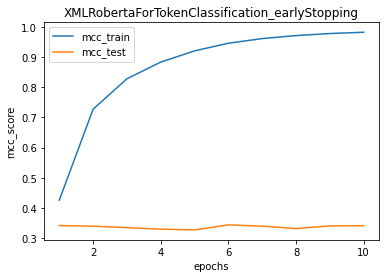

In [16]:
epochs = np.arange(1,epoch+1)
plt.plot(epochs,mcc_score_train[:-1],label='mcc_train')
plt.plot(epochs,mcc_score_test[:-1],label='mcc_test')
plt.xlabel('epochs')
plt.ylabel('mcc_score')
plt.title('XMLRobertaForTokenClassification_earlyStopping')
plt.legend()
plt.show()

In [53]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained('xlm-roberta-base')
config.num_labels

2

In [31]:
print(model)

DataParallel(
  (module): EntityModel(
    (bert): XLMRobertaForTokenClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(250002, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0): RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
              